In this script we will cluster the data, look for differential expression of cells and annotate the clusters.

In [1]:
import scanpy as scp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import pandas as pd
import io
import os
import json
import requests

from parameters import *

import warnings
warnings.filterwarnings("ignore") 

import sys
sys.path.append('../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot
import single_cell_tools.hyperparameter_selection as scthyp
from cdlib import evaluation

# Global

In [2]:
adata = scp.read(DIRECTORY+"Results/QC.h5ad")

## Clustering

For the clustering we perform leiden algorithm. 

In [3]:
#Clustering global
scp.tl.leiden(adata,resolution=RESOLUTION)

In [4]:
scthyp.leiden(adata,resolutions=np.arange(0.1,5,0.1),
       evaluation_metrics=[evaluation.newman_girvan_modularity])

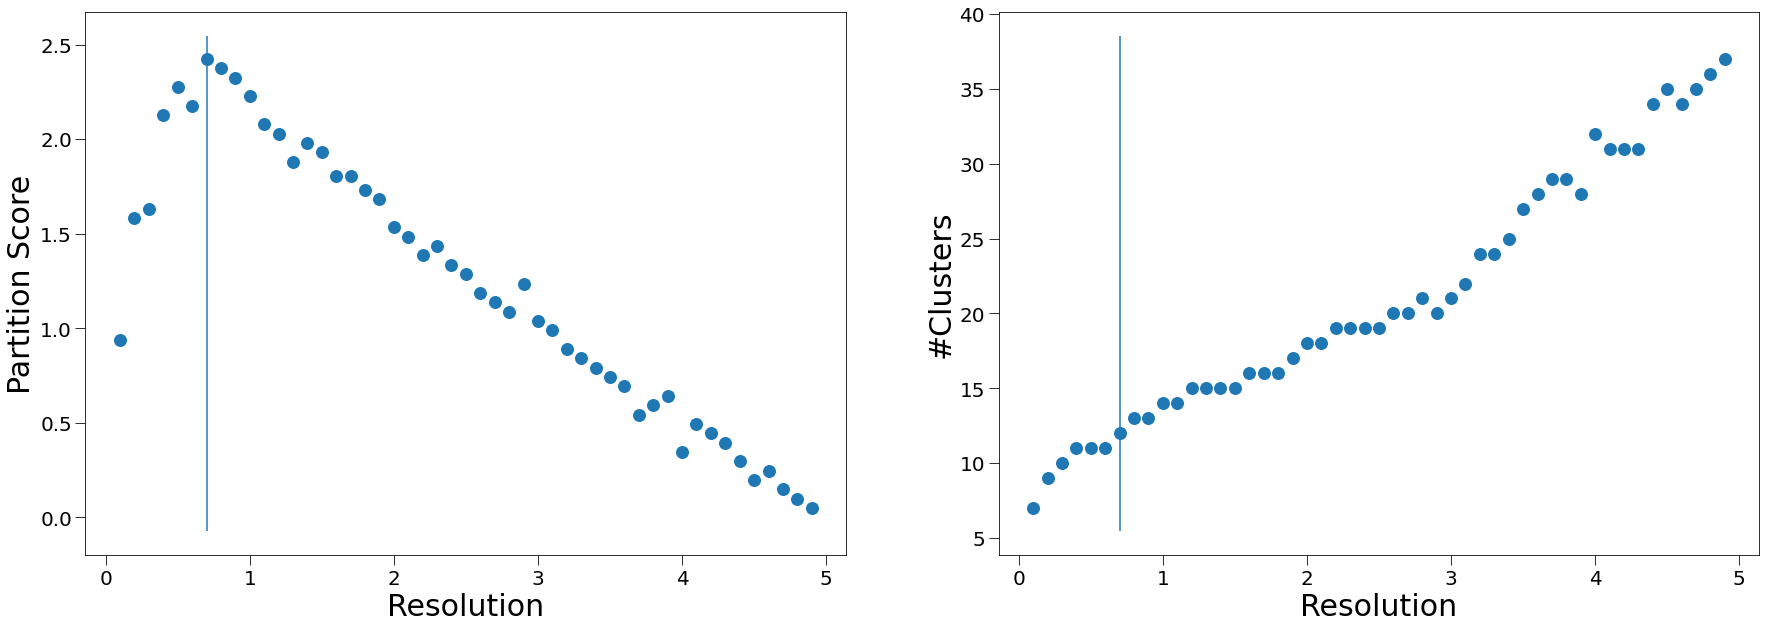

In [5]:
fig,ax = plt.subplots(1,2,figsize=[30,10])

sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["scores"],s=200,ax=ax[0])
sctplot.vline(ax[0],adata.uns["leiden"]["resolution_best"])
sctplot.plot_base(ax[0],labels=["Resolution","Partition Score"],legend=False)

sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["n_clusters"],s=200,ax=ax[1])
sctplot.vline(ax[1],adata.uns["leiden"]["resolution_best"])
sctplot.plot_base(ax[1],labels=["Resolution","#Clusters"],legend=False)

fig.savefig(DIRECTORY+"Plots/Global/CA_Clustering_Selection.pdf",bbox_inches="tight",transparent=True)

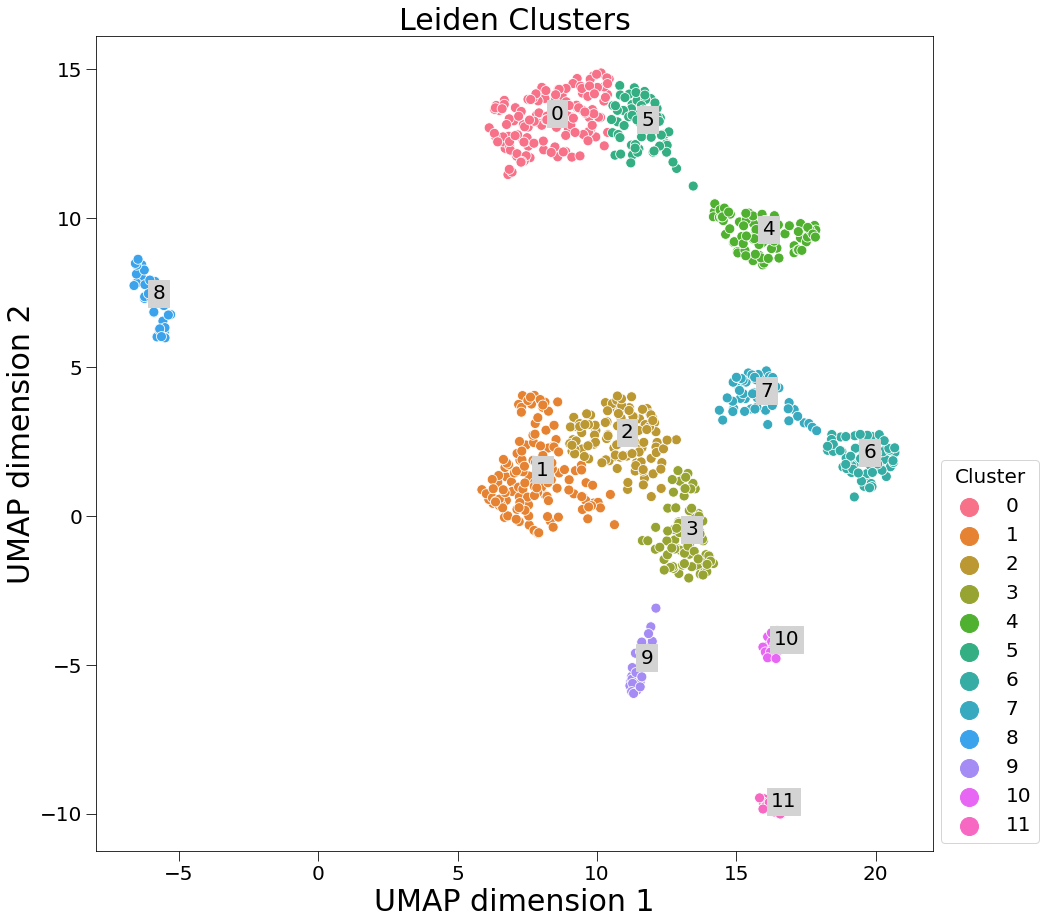

In [6]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

pca = "X_pca"
umap = "X_umap"
    
#Scatter plots
sns.scatterplot(x=adata.obsm[umap][:,0],y=adata.obsm[umap][:,1],hue=adata.obs["leiden"],s=100,ax=ax)
sctplot.plot_base(ax,title="Leiden Clusters",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,0.01),legend_title = "Cluster",legend_markerscale=3)
sctplot.plot_scatter_labels(ax,adata,"X_umap","leiden",fontsize=20, backgroundcolor="lightgrey")
    
#Save figures
fig.savefig(DIRECTORY+"Plots/Global/CA_UMAP_clusters.pdf",bbox_inches="tight",transparent=True)

## Contribution of the sorting methods to the clusters

We visualize the proportion of cells that contribute to each cluster, as well as the proportion of cells that contribute depending on the sorting condition from which we have generated the data.

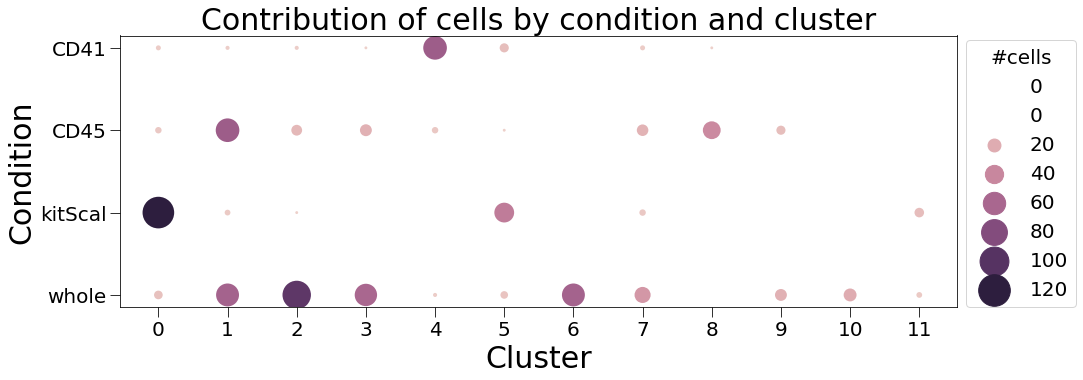

In [7]:
fig,ax = plt.subplots(1,1,figsize=[15,5])

#Make cluster contributions
data = adata.obs.groupby(by=["leiden","Condition"]).count()
data2 = data.unstack().loc[:,"Cell"].stack().reset_index()
sns.scatterplot(data=data2,x="leiden",y="Condition",hue=0,size=0,sizes=(0, 1000),ax=ax)
sctplot.plot_base(ax,title="Contribution of cells by condition and cluster",labels=["Cluster","Condition"],legend_title="#cells",legend_pos=(1.01,0.))

fig.savefig(DIRECTORY+"Plots/Global/CA_Condition_contribution_clusters.pdf",bbox_inches="tight",transparent=True)

## DE expression

We use Wilconxon rank test for the discovery of differentially expressed genes comparing each cluster against the rest. The table is saved in **Tables/global/DE_global.xslx**.

In [8]:
scp.tl.rank_genes_groups(adata,groupby="leiden",method=DE_TEST,use_raw=False)
scttools.rank_genes_to_excel(adata,"gene_name",DIRECTORY+"Tables/Global/Annotation"+DE_TEST+".xlsx",DE_GENES)

##  Relevant genes expression

In order to help the annotation, we plot the mean expression of the relevant genes separated by clusters.

In [9]:
genes = pd.read_excel("../Shared_data/Marker_genes_scRNAseq_Gx.xlsx",header=None,engine="openpyxl").values[:,0]

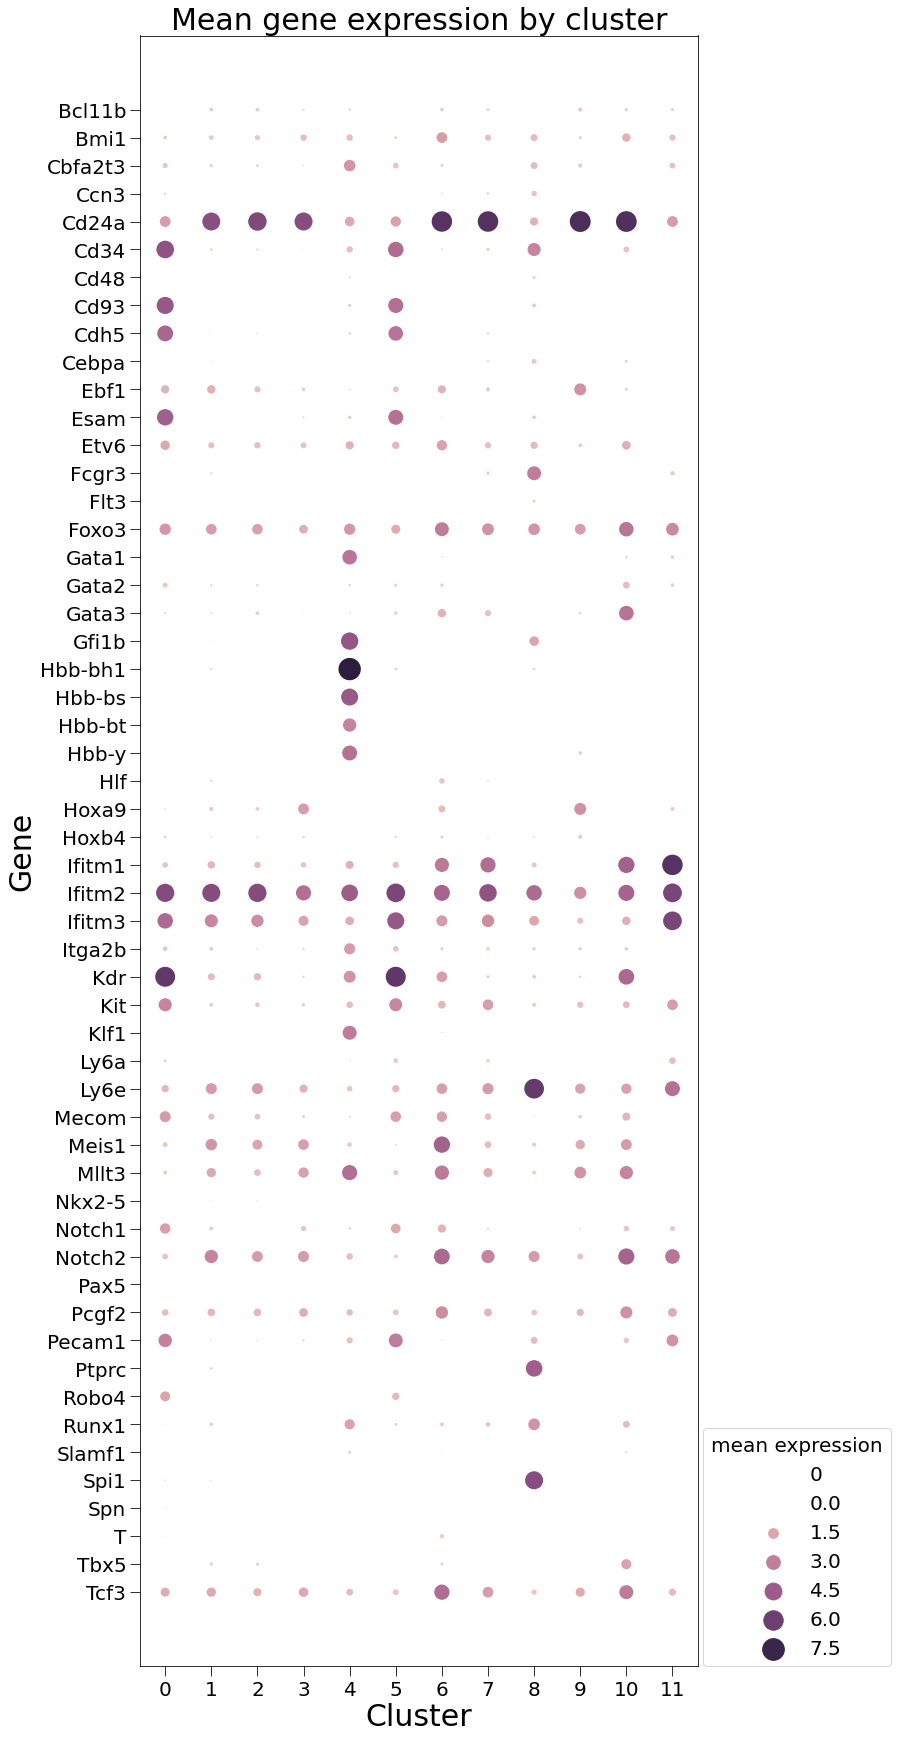

In [10]:
fig,ax = plt.subplots(1,1,figsize=[10,30])

data = pd.DataFrame()
data["cluster"] = adata.obs["leiden"]
for gene in np.sort(genes):
    if np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense()).size != 0:
        data[gene] = np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense())[:,0]
        
data = data.groupby(["cluster"]).mean().stack().reset_index()

sns.scatterplot(data=data,y="level_1",x="cluster",hue=0,size=0,sizes=(0,500),ax=ax)
sctplot.plot_base(ax,title="Mean gene expression by cluster",labels=["Cluster","Gene"],legend_pos=(1.01,0.),legend_title="mean expression")
    
fig.savefig(DIRECTORY+"Plots/Global/CA_Expression_relevant_genes_clusters.pdf",bbox_inches="tight",transparent=True)

## Enrichr

In [11]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata,library,DIRECTORY+"Tables/Global/Enrich_"+library+".xlsx")

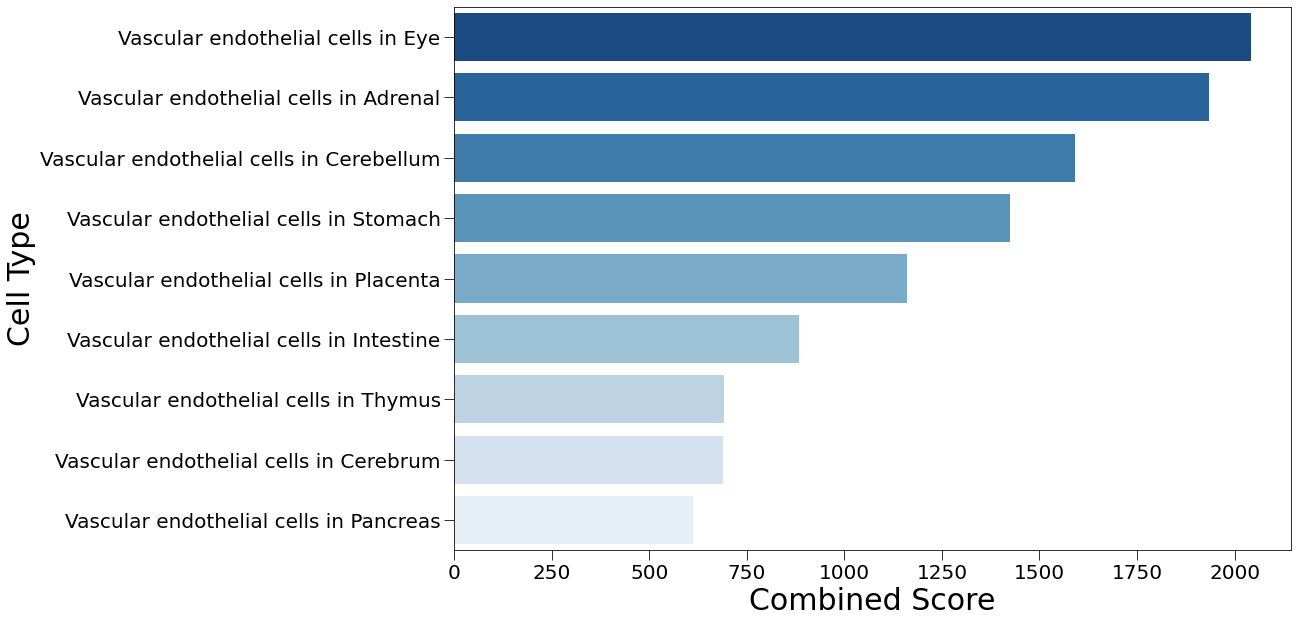

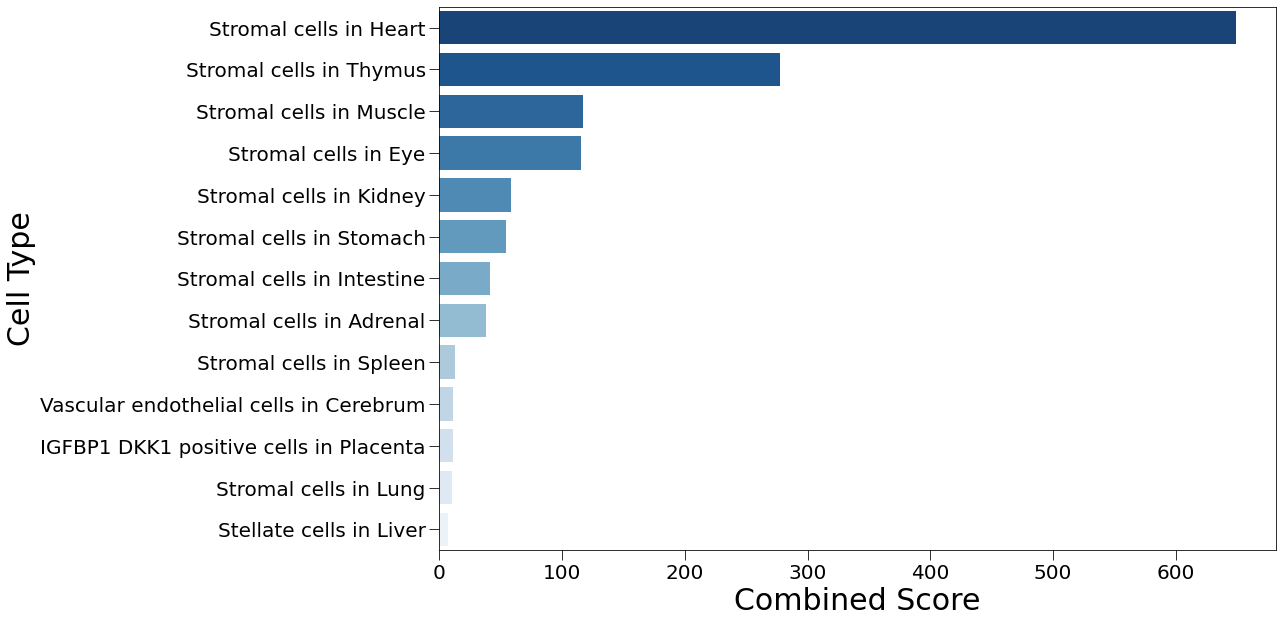

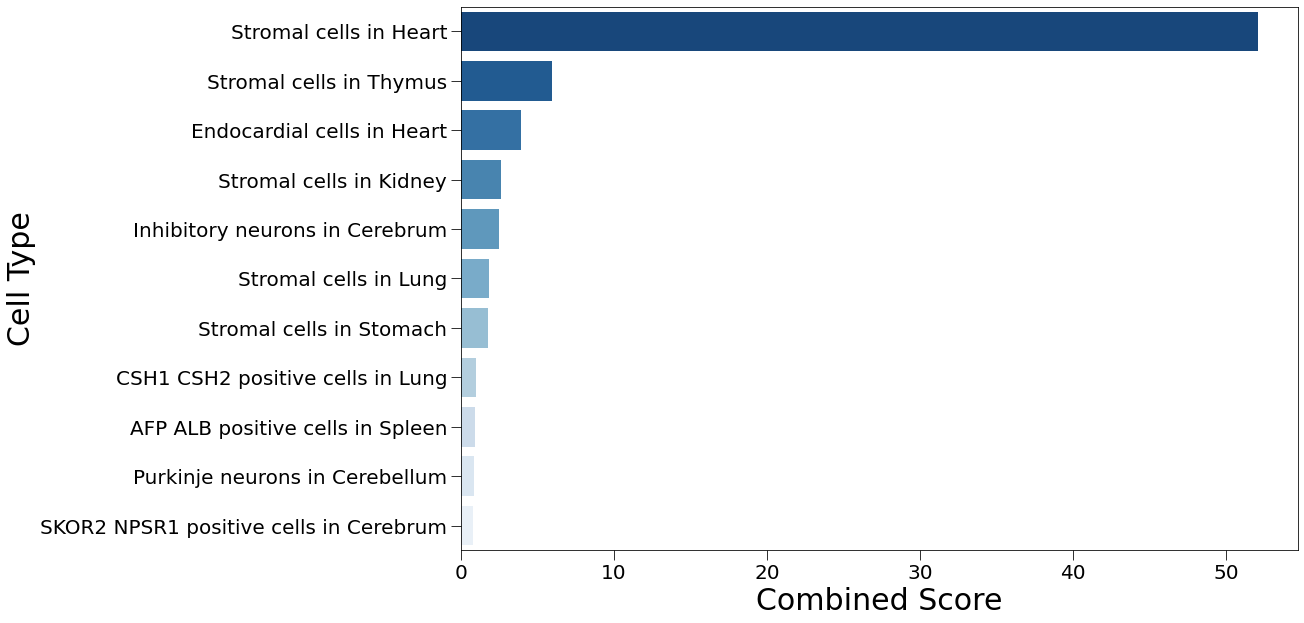

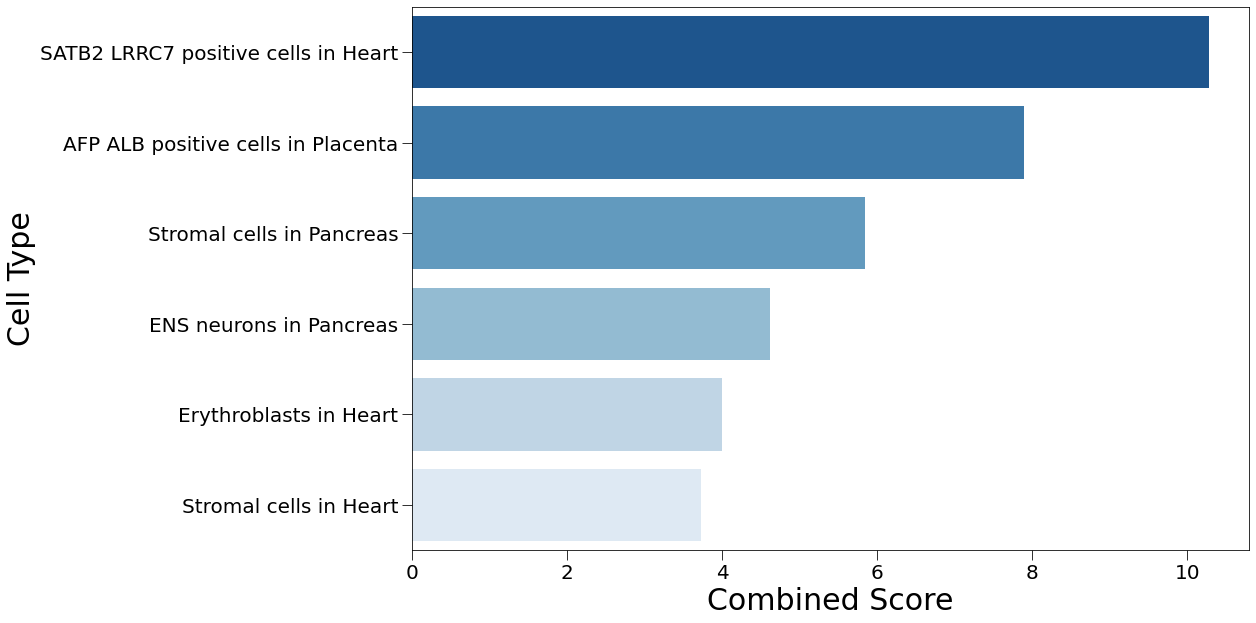

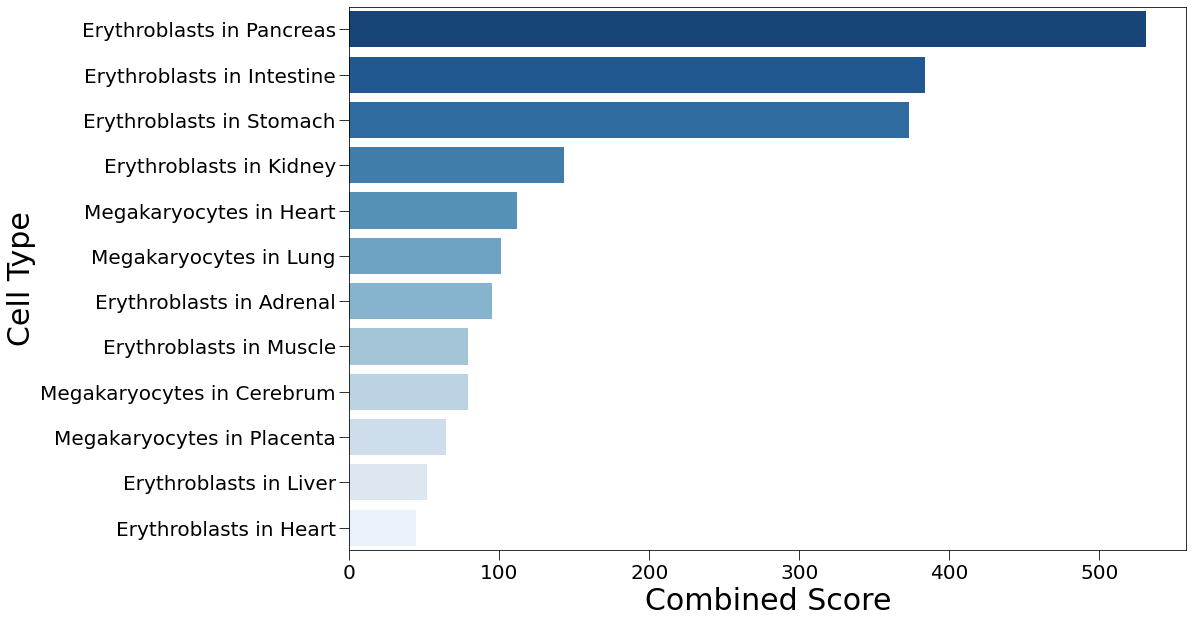

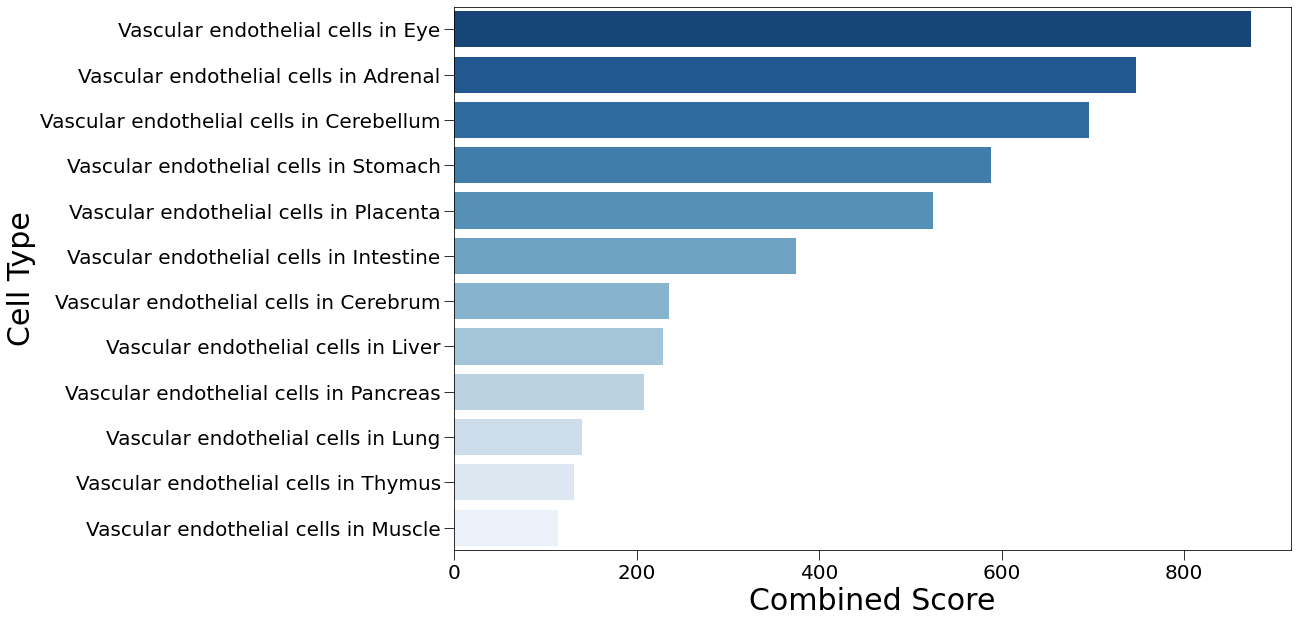

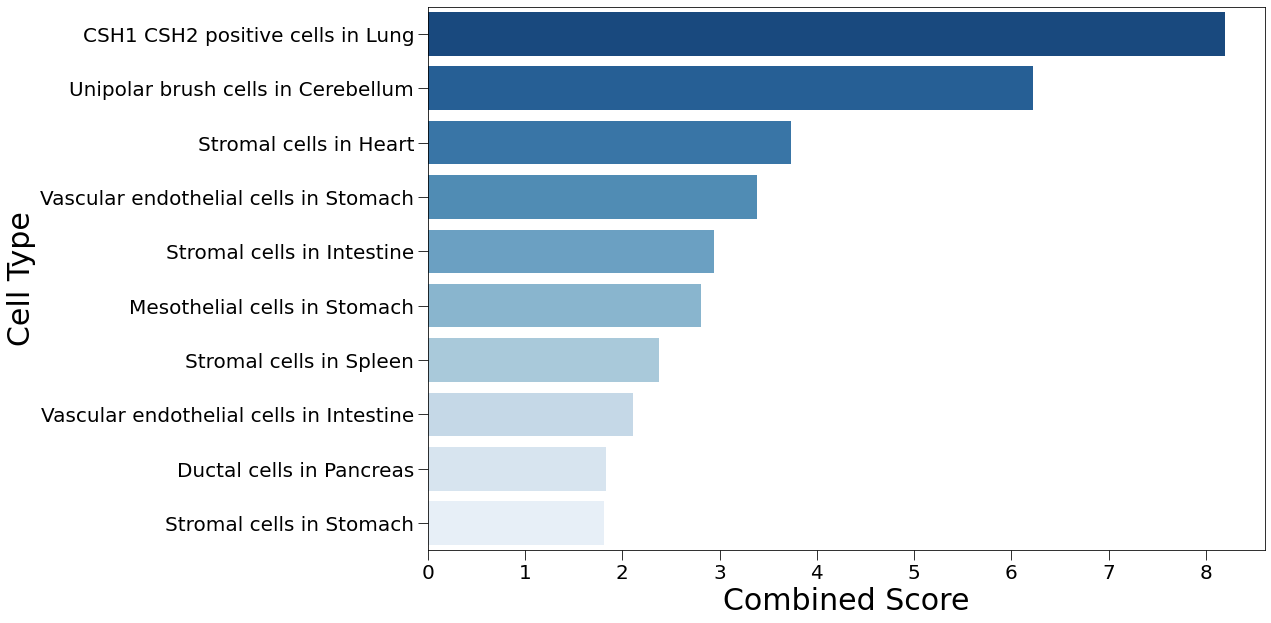

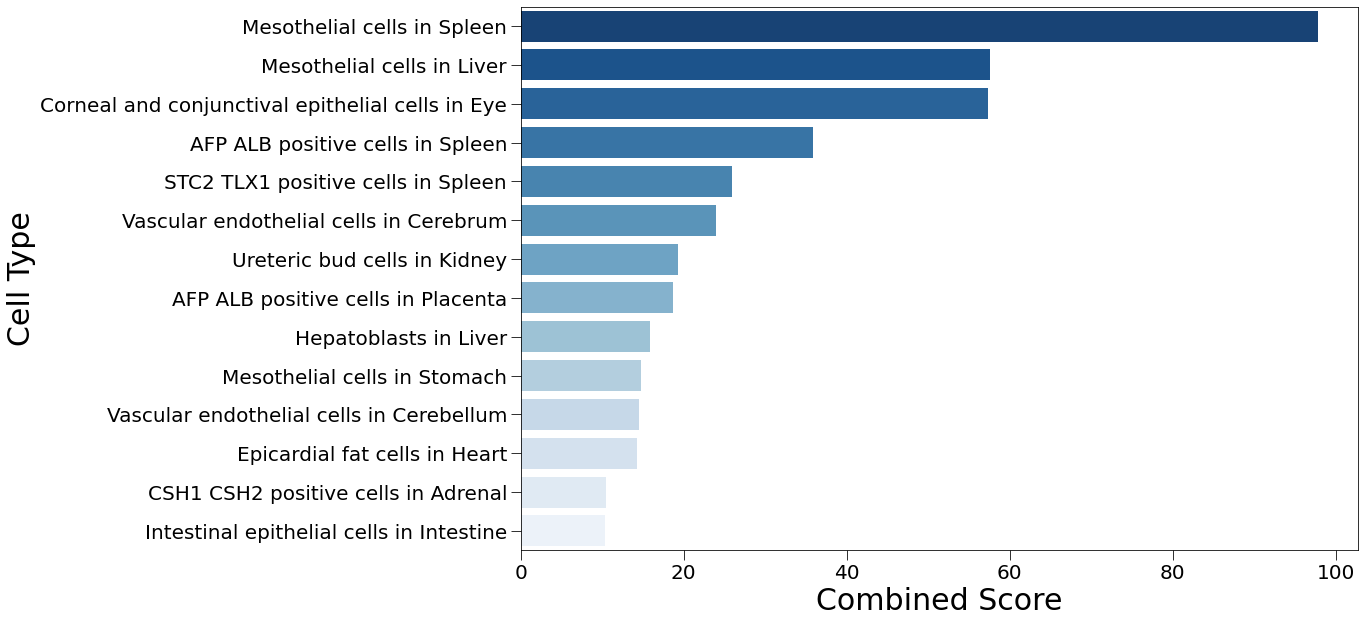

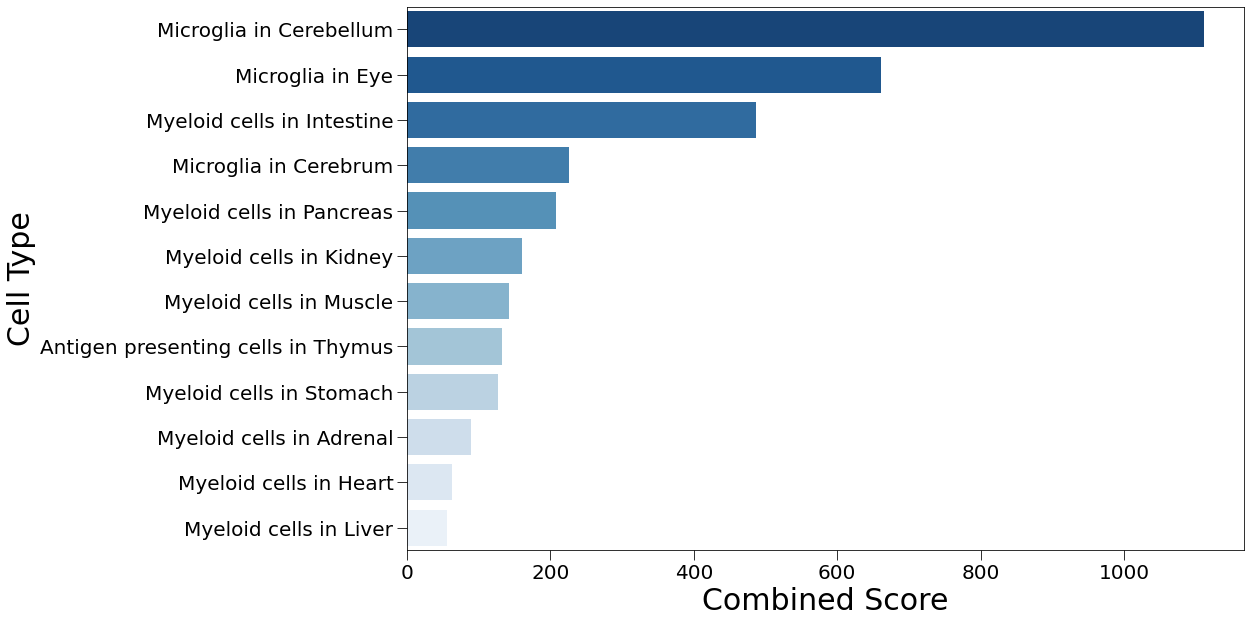

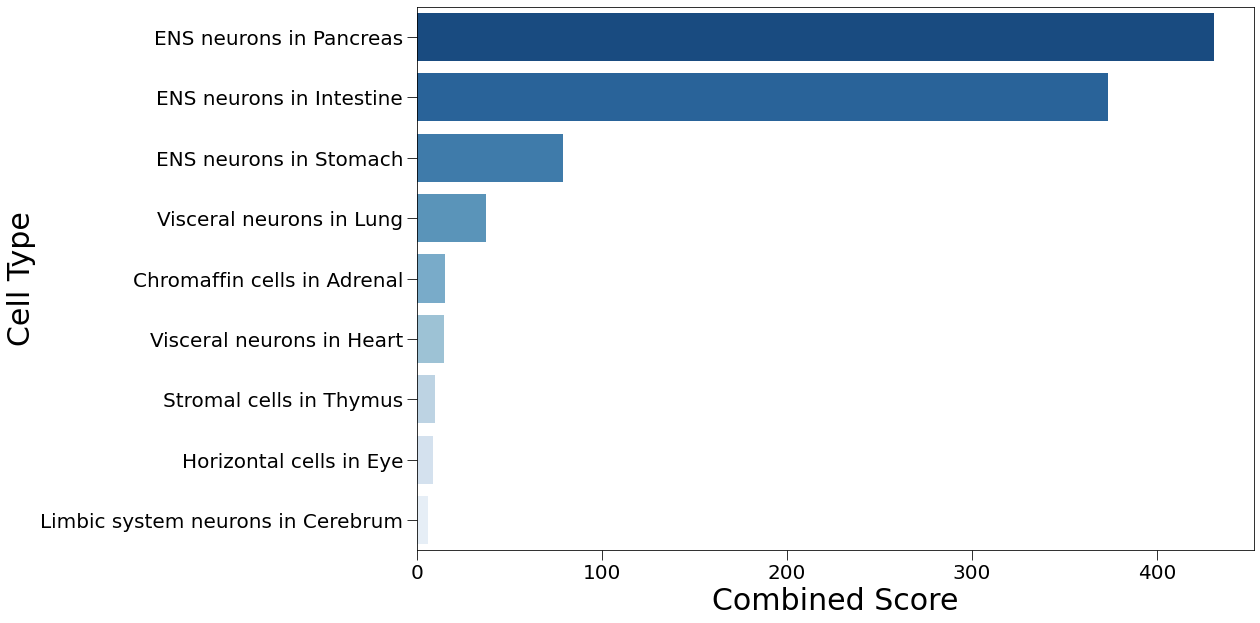

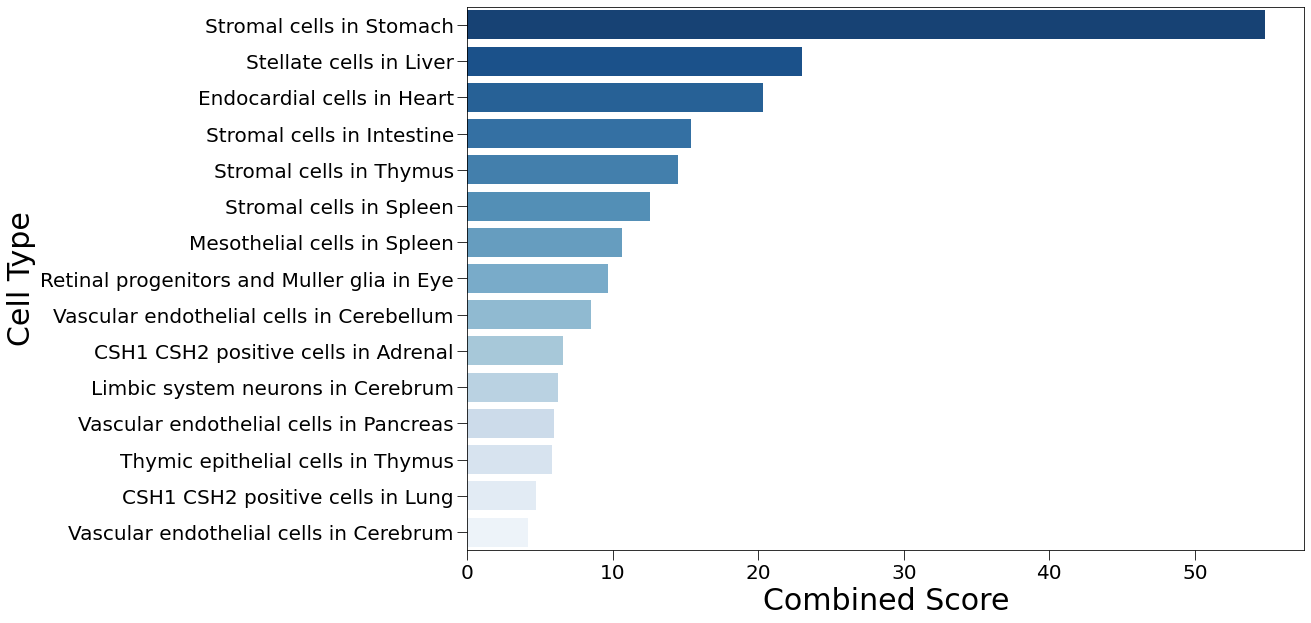

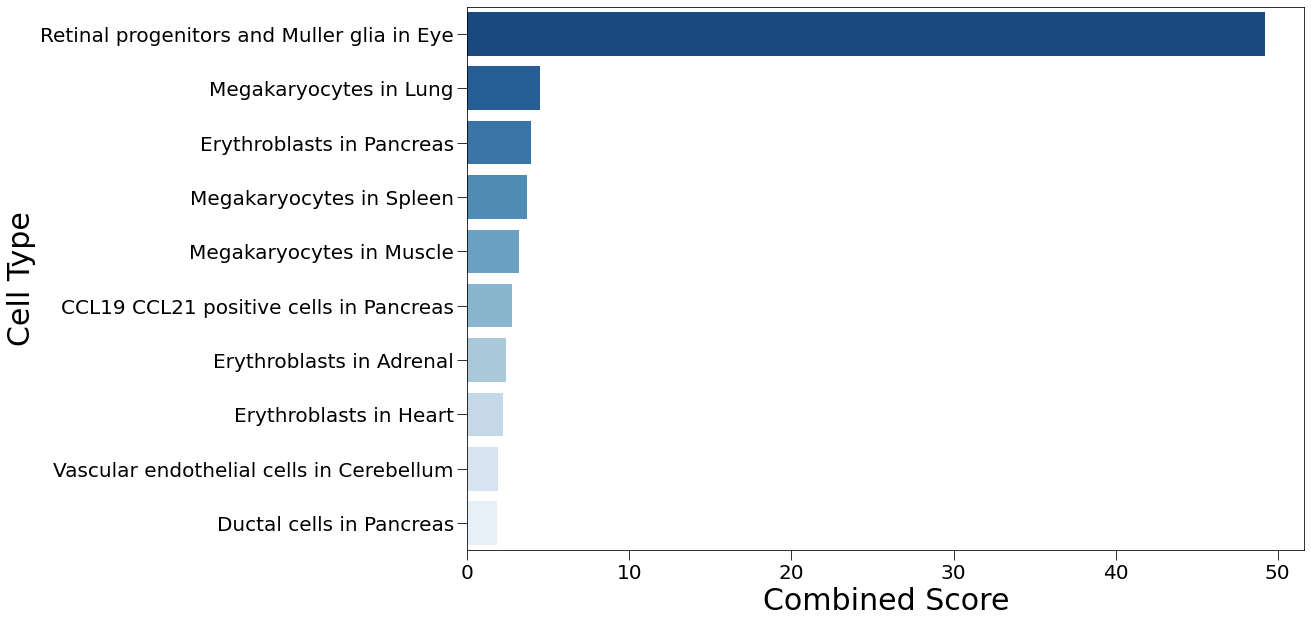

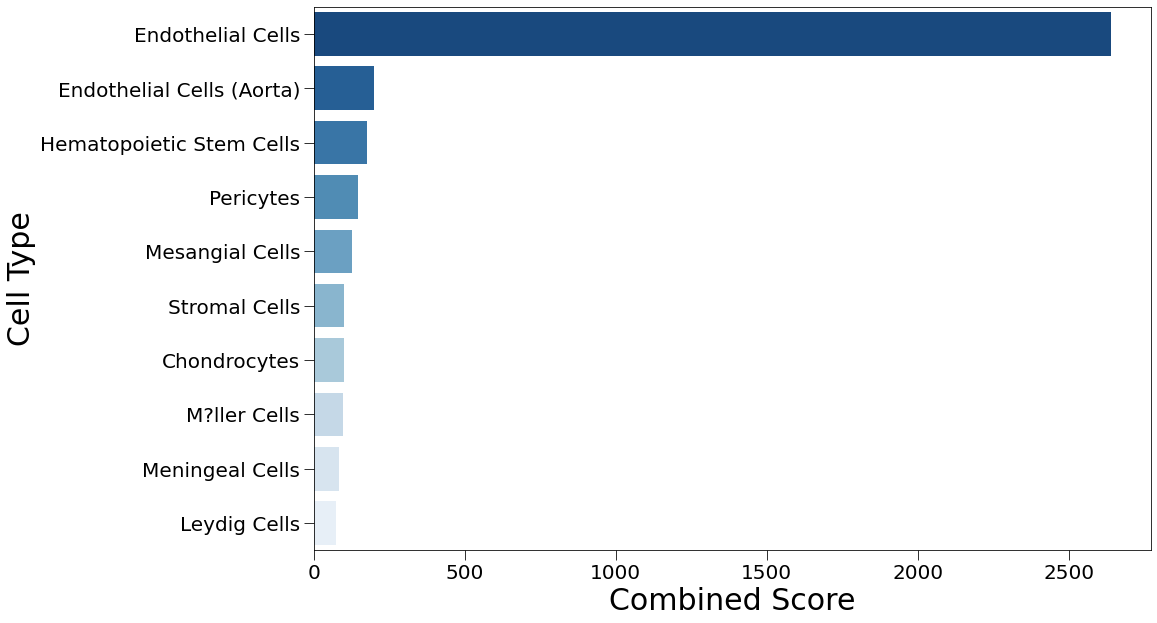

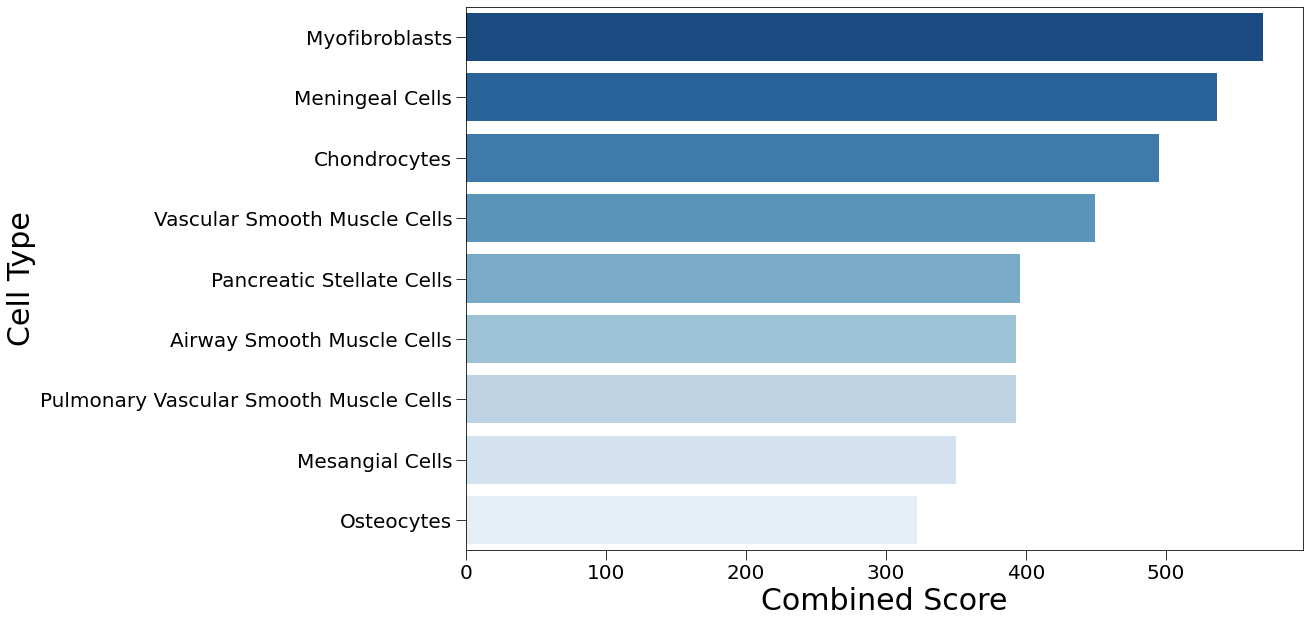

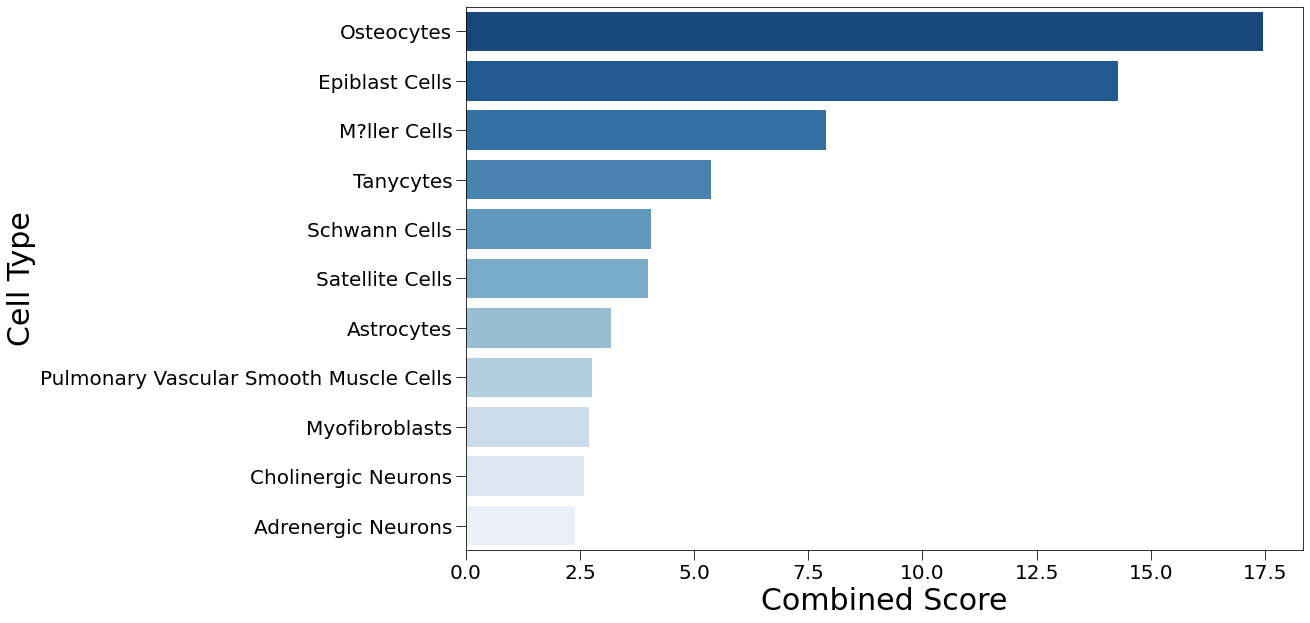

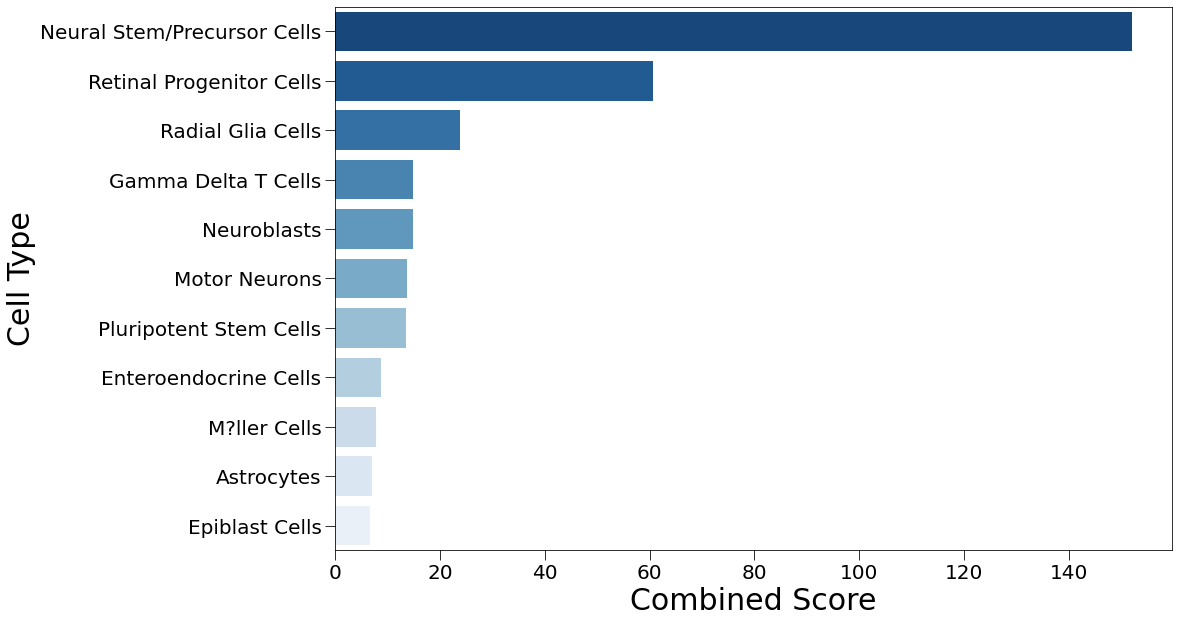

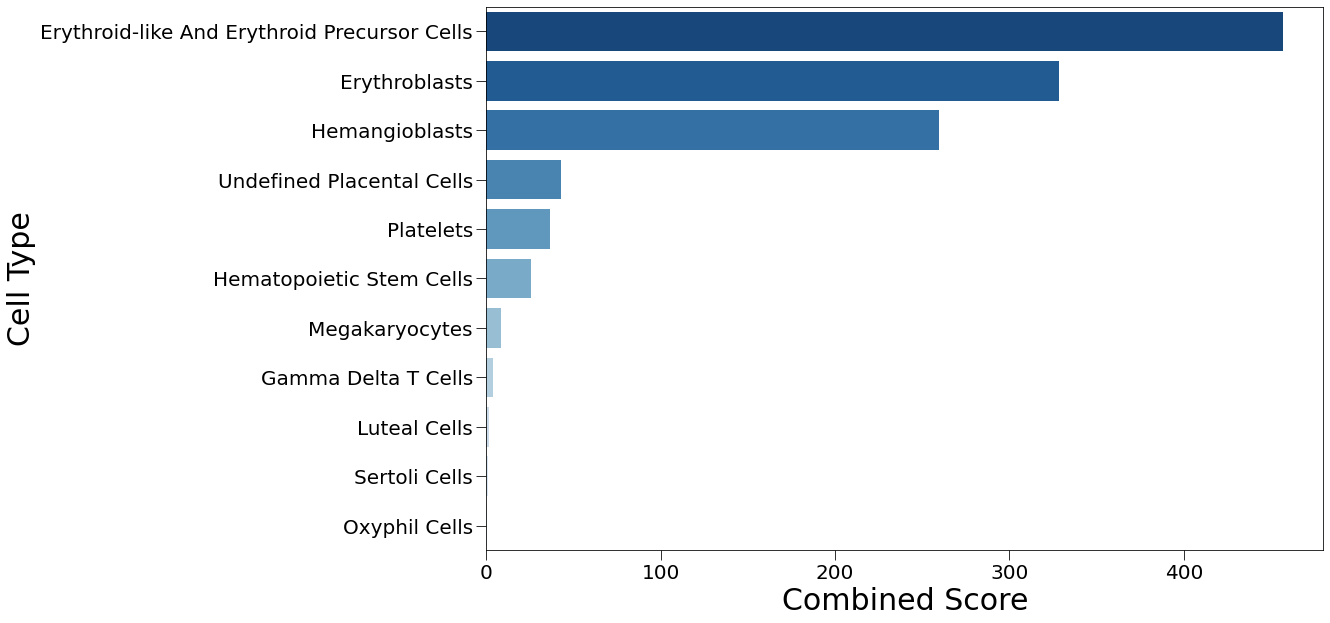

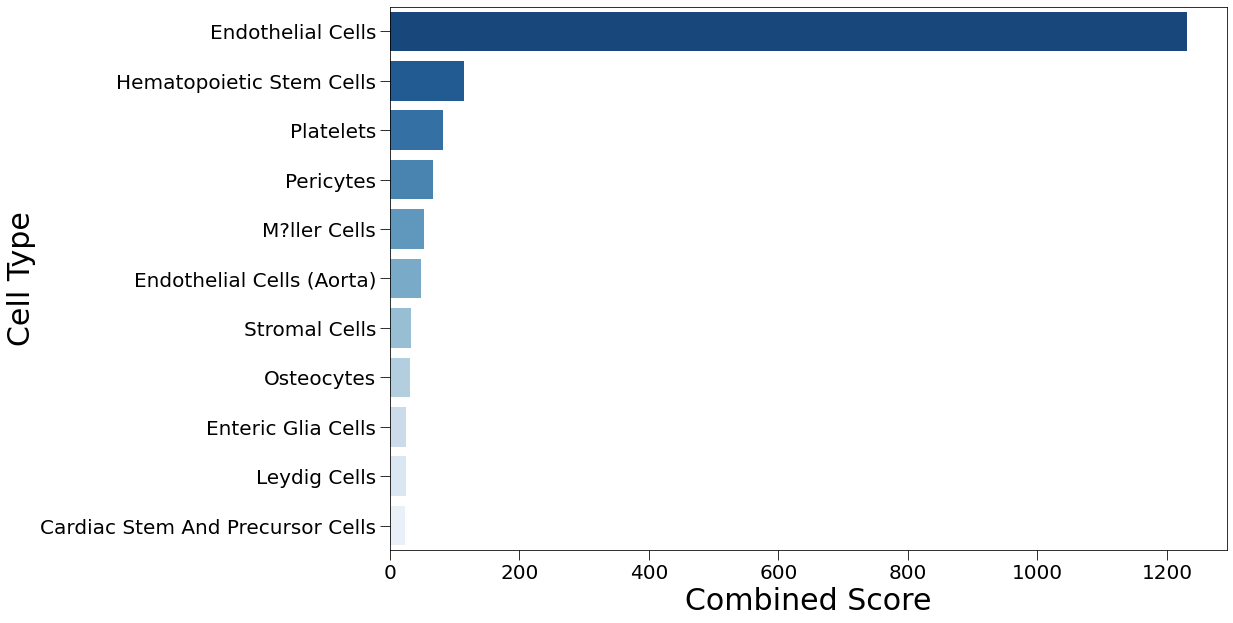

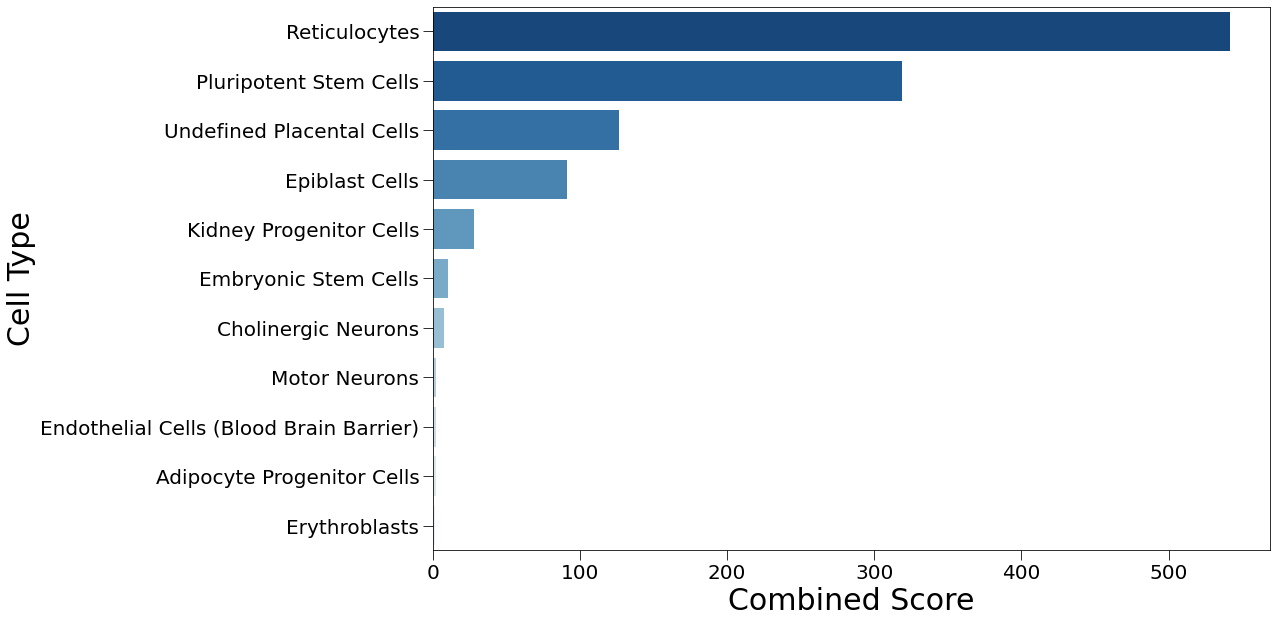

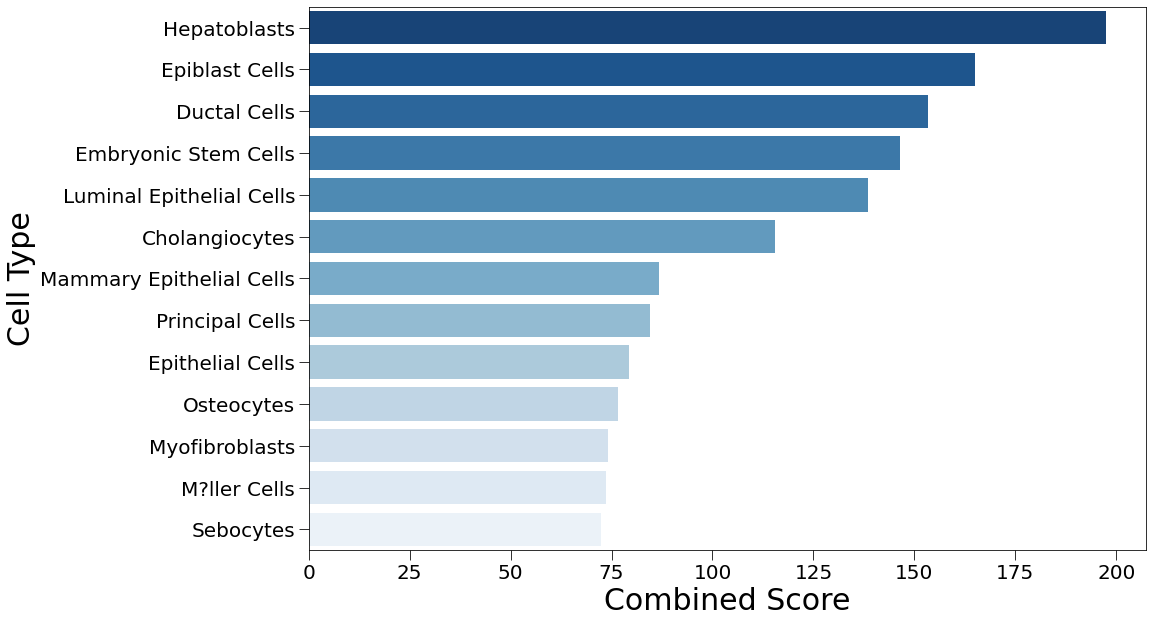

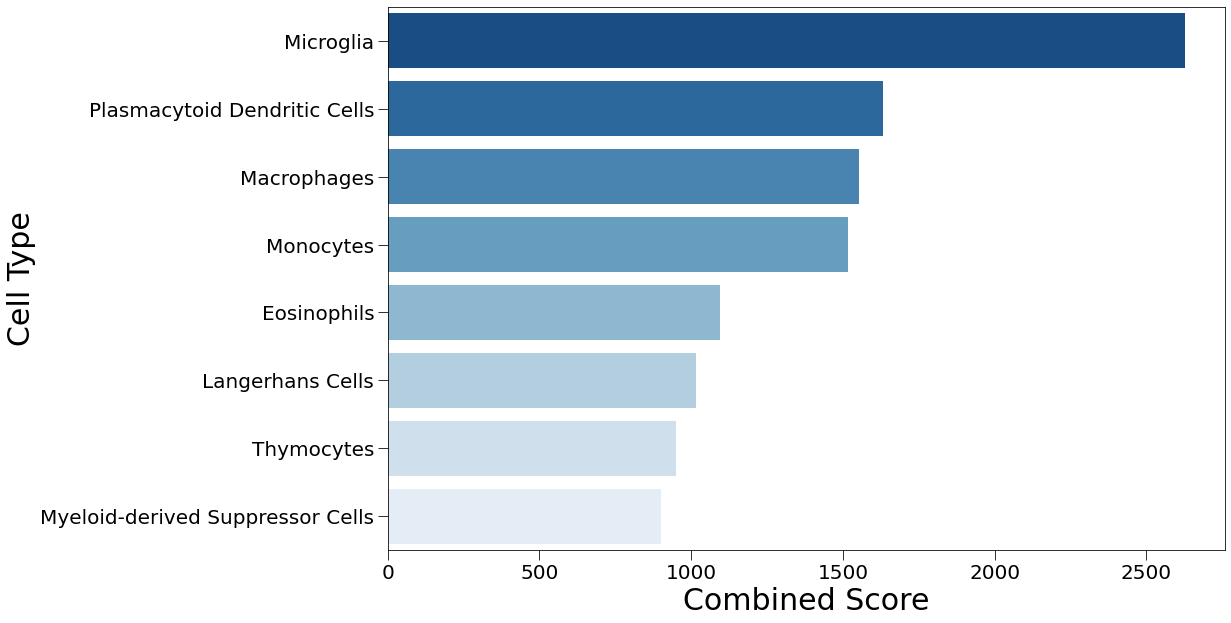

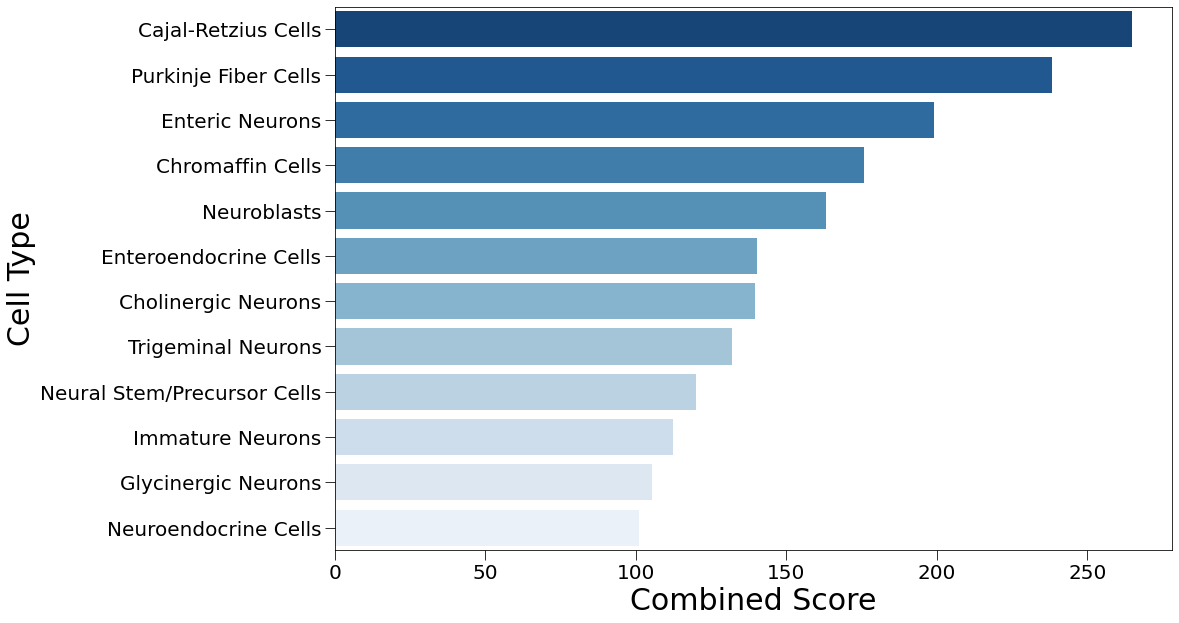

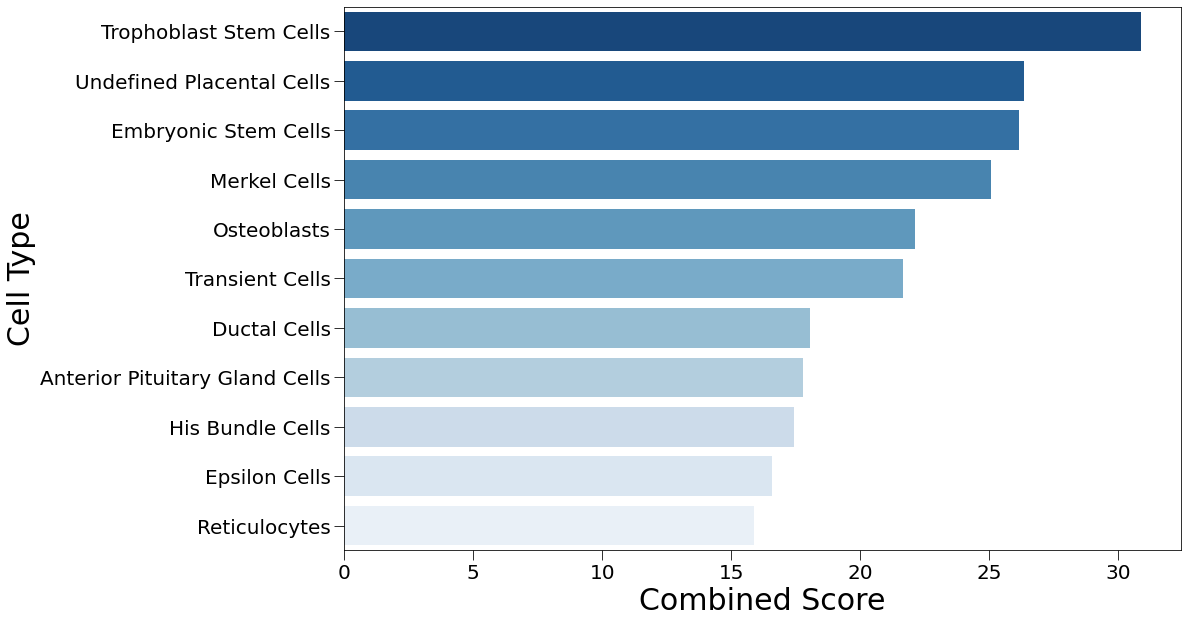

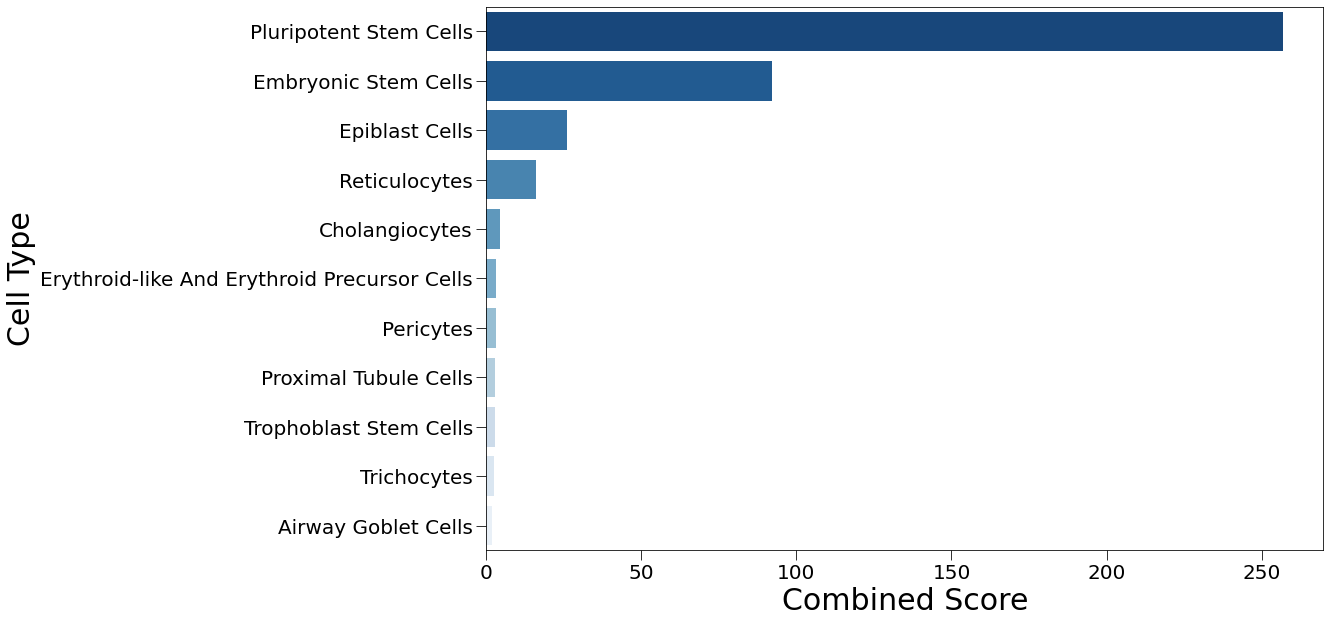

In [12]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile(DIRECTORY+"Tables/Global/Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel(DIRECTORY+"Tables/Global/Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,title=library+"_"+sheet,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig(DIRECTORY+"Plots/Global/Enrichr/"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")

## Save results

In [13]:
adata.write(DIRECTORY+"Results/QC.h5ad")

# Sorted

Since the hole dataset is pretty small and we are focusing the attention on rare cell types, we hypotetised that the whole gastruloid datasets could act as potential confounders. Hence, we perform a parallel analysis only considering the samples coming from sorted lanes, which in principle only contains data from cells candidate for our analysis.

In [14]:
adata = scp.read(DIRECTORY+"Results/QC_sorted.h5ad")

## Clustering

For the clustering we perform leiden algorithm. 

In [15]:
#Clustering global
scp.tl.leiden(adata,resolution=RESOLUTION)

In [16]:
scthyp.leiden(adata,resolutions=np.arange(0.1,5,0.1),
       evaluation_metrics=[evaluation.newman_girvan_modularity])

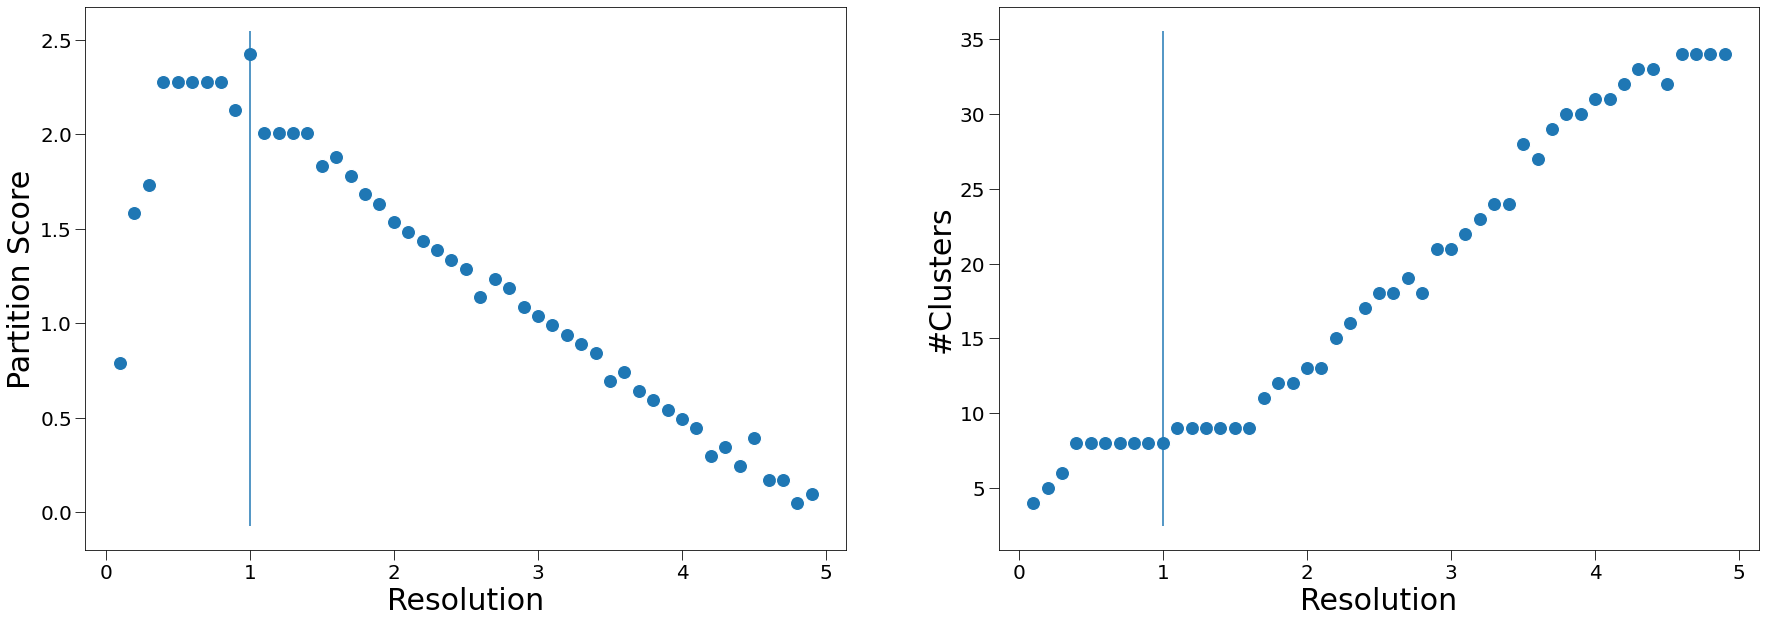

In [17]:
fig,ax = plt.subplots(1,2,figsize=[30,10])

sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["scores"],s=200,ax=ax[0])
sctplot.vline(ax[0],adata.uns["leiden"]["resolution_best"])
sctplot.plot_base(ax[0],labels=["Resolution","Partition Score"],legend=False)

sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["n_clusters"],s=200,ax=ax[1])
sctplot.vline(ax[1],adata.uns["leiden"]["resolution_best"])
sctplot.plot_base(ax[1],labels=["Resolution","#Clusters"],legend=False)

fig.savefig(DIRECTORY+"Plots/Sorted/CA_Clustering_Selection.pdf",bbox_inches="tight",transparent=True)

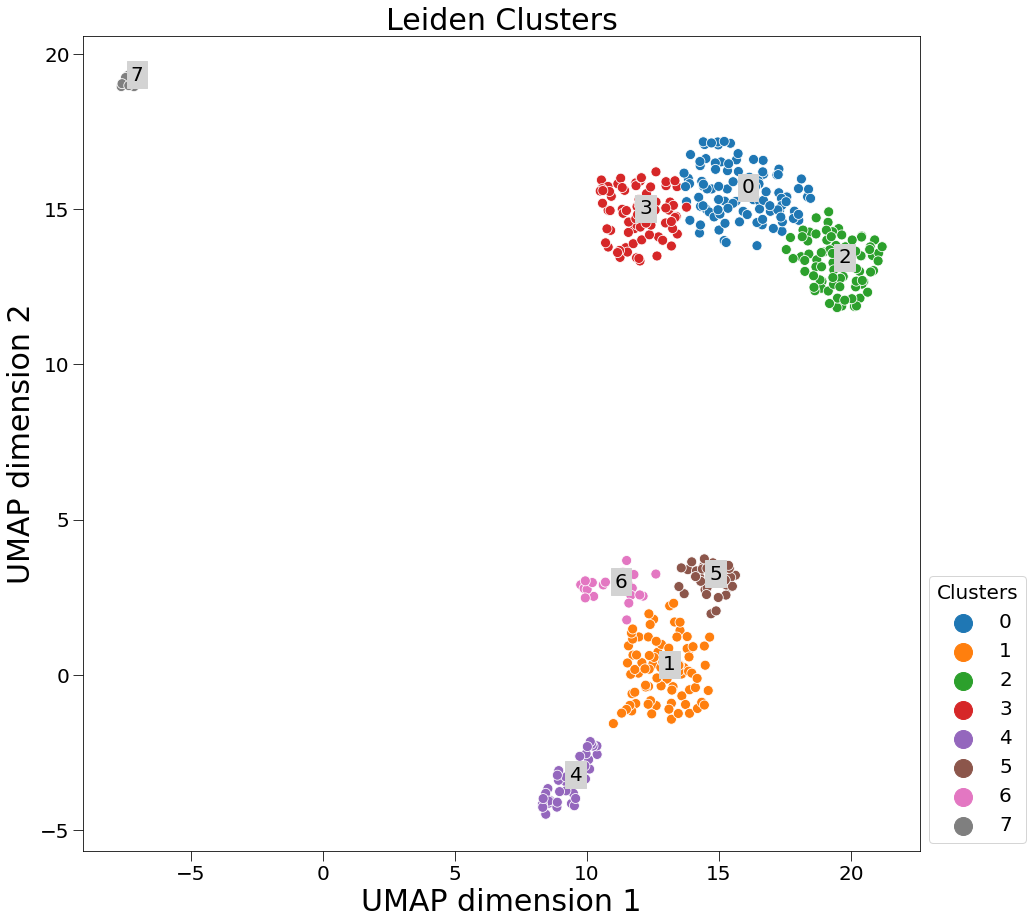

In [18]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

pca = "X_pca"
umap = "X_umap"
    
#Scatter plots
sns.scatterplot(x=adata.obsm[umap][:,0],y=adata.obsm[umap][:,1],hue=adata.obs["leiden"],s=100,ax=ax)
sctplot.plot_base(ax,title="Leiden Clusters",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,0.01),legend_markerscale=3,legend_title="Clusters")
sctplot.plot_scatter_labels(ax,adata,"X_umap","leiden",fontsize=20,backgroundcolor="lightgrey")
    
#Save figures
fig.savefig(DIRECTORY+"Plots/Sorted/CA_UMAP_clusters.pdf",bbox_inches="tight",transparent=True)

## Contribution of the sorting methods to the clusters

We visualize the proportion of cells that contribute to each cluster, as well as the proportion of cells that contribute depending on the sorting condition from which we have generated the data.DIRECTORY

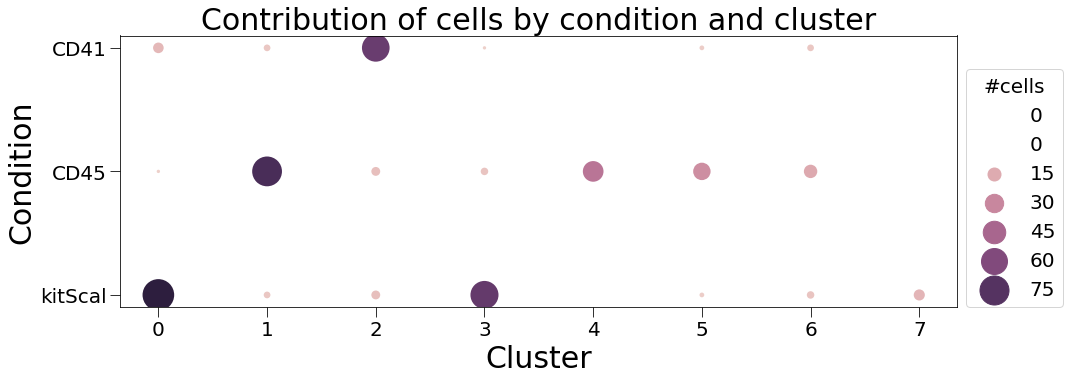

In [19]:
fig,ax = plt.subplots(1,1,figsize=[15,5])

#Make cluster contributions
data = adata.obs.groupby(by=["leiden","Condition"]).count()
data2 = data.unstack().loc[:,"Cell"].stack().reset_index()
sns.scatterplot(data=data2,x="leiden",y="Condition",hue=0,size=0,sizes=(0, 1000),ax=ax)
sctplot.plot_base(ax,title="Contribution of cells by condition and cluster",labels=["Cluster","Condition"],legend_title="#cells",legend_pos=(1.01,0.))

fig.savefig(DIRECTORY+"Plots/Sorted/CA_Condition_contribution_clusters.pdf",bbox_inches="tight",transparent=True)

## DE expression

In [20]:
scp.tl.rank_genes_groups(adata,groupby="leiden",method=DE_TEST,use_raw=False)
scttools.rank_genes_to_excel(adata,"gene_name",DIRECTORY+"Tables/Sorted/Annotation"+DE_TEST+".xlsx",DE_GENES)

##  Relevant genes expression

In order to help the annotation, we plot the mean expression of the relevant genes separated by clusters.

In [21]:
genes = pd.read_excel("../Shared_data/Marker_genes_scRNAseq_Gx.xlsx",header=None,engine="openpyxl").values[:,0]

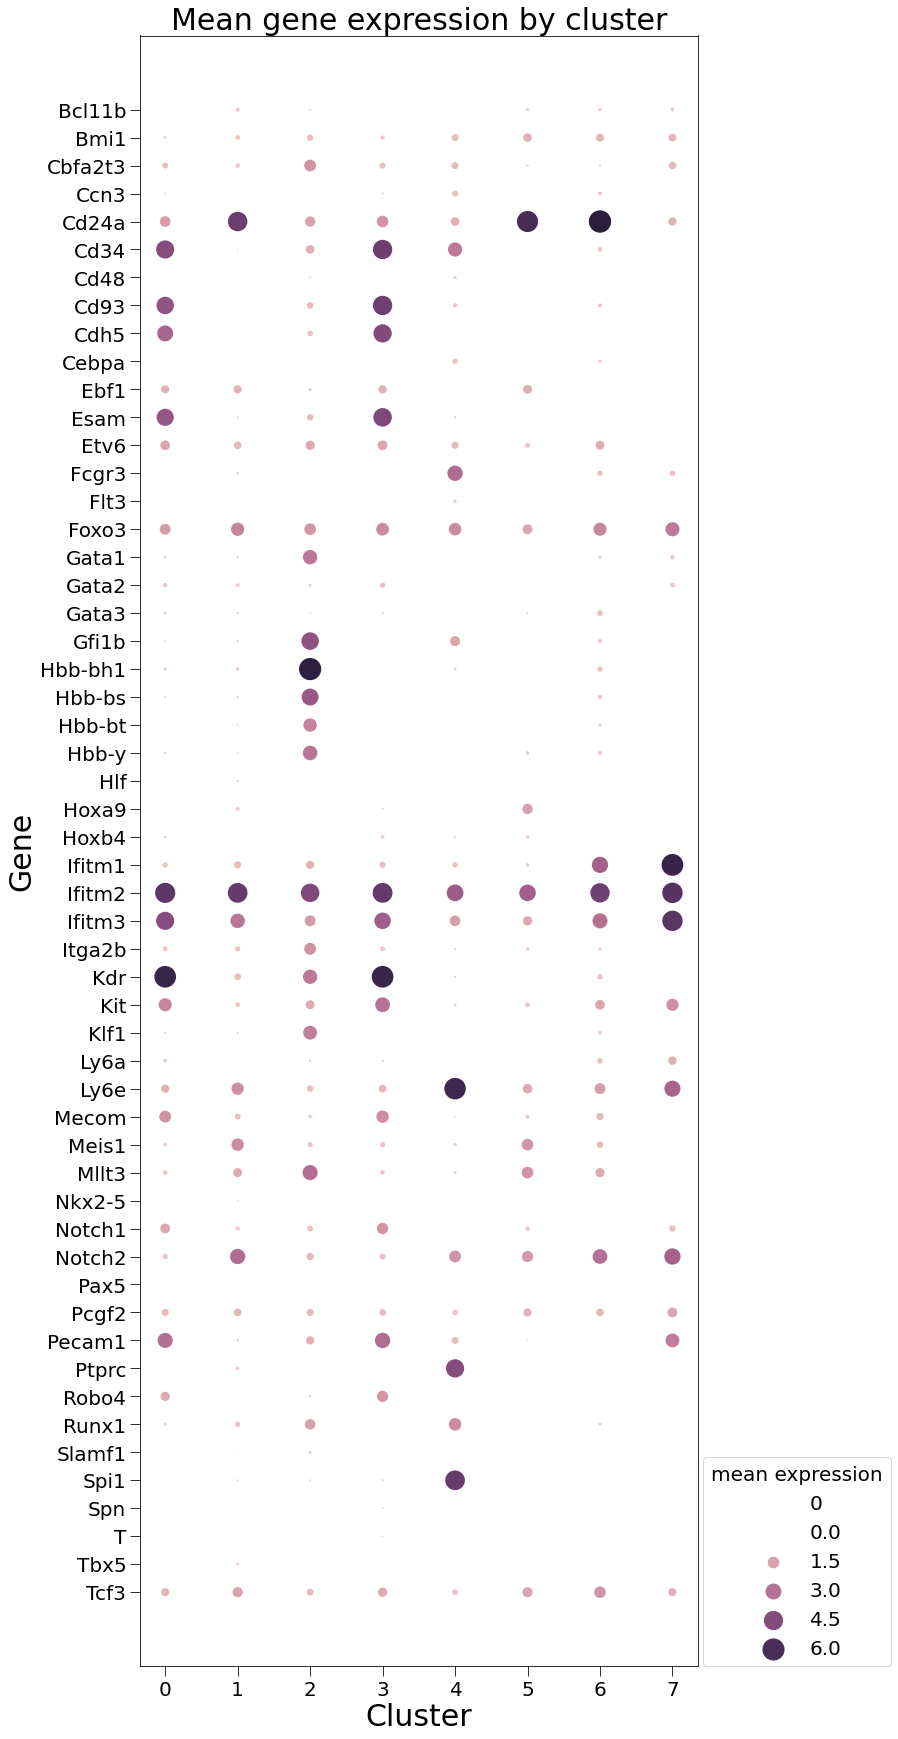

In [22]:
fig,ax = plt.subplots(1,1,figsize=[10,30])

data = pd.DataFrame()
data["cluster"] = adata.obs["leiden"]
for gene in np.sort(genes):
    if np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense()).size != 0:
        data[gene] = np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense())[:,0]
        
data = data.groupby(["cluster"]).mean().stack().reset_index()

sns.scatterplot(data=data,y="level_1",x="cluster",hue=0,size=0,sizes=(0,500),ax=ax)
sctplot.plot_base(ax,title="Mean gene expression by cluster",labels=["Cluster","Gene"],legend_pos=(1.01,0.),legend_title="mean expression")
    
fig.savefig(DIRECTORY+"Plots/Sorted/AC_expression_relevant_genes_clusters.pdf",bbox_inches="tight",transparent=True)

## Enrichr

In [23]:
for library in ENRICHR_LIBRARIES:
    scttools.enrichr_to_excel(adata,library,DIRECTORY+"Tables/Sorted/Enrich_"+library+".xlsx")

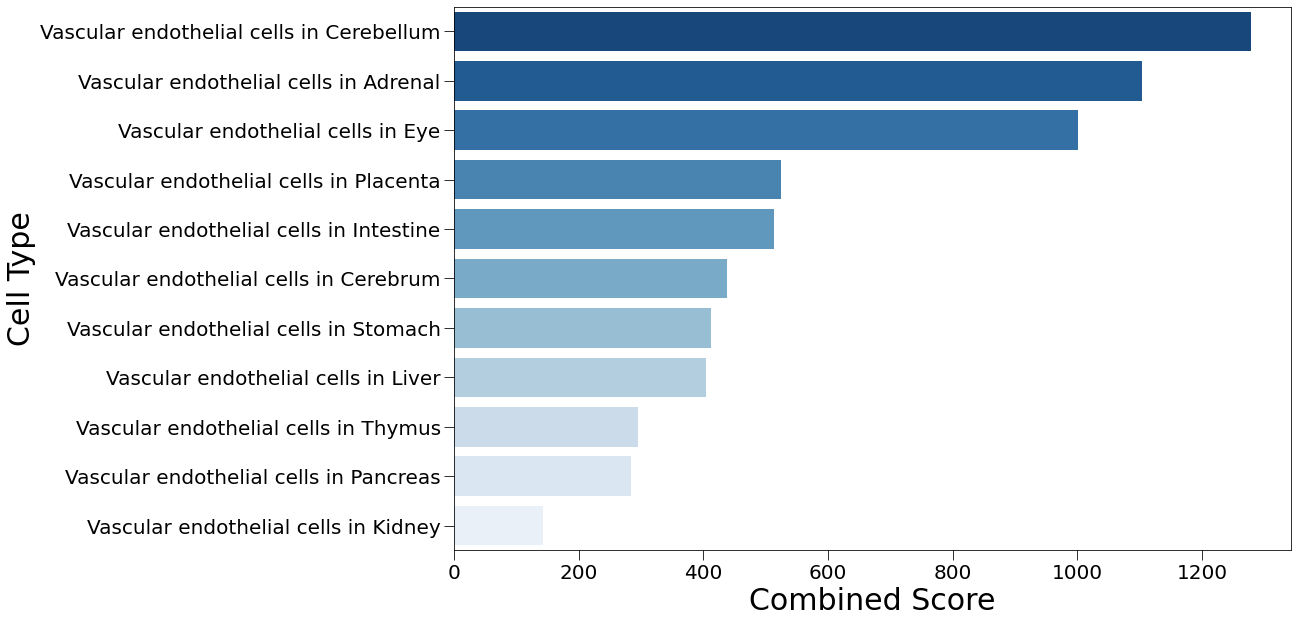

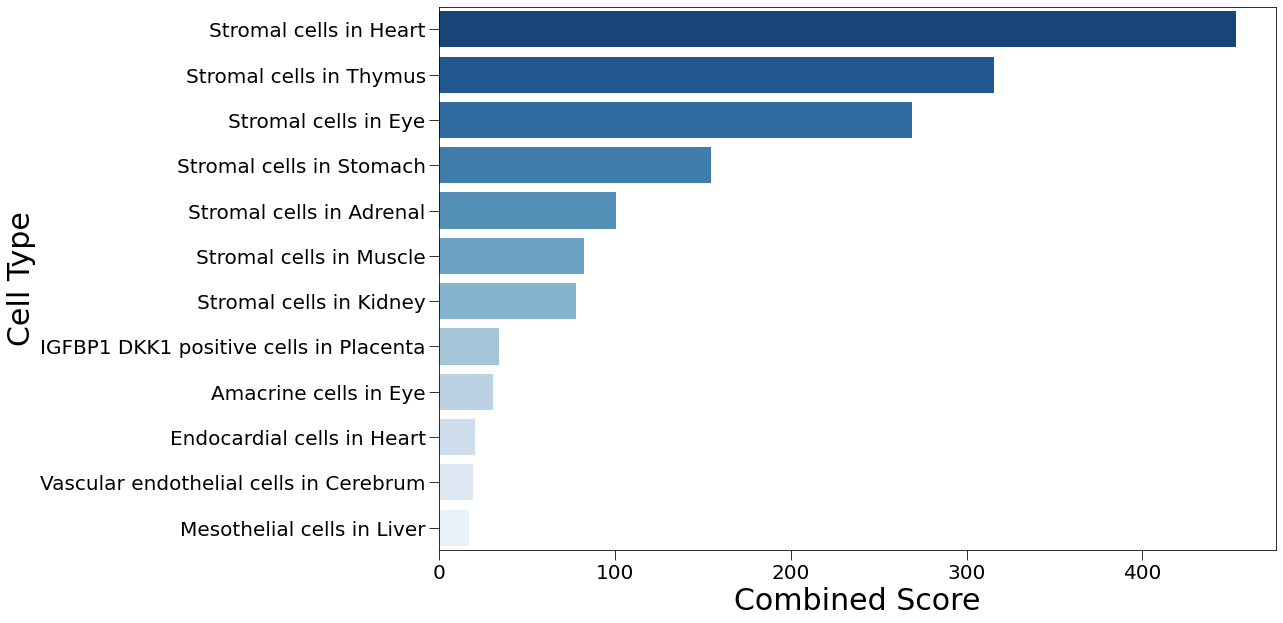

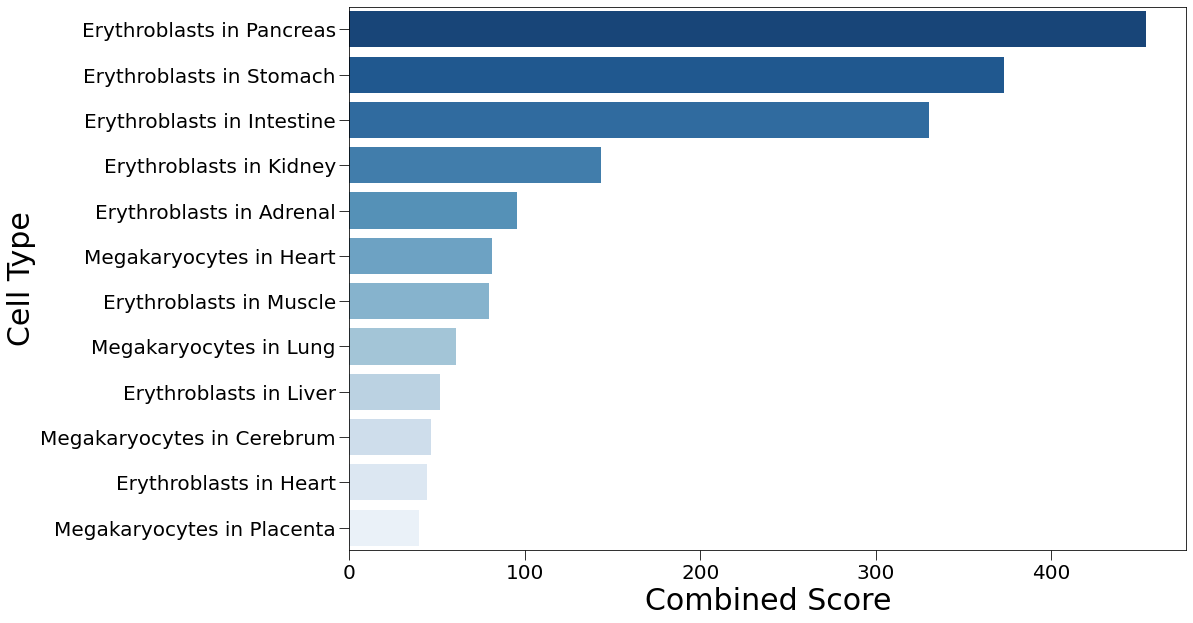

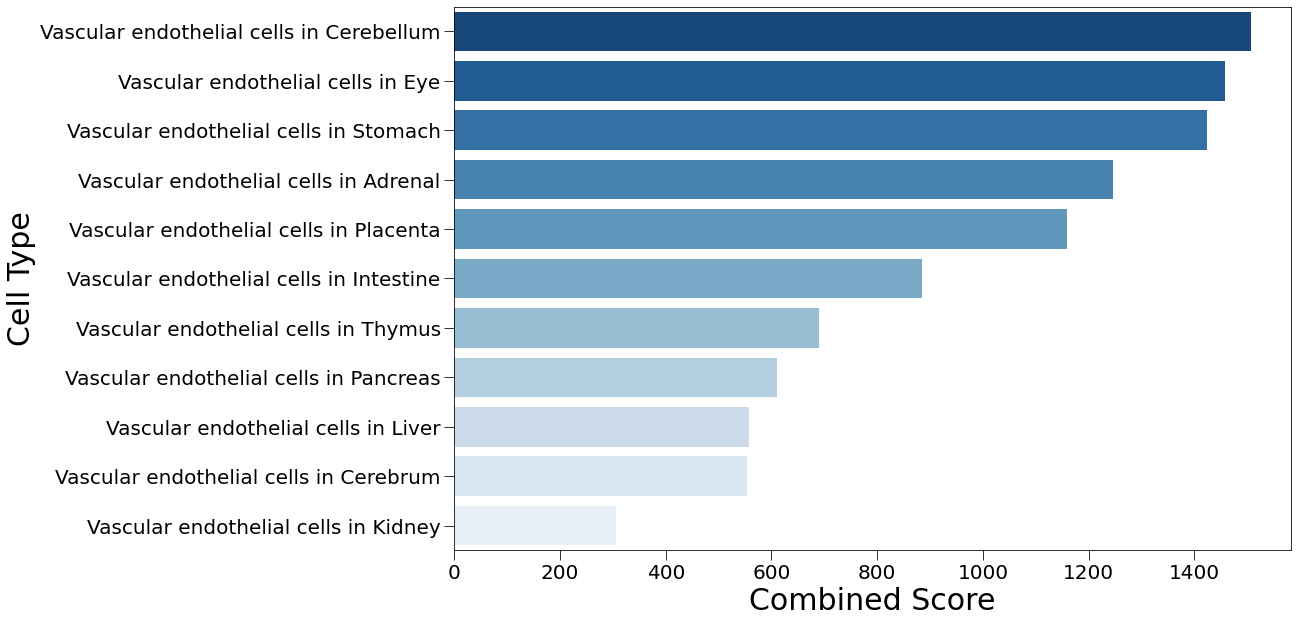

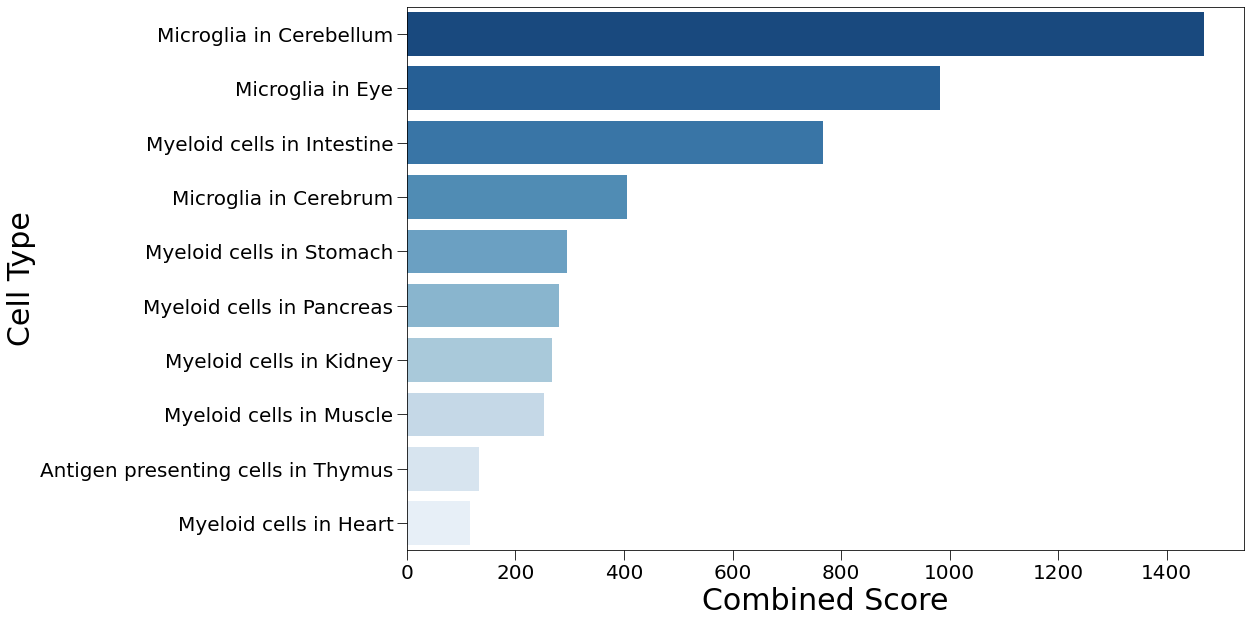

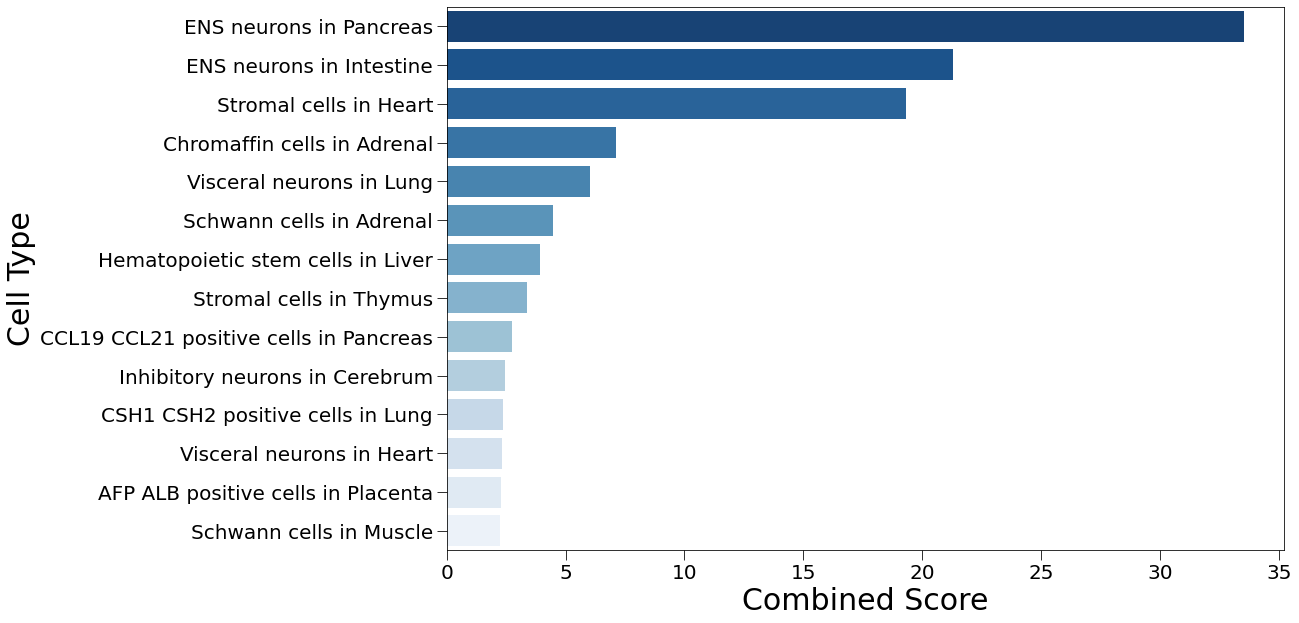

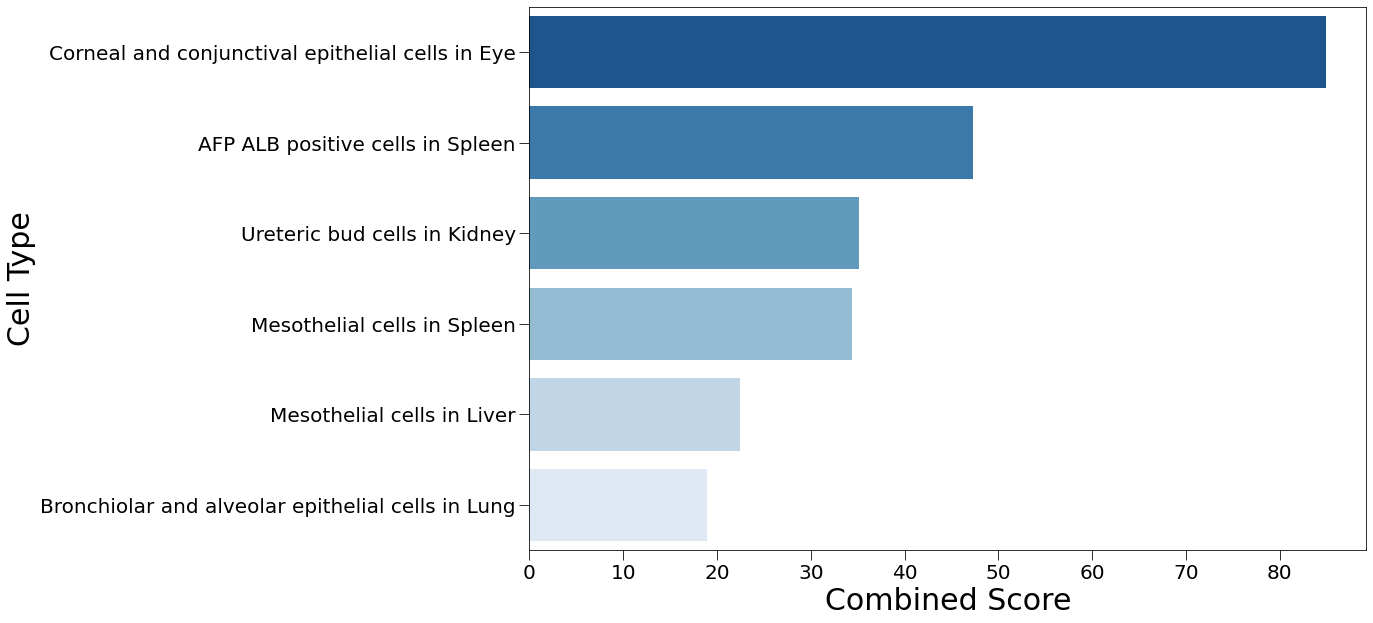

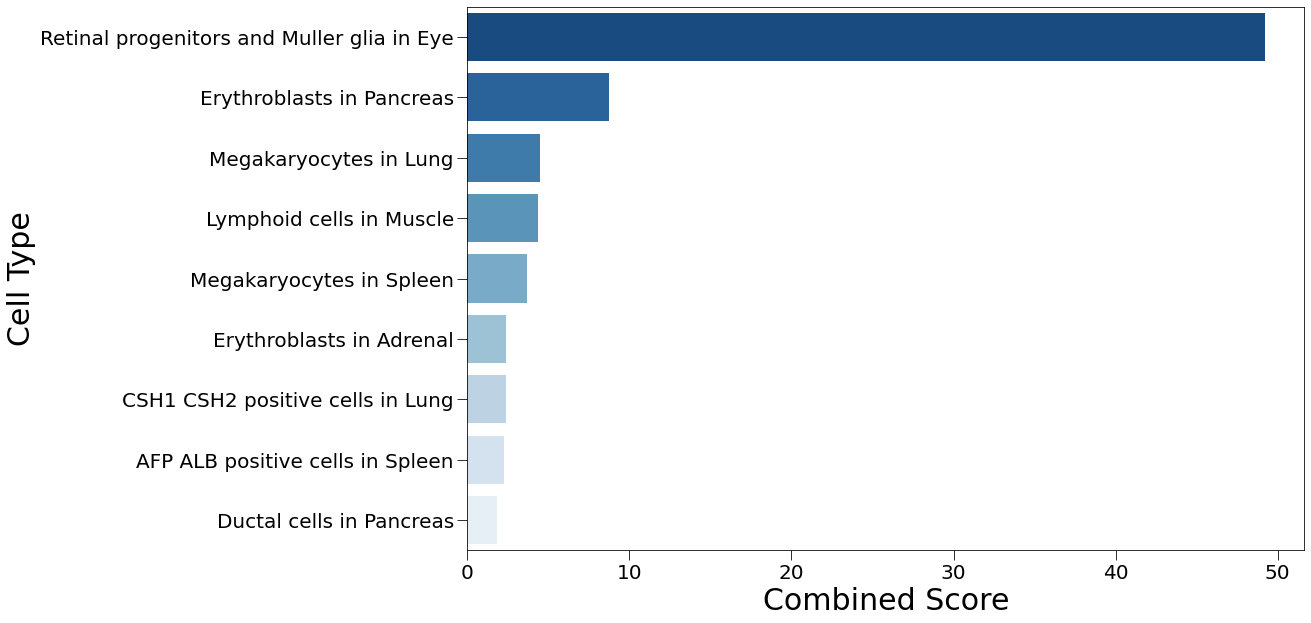

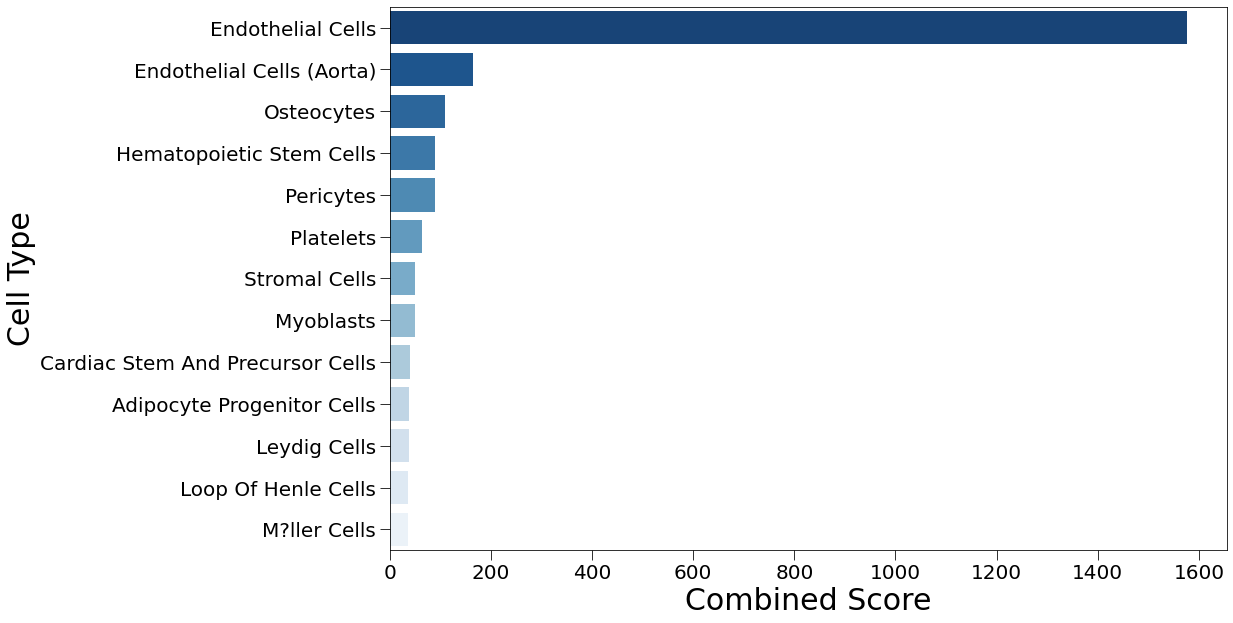

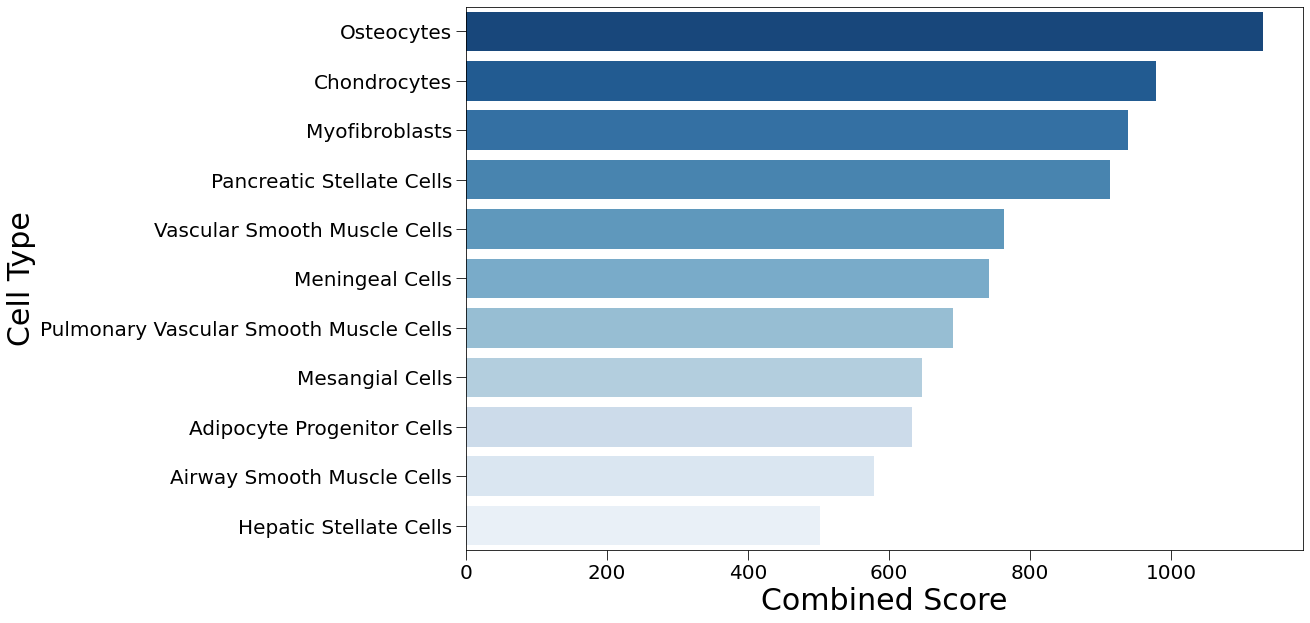

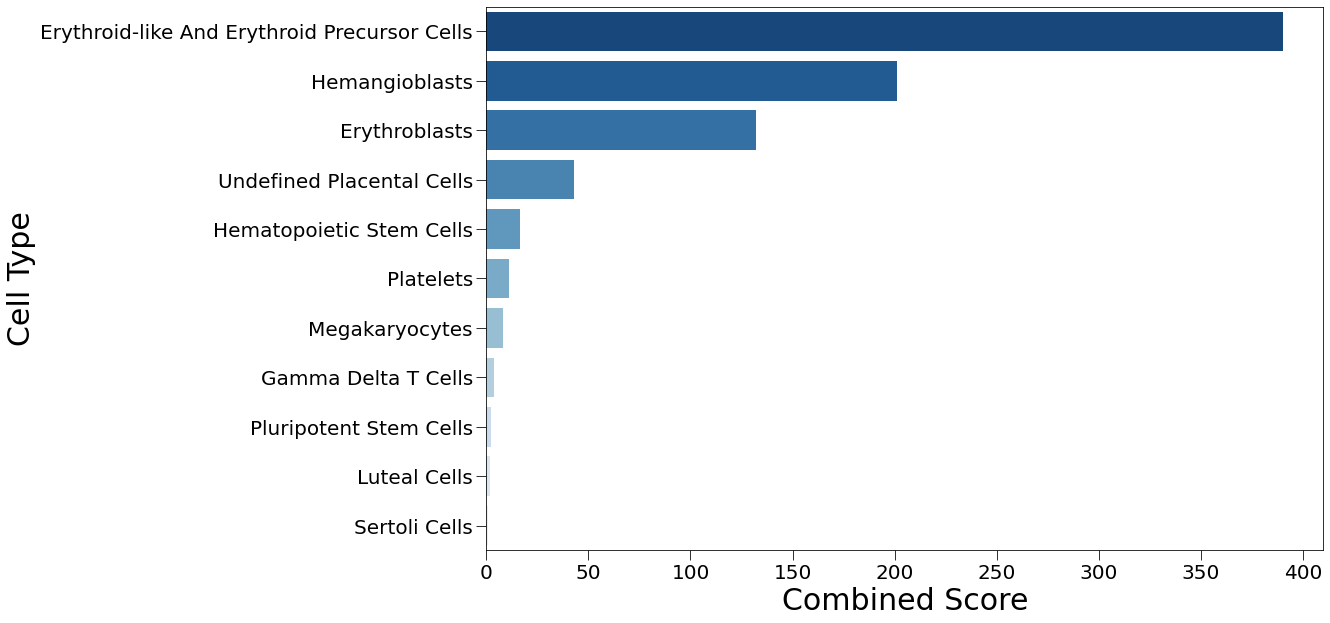

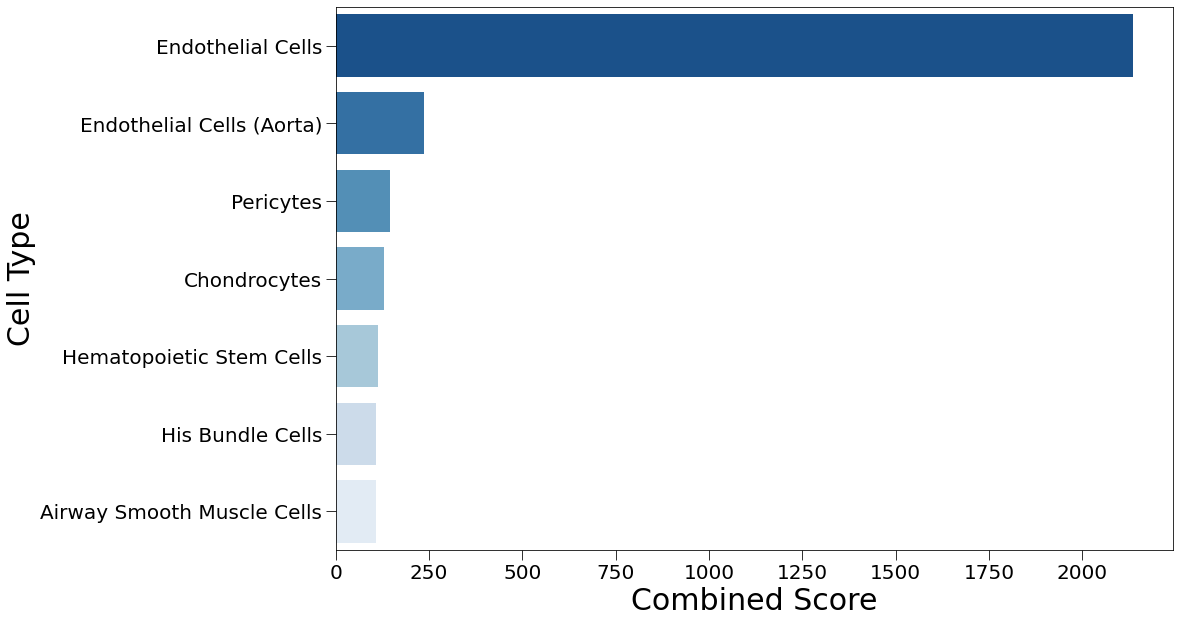

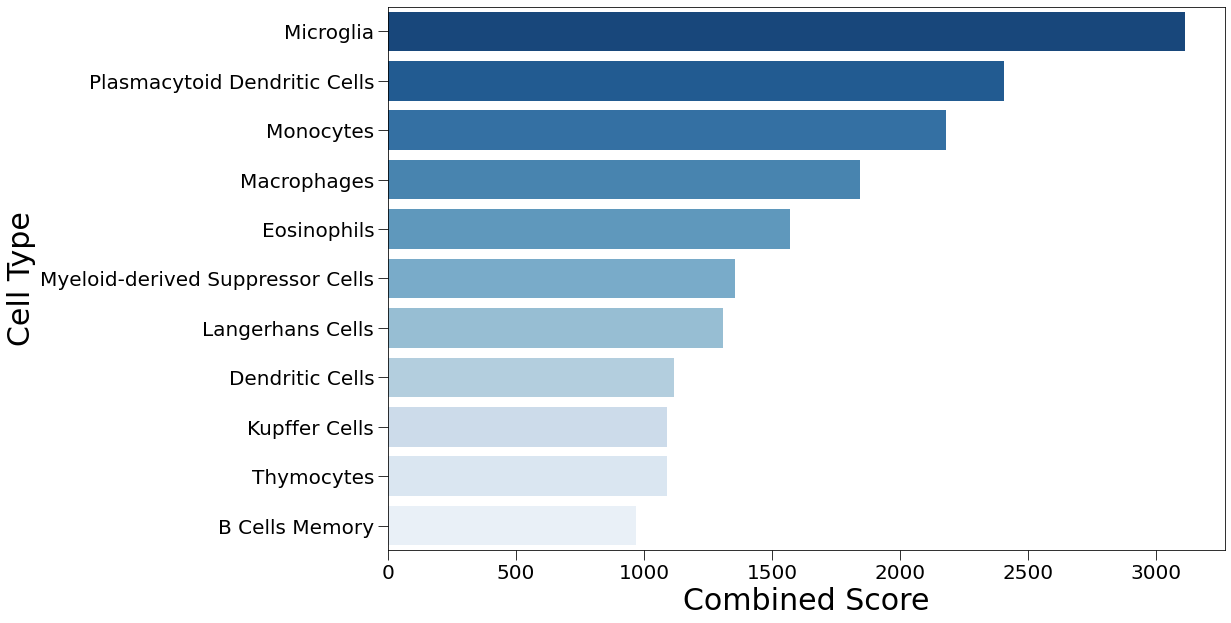

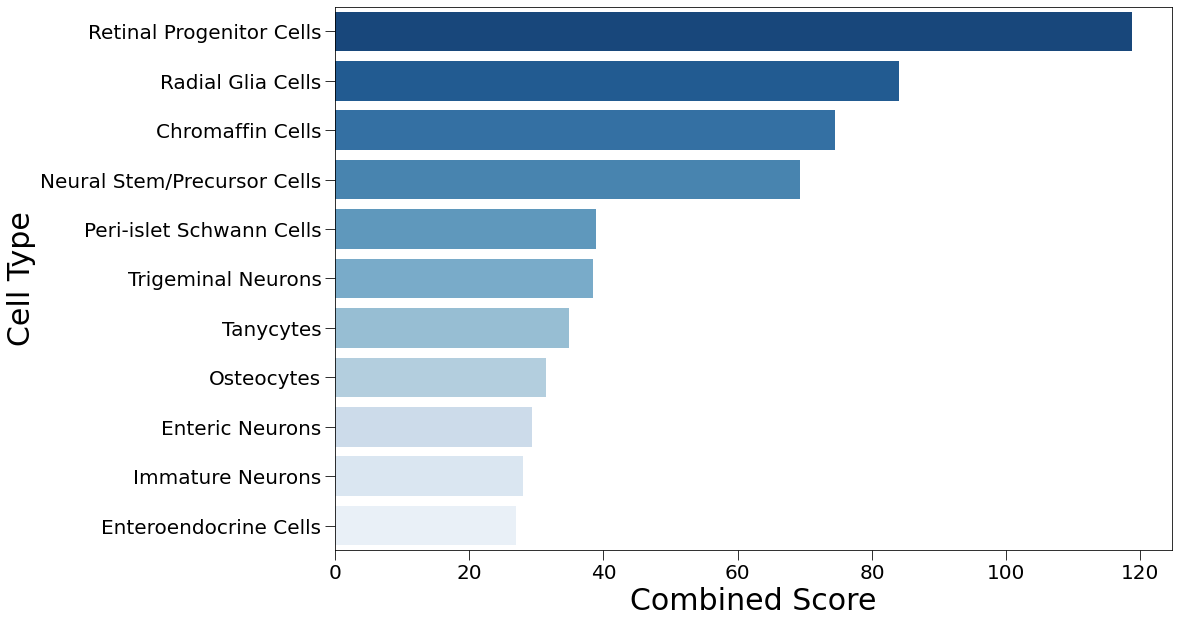

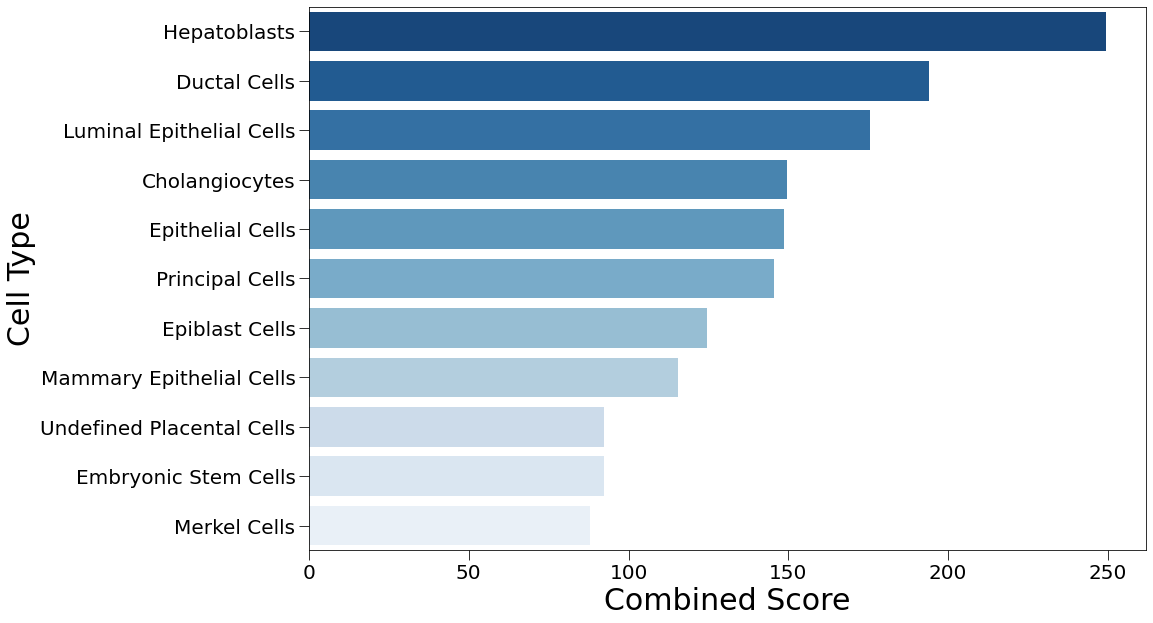

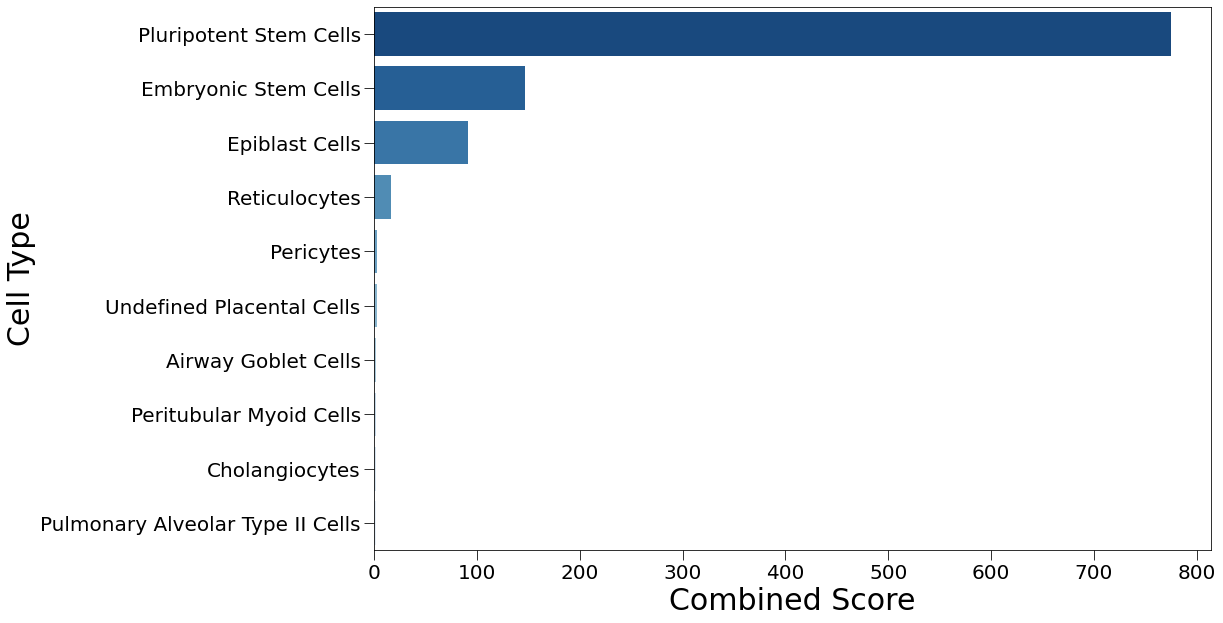

In [24]:
for library in ENRICHR_LIBRARIES:
    for sheet in pd.ExcelFile(DIRECTORY+"Tables/Sorted/Enrich_"+library+".xlsx").sheet_names:
        data = pd.read_excel(DIRECTORY+"Tables/Sorted/Enrich_"+library+".xlsx",sheet_name=sheet)
        data.sort_values("Combined Score",ascending=False,inplace=True)
        
        fig,ax=plt.subplots(figsize=[15,10])
        sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
        sctplot.plot_base(ax,title=library+"_"+sheet,labels=["Combined Score","Cell Type"],legend=False)
        
        fig.savefig(DIRECTORY+"Plots/Sorted/Enrichr/"+library+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")

## Save results

In [25]:
adata.write(DIRECTORY+"Results/QC_sorted.h5ad")

## Projection of the sorted clusters over the Global

In [26]:
adata = scp.read(DIRECTORY+"Results/QC.h5ad")
adatasub = scp.read(DIRECTORY+"Results/QC_sorted.h5ad")

In [27]:
subset = adata.obs.index.isin(adatasub.obs.index)

#Assign clusters from sorted file to global file
clusters = adata.obs[["leiden"]]
clusters.loc[:,"leiden_sorted"] = "-1"
clusters.loc[subset,"leiden_sorted"] = adatasub.obs.loc[:,"leiden"].values

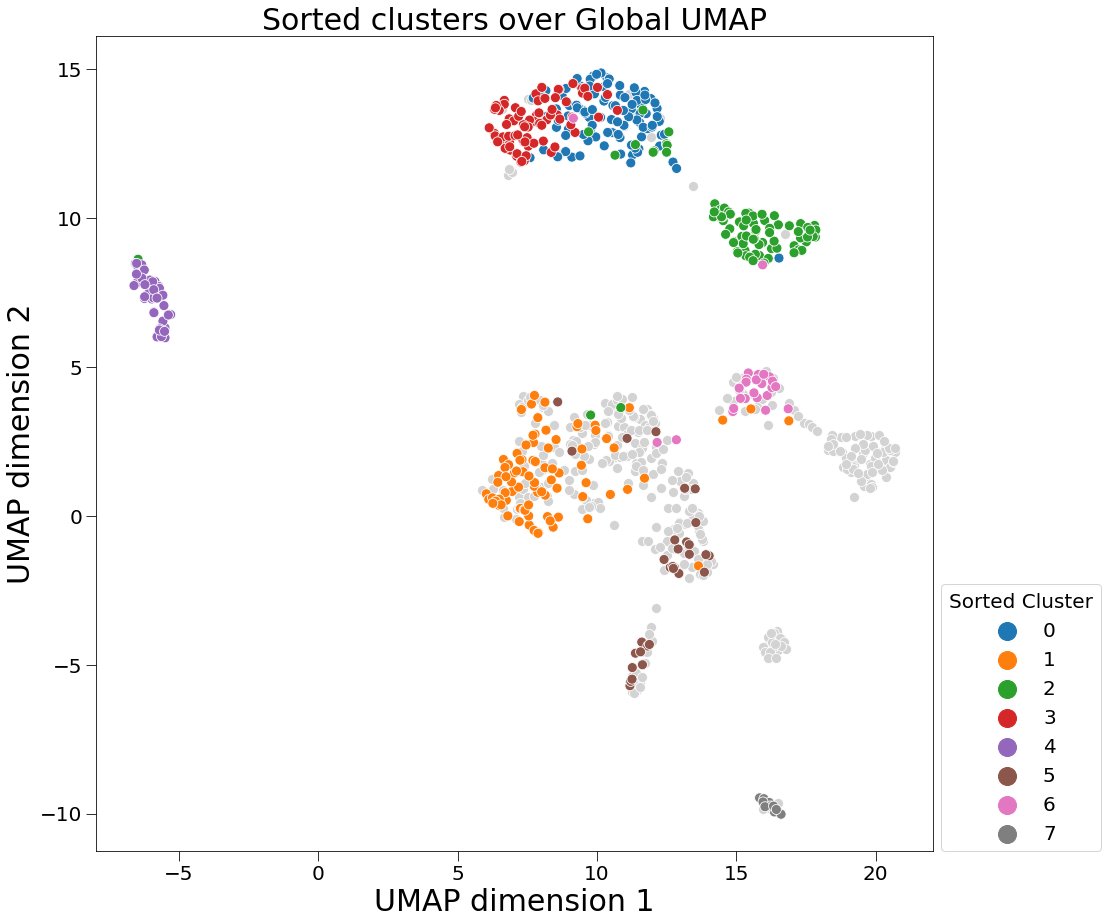

In [28]:
fig,ax = plt.subplots(1,1,figsize=[15,15])
    
#Scatter plots
order = np.argsort(clusters.loc[subset,"leiden_sorted"])
sns.scatterplot(x=adata.obsm[umap][np.invert(subset),0],y=adata.obsm[umap][np.invert(subset),1],color="lightgrey",s=100,ax=ax)
sns.scatterplot(x=adata.obsm[umap][subset,0][order],y=adata.obsm[umap][subset,1][order],hue=clusters.loc[subset,"leiden_sorted"][order],s=100,ax=ax)
sctplot.plot_base(ax,title="Sorted clusters over Global UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,0),legend_title="Sorted Cluster",legend_markerscale=3)
    
#Save figures
fig.savefig(DIRECTORY+"Plots/CA_Clusters_Sorted_Global_UMAP.pdf",bbox_inches="tight",transparent=True)

# Times


In [29]:
adatas = [scp.read(DIRECTORY+"Results/QC_"+stage+".h5ad") for stage in np.sort(adata.obs["Time"].unique())]

## Clustering

For the clustering we perform leiden algorithm. 

In [30]:
for adata in adatas:
    scthyp.leiden(adata,resolutions=np.arange(0.1,5,0.1),
       evaluation_metrics=[evaluation.newman_girvan_modularity])

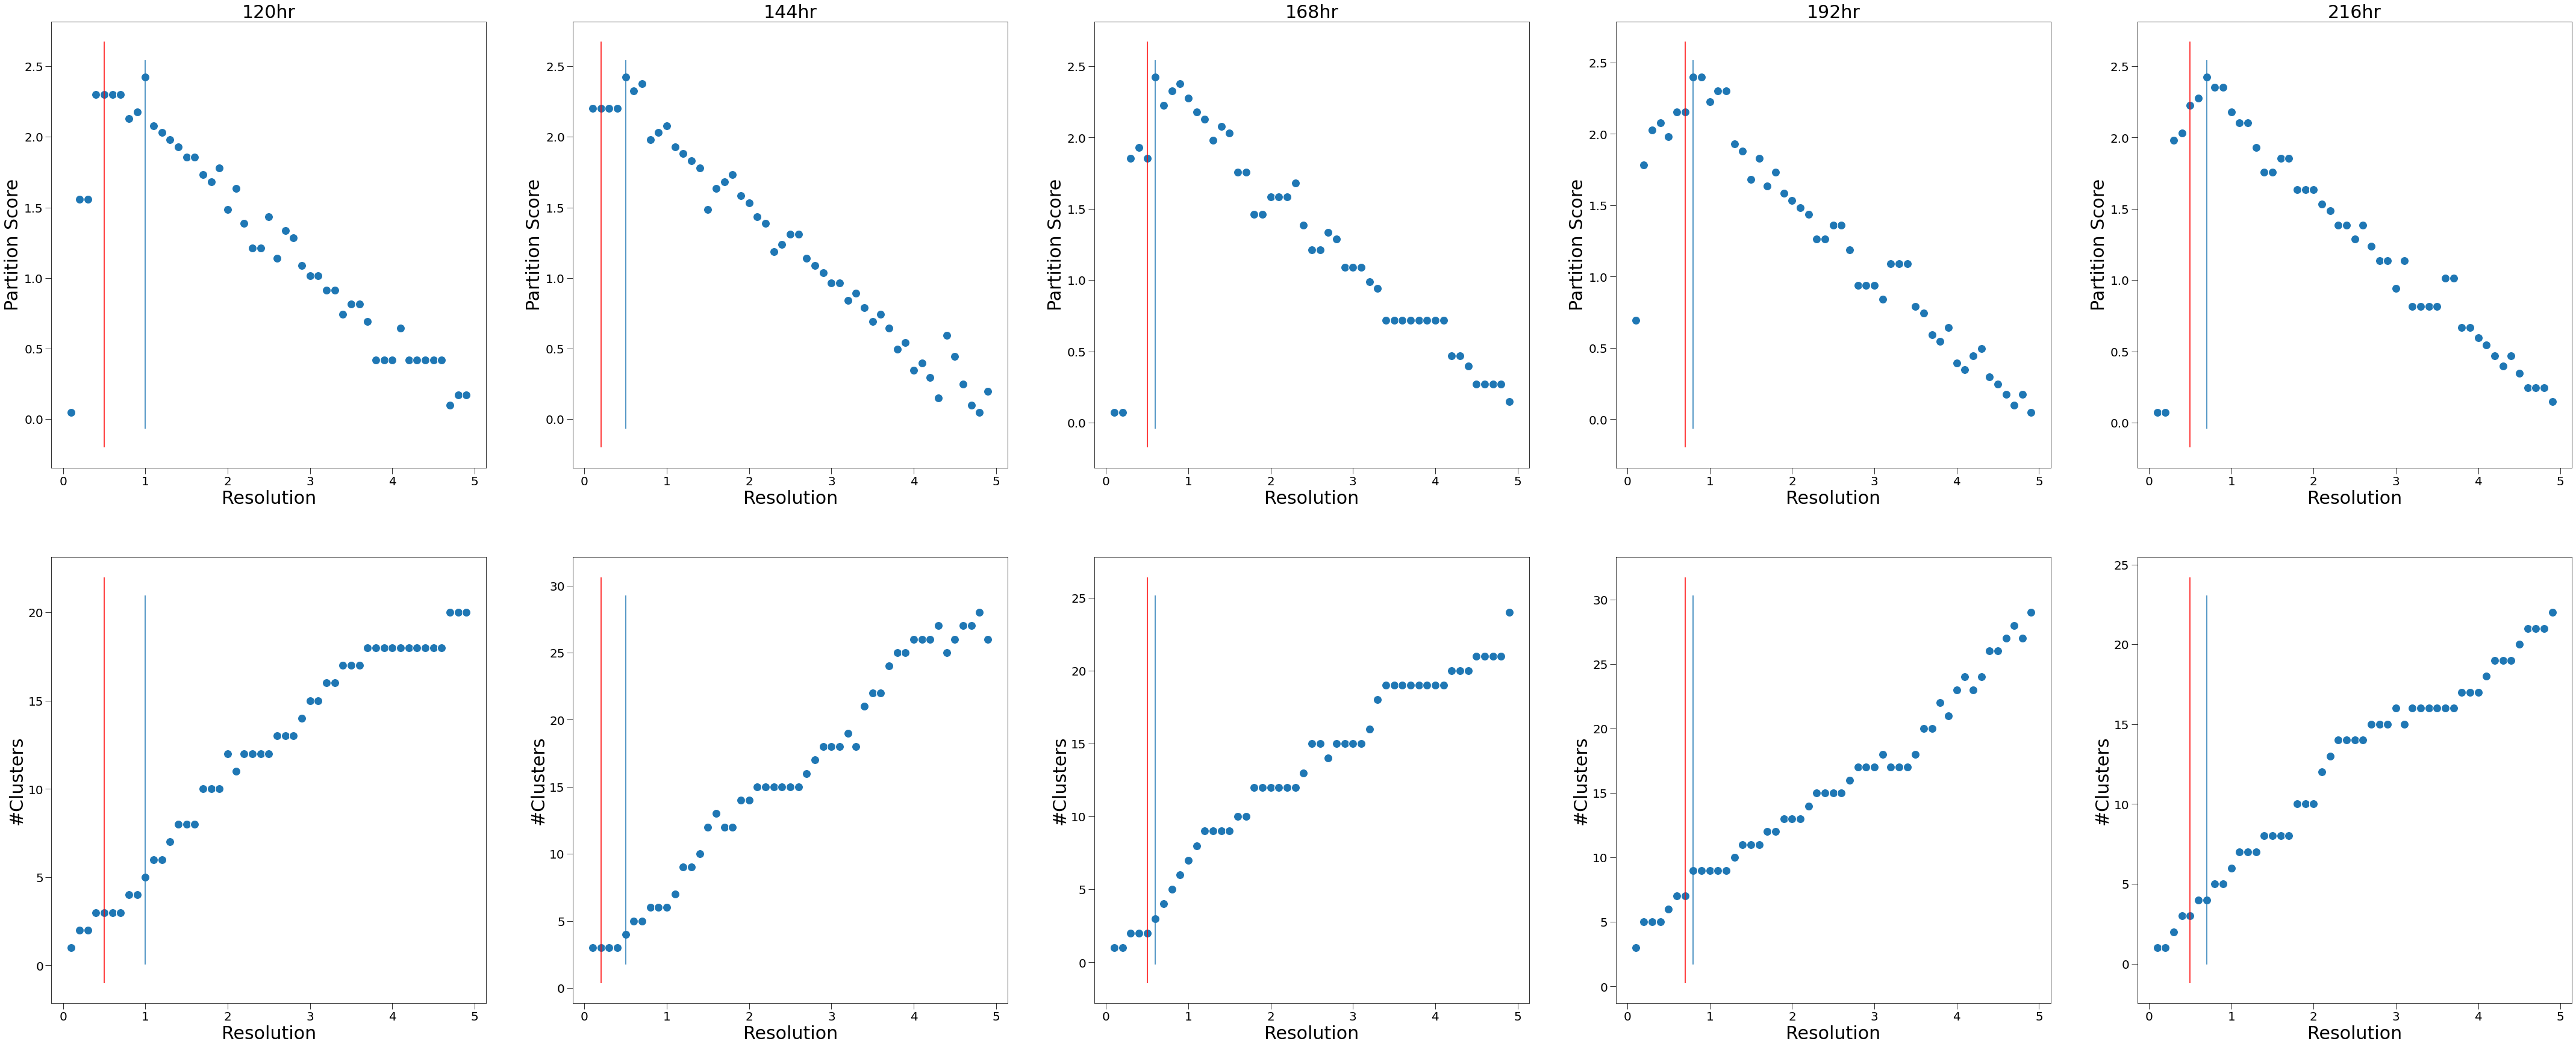

In [31]:
fig,ax = plt.subplots(2,5,figsize=[75,30])

for time,adata in enumerate(adatas):
    sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["scores"],s=200,ax=ax[0,time])
    sctplot.vline(ax[0,time],adata.uns["leiden"]["resolution_best"])
    sctplot.vline(ax[0,time],RESOLUTION_TIMES[time],color="red")
    sctplot.plot_base(ax[0,time],title=adata.obs["Time"].values[0],labels=["Resolution","Partition Score"],legend=False)

    sns.scatterplot(adata.uns["leiden"]["params"],adata.uns["leiden"]["n_clusters"],s=200,ax=ax[1,time])
    sctplot.vline(ax[1,time],adata.uns["leiden"]["resolution_best"])
    sctplot.vline(ax[1,time],RESOLUTION_TIMES[time],color="red")
    sctplot.plot_base(ax[1,time],labels=["Resolution","#Clusters"],legend=False)

fig.savefig(DIRECTORY+"Plots/Times/CA_Clustering_Selection.pdf",bbox_inches="tight",transparent=True)

In [32]:
#Clustering global
for time,adata in enumerate(adatas):
    scp.tl.leiden(adata,resolution=RESOLUTION_TIMES[time])

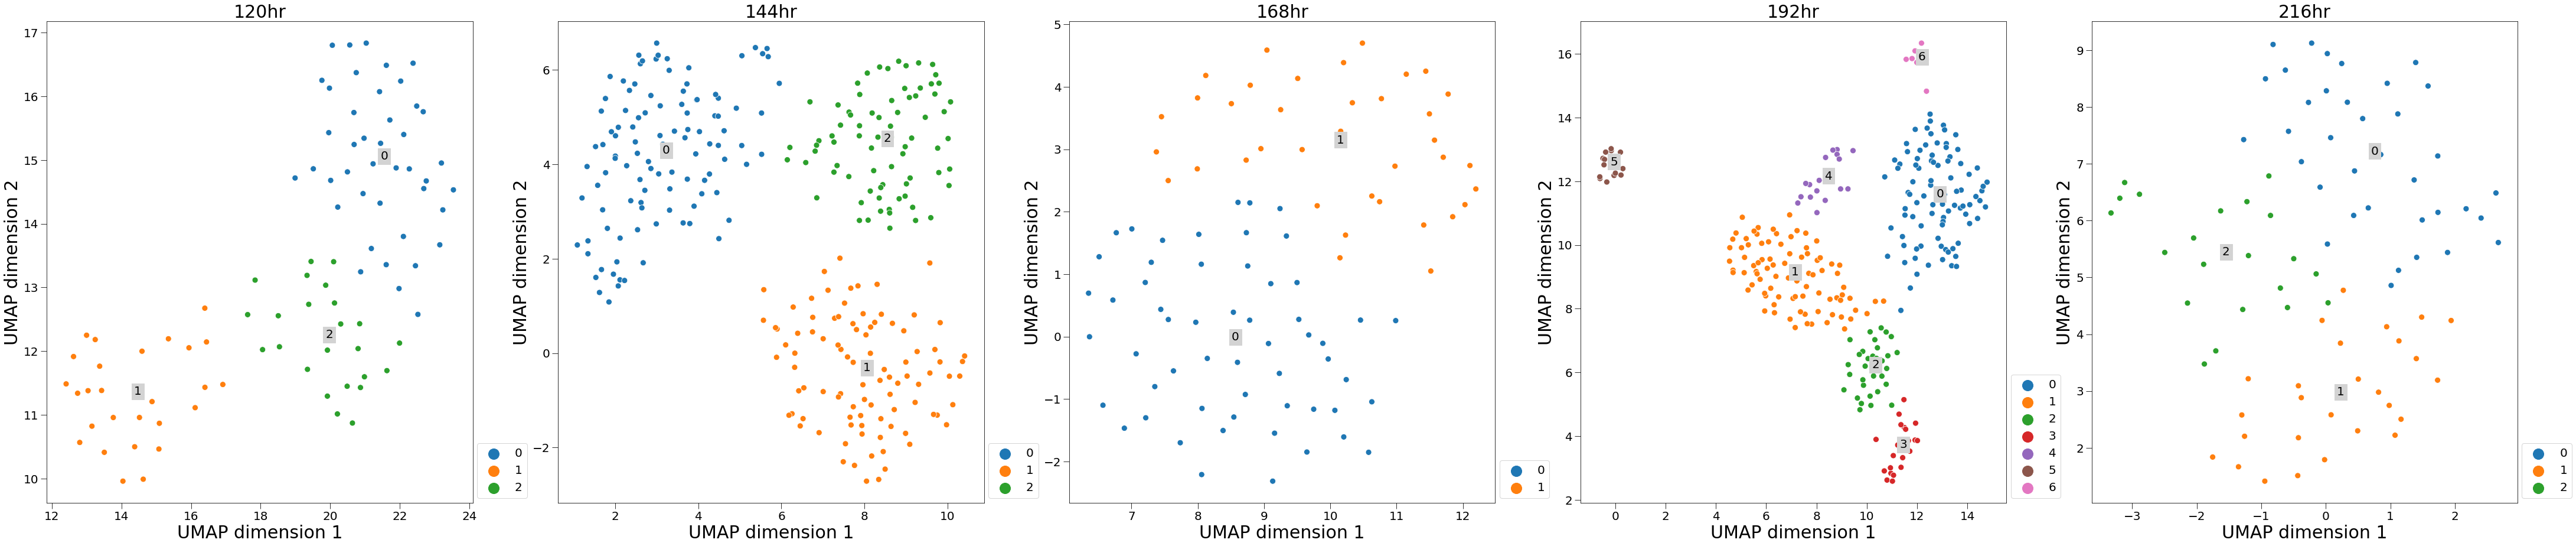

In [33]:
fig,ax = plt.subplots(1,5,figsize=[75,15])

for time,adata in enumerate(adatas):
    pca = "X_pca"
    umap = "X_umap"

    #Scatter plots
    sns.scatterplot(x=adata.obsm[umap][:,0],y=adata.obsm[umap][:,1],hue=adata.obs["leiden"],s=100,ax=ax[time])
    sctplot.plot_base(ax[time],title=adata.obs["Time"].values[0],labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,0.01),legend_markerscale=3)
    sctplot.plot_scatter_labels(ax[time],adata,"X_umap","leiden",fontsize=20,backgroundcolor="lightgrey")
    
#Save figures
fig.savefig(DIRECTORY+"Plots/Times/CA_UMAP_clusters.pdf",bbox_inches="tight",transparent=True)

## Contribution of the sorting methods to the clusters

We visualize the proportion of cells that contribute to each cluster, as well as the proportion of cells that contribute depending on the sorting condition from which we have generated the data.DIRECTORY

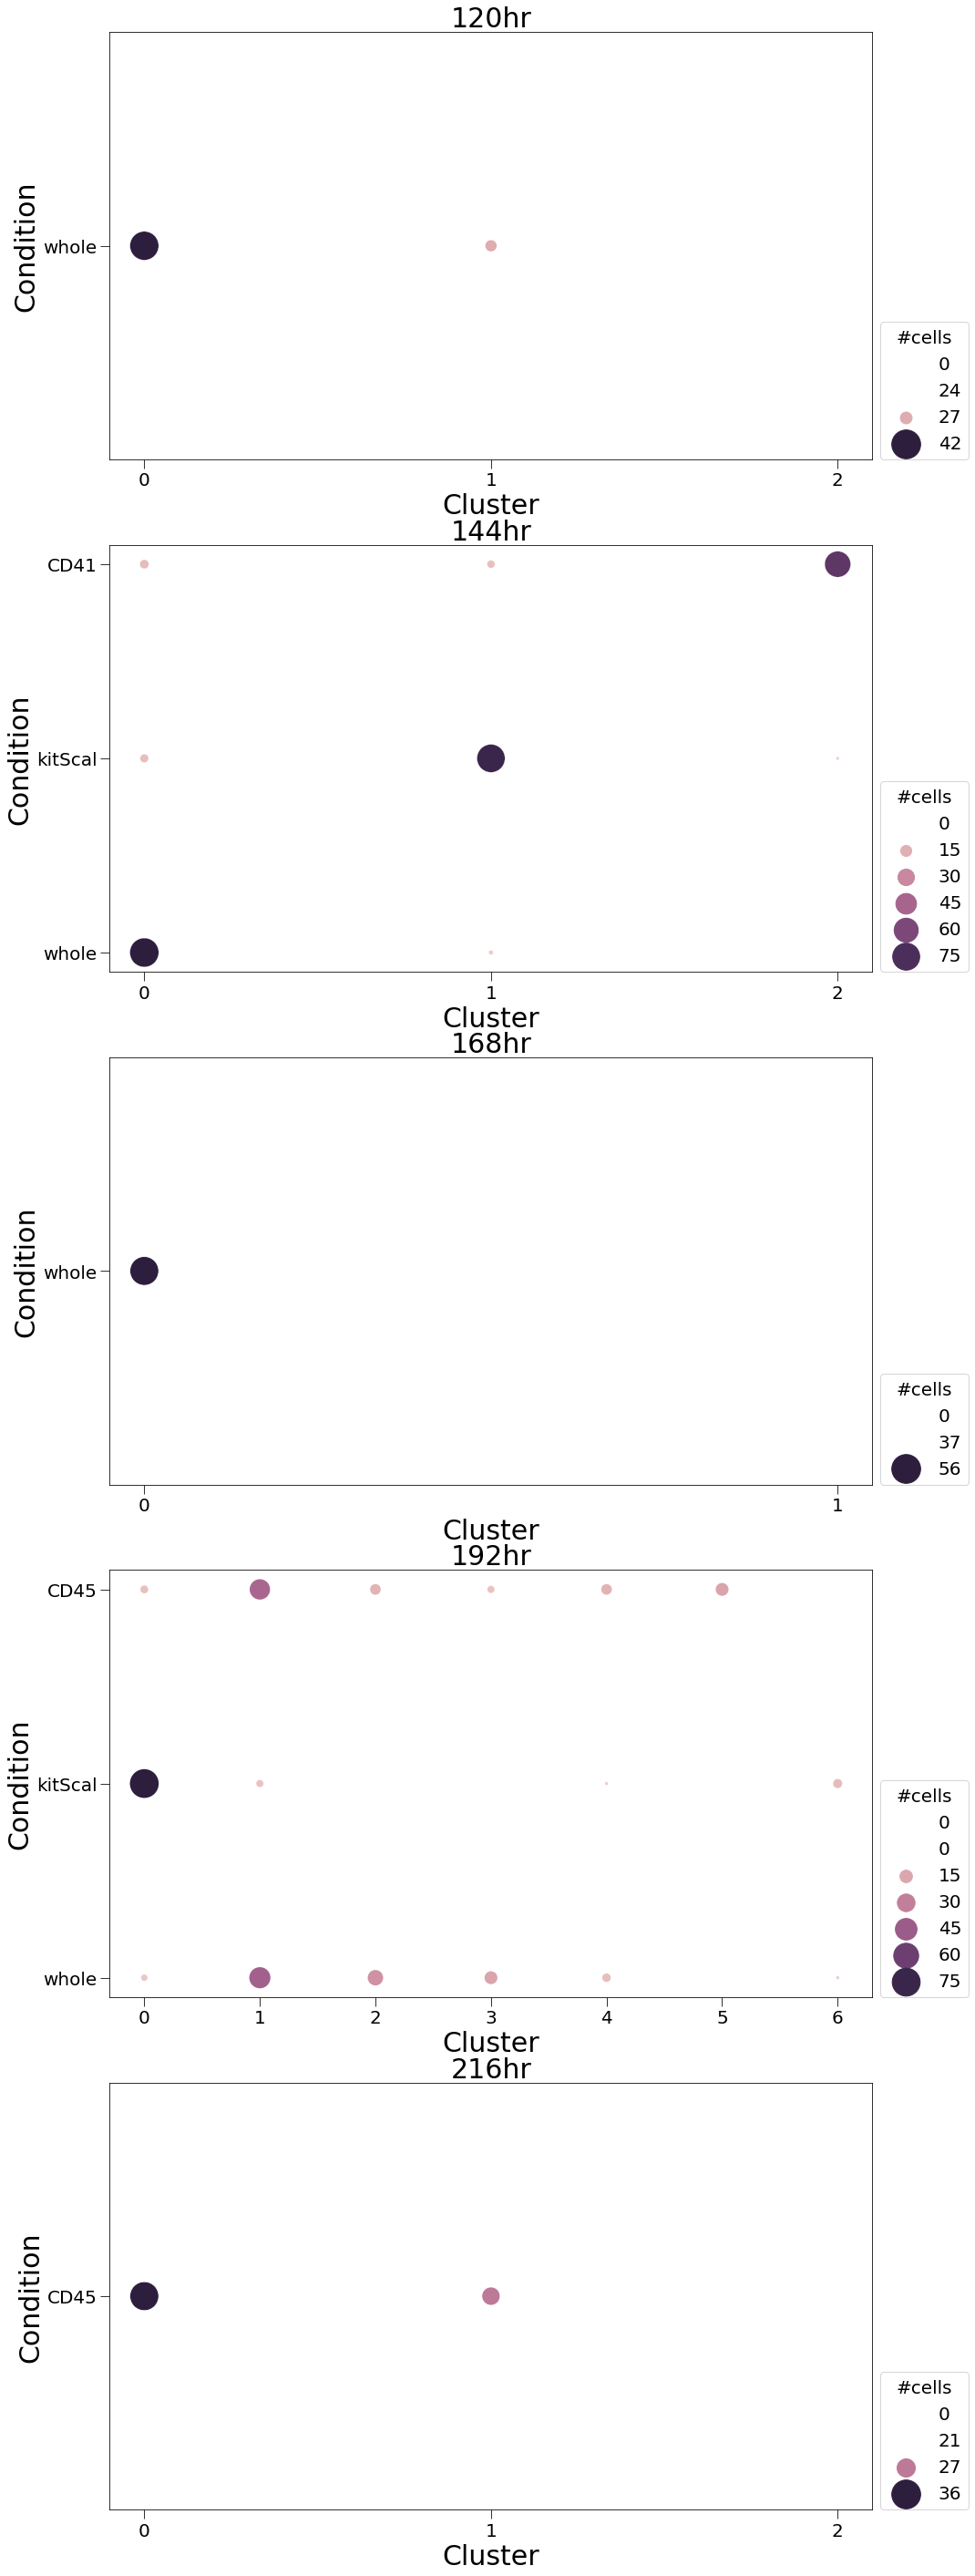

In [34]:
fig,ax = plt.subplots(5,1,figsize=[15,50])

for time,adata in enumerate(adatas):

    #Make cluster contributions
    data = adata.obs.groupby(by=["leiden","Condition"]).count()
    data2 = data.unstack().loc[:,"Cell"].stack().reset_index()
    sns.scatterplot(data=data2,x="leiden",y="Condition",hue=0,size=0,sizes=(0, 1000),ax=ax[time])
    sctplot.plot_base(ax[time],title=adata.obs["Time"].values[0],labels=["Cluster","Condition"],legend_title="#cells",legend_pos=(1.01,0.))

fig.savefig(DIRECTORY+"Plots/Times/CA_Condition_contribution_clusters.pdf",bbox_inches="tight",transparent=True)

## DE expression

In [35]:
for time,adata in enumerate(adatas):
    scp.tl.rank_genes_groups(adata,groupby="leiden",method=DE_TEST,use_raw=False)
    scttools.rank_genes_to_excel(adata,"gene_name",DIRECTORY+"Tables/Times/Annotation"+DE_TEST+"_"+adata.obs["Time"].values[0]+".xlsx",DE_GENES)

##  Relevant genes expression

In order to help the annotation, we plot the mean expression of the relevant genes separated by clusters.

In [36]:
genes = pd.read_excel("../Shared_data/Marker_genes_scRNAseq_Gx.xlsx",header=None,engine="openpyxl").values[:,0]

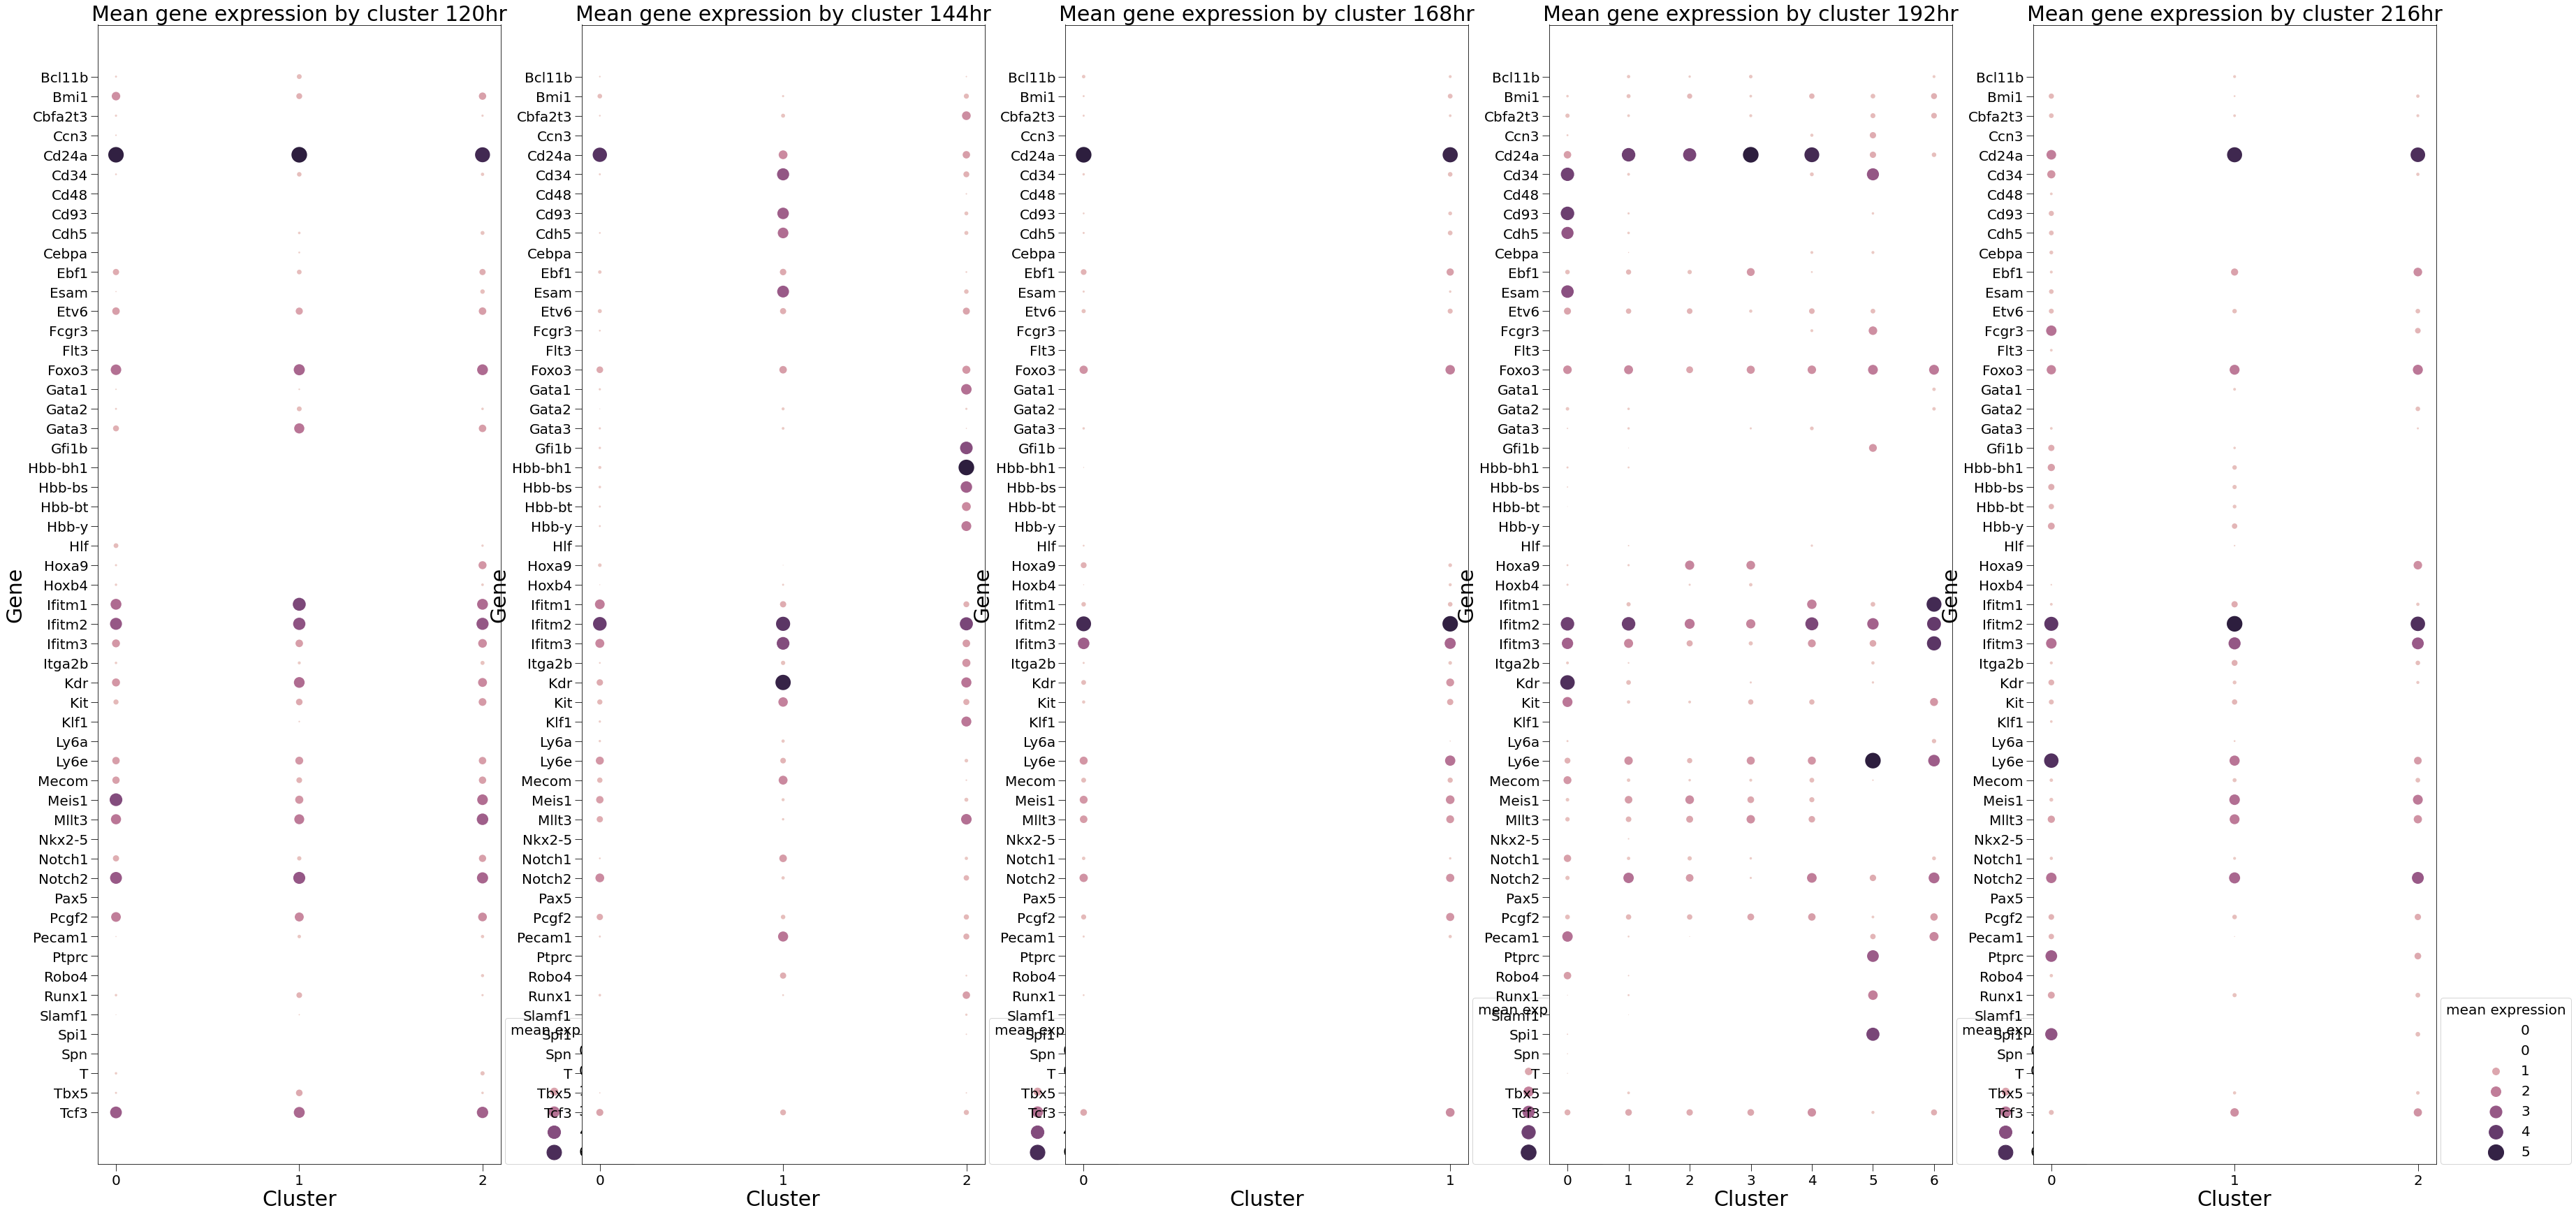

In [37]:
fig,ax = plt.subplots(1,5,figsize=[60,30])

for time,adata in enumerate(adatas):
    data = pd.DataFrame()
    data["cluster"] = adata.obs["leiden"]
    for gene in np.sort(genes):
        if np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense()).size != 0:
            data[gene] = np.array(adata[:,adata.var.loc[:,"gene_name"]==gene].X.todense())[:,0]

    data = data.groupby(["cluster"]).mean().stack().reset_index()

    sns.scatterplot(data=data,y="level_1",x="cluster",hue=0,size=0,sizes=(0,500),ax=ax[time])
    sctplot.plot_base(ax[time],title="Mean gene expression by cluster "+adata.obs.loc[:,"Time"].values[0],labels=["Cluster","Gene"],legend_pos=(1.01,0.),legend_title="mean expression")
    
fig.savefig(DIRECTORY+"Plots/Times/AC_expression_relevant_genes_clusters.pdf",bbox_inches="tight",transparent=True)

## Enrichr

In [38]:
for library in ENRICHR_LIBRARIES:
    for time,adata in enumerate(adatas):
        scttools.enrichr_to_excel(adata,library,DIRECTORY+"Tables/Times/Enrich_"+library+"_"+adata.obs.loc[:,"Time"].values[0]+".xlsx")

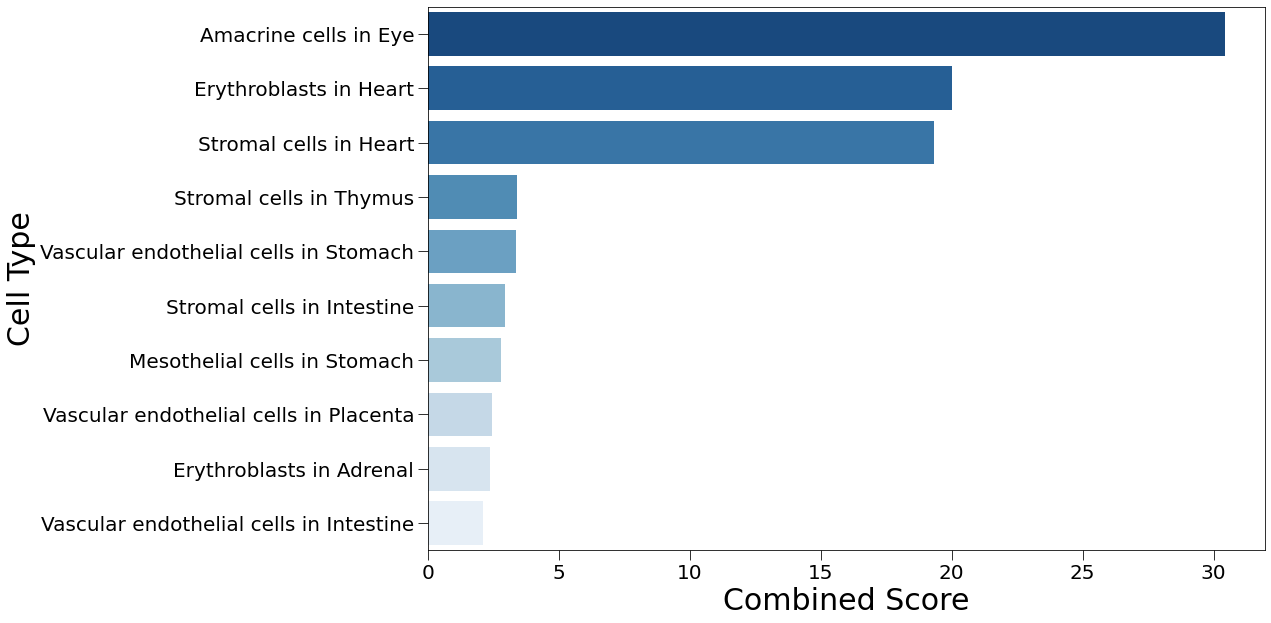

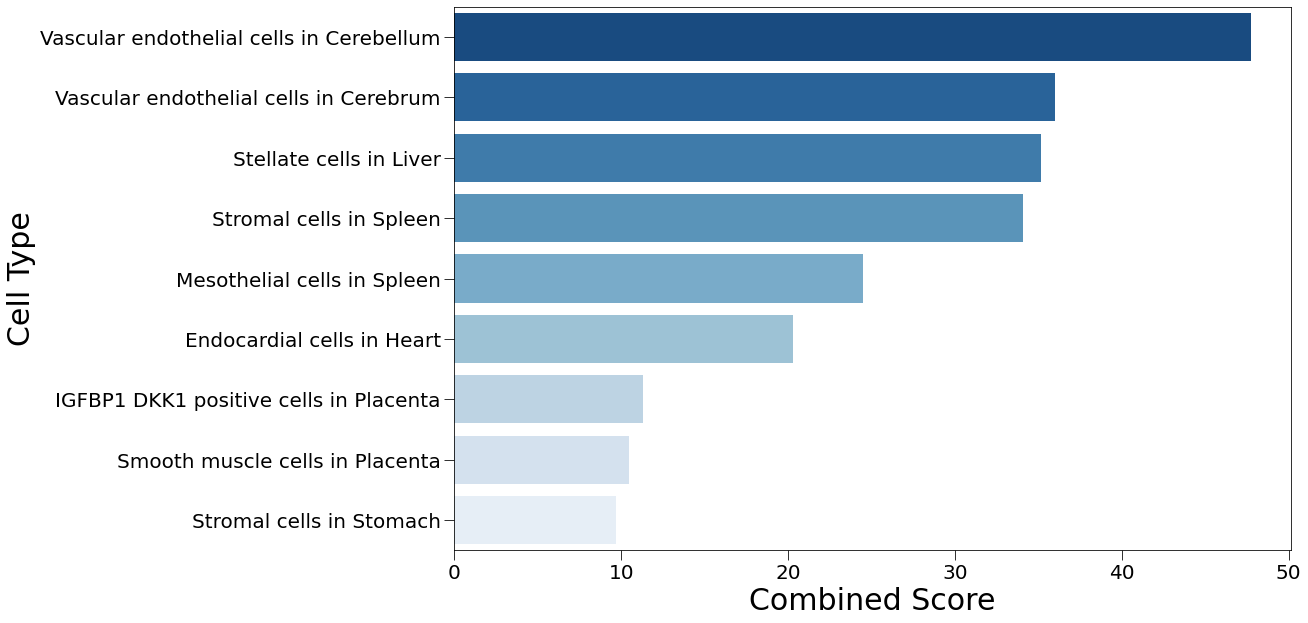

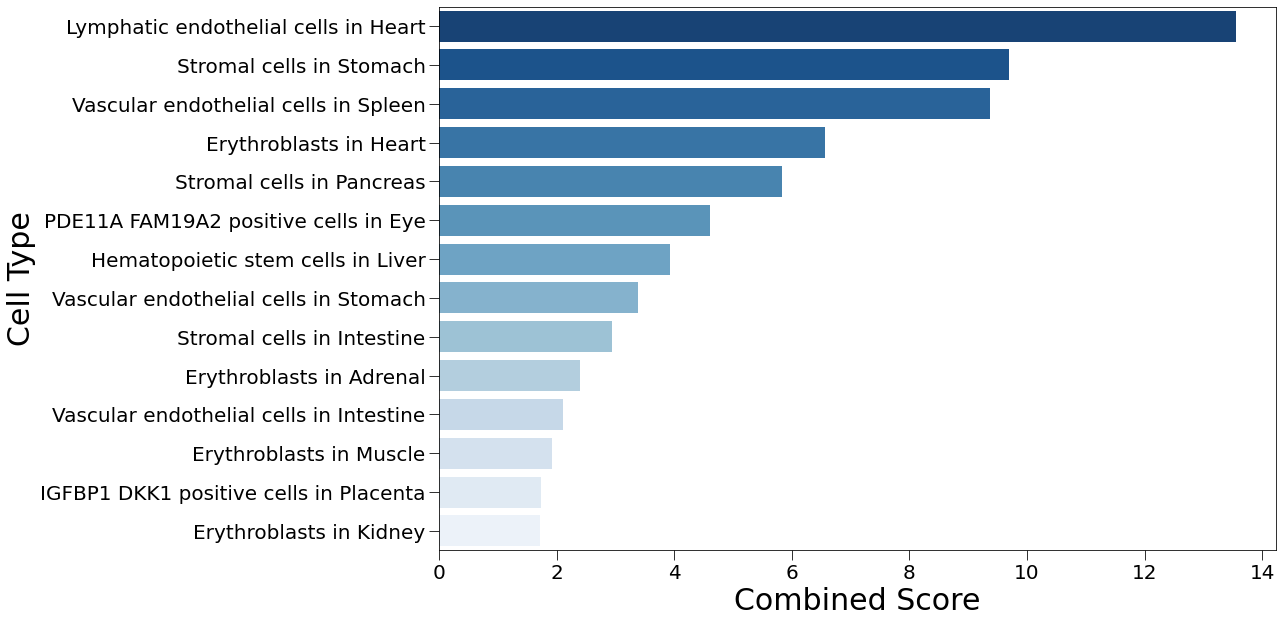

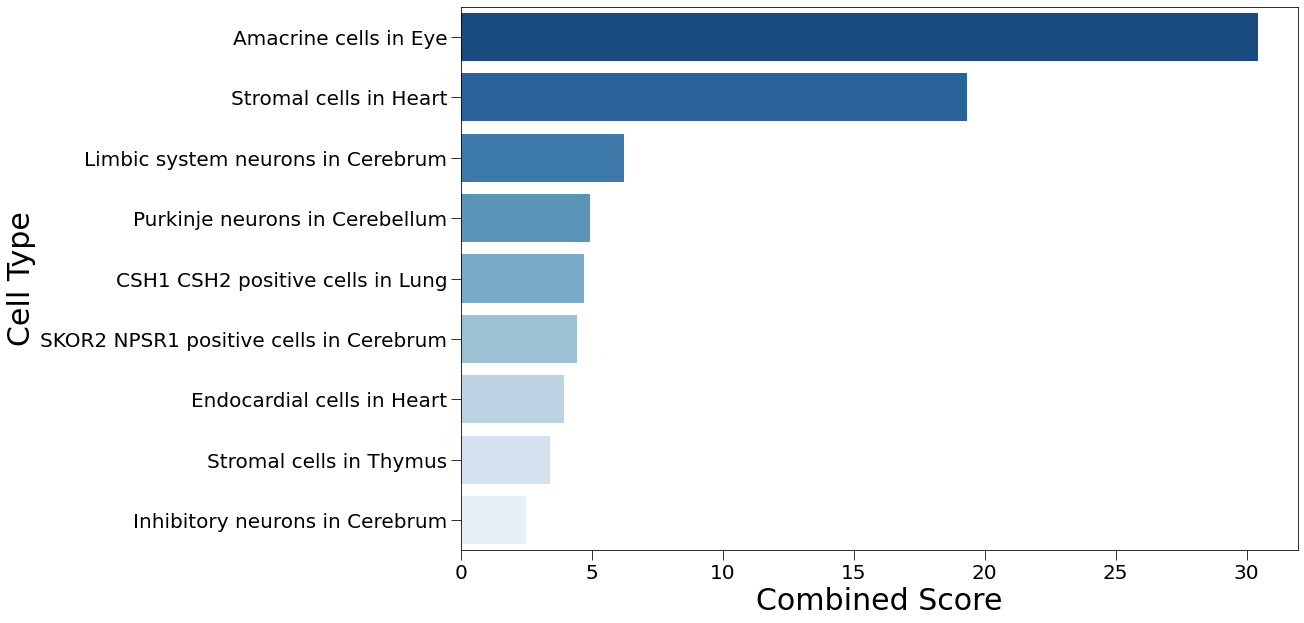

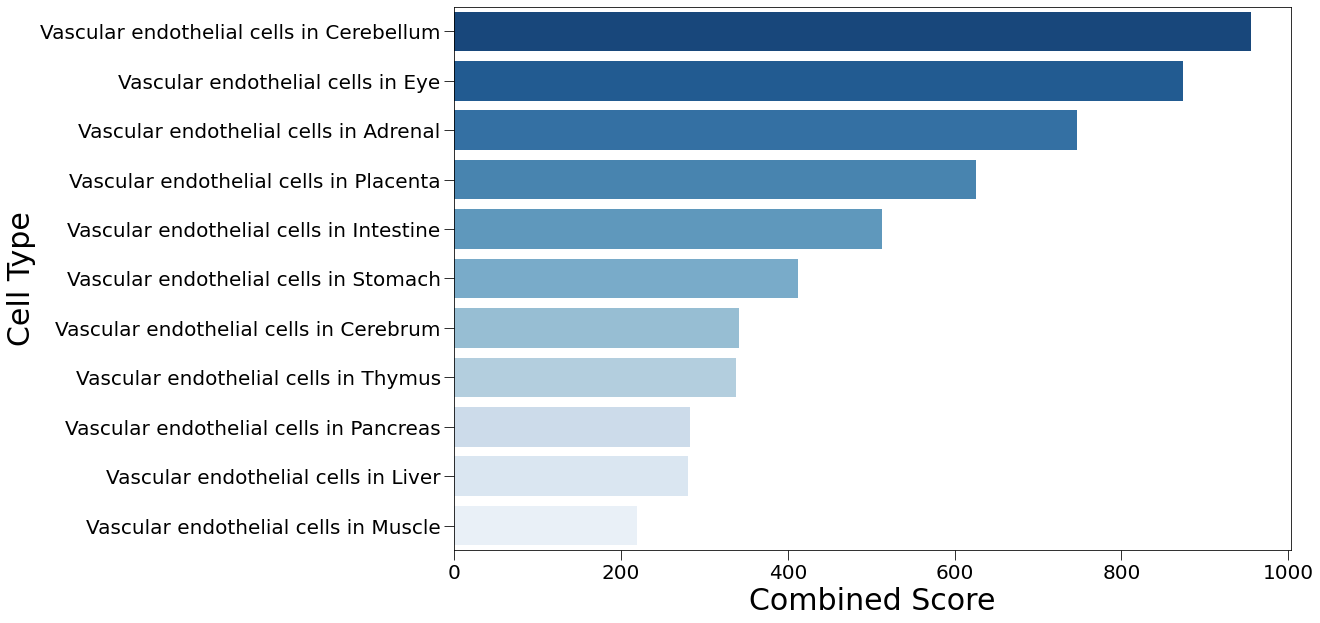

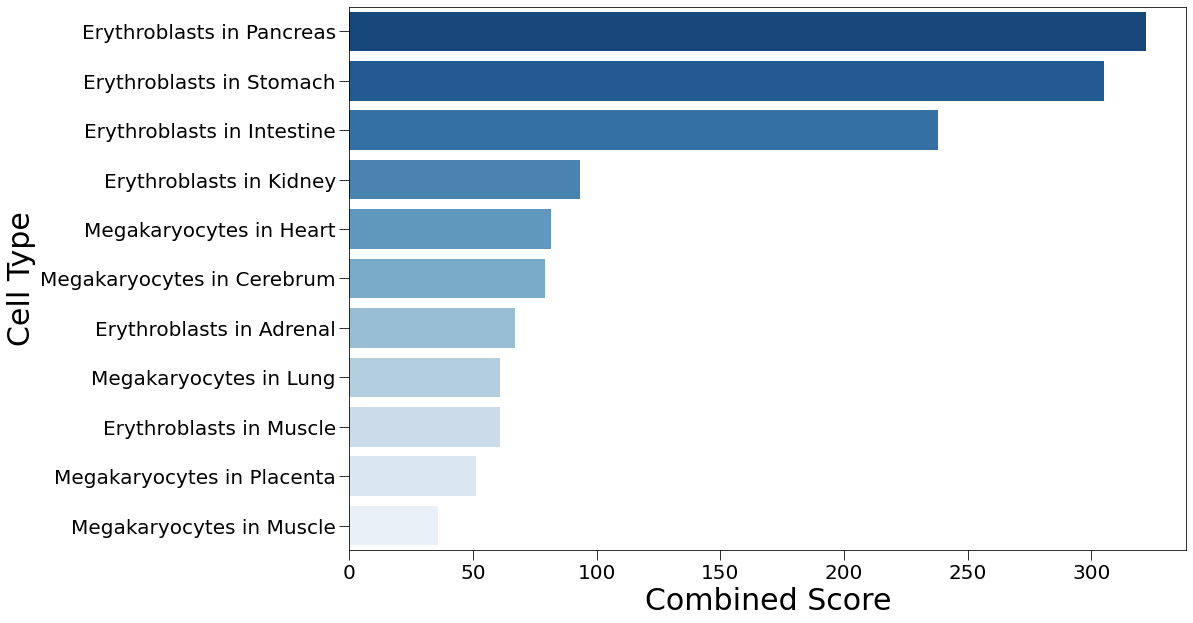

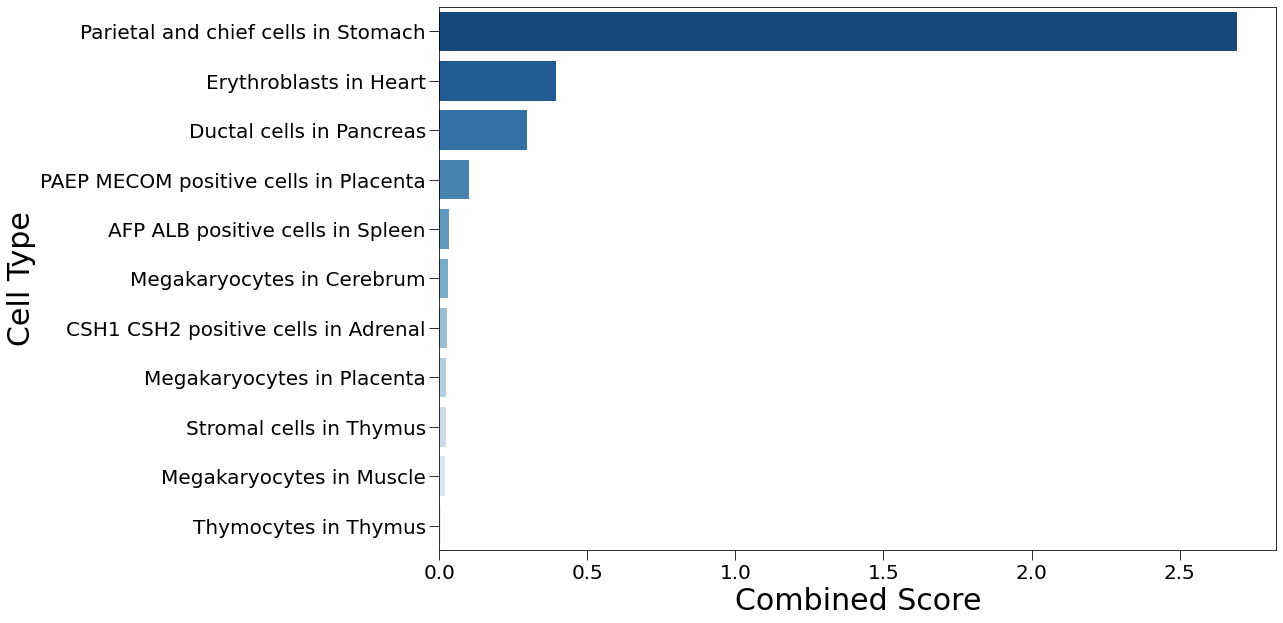

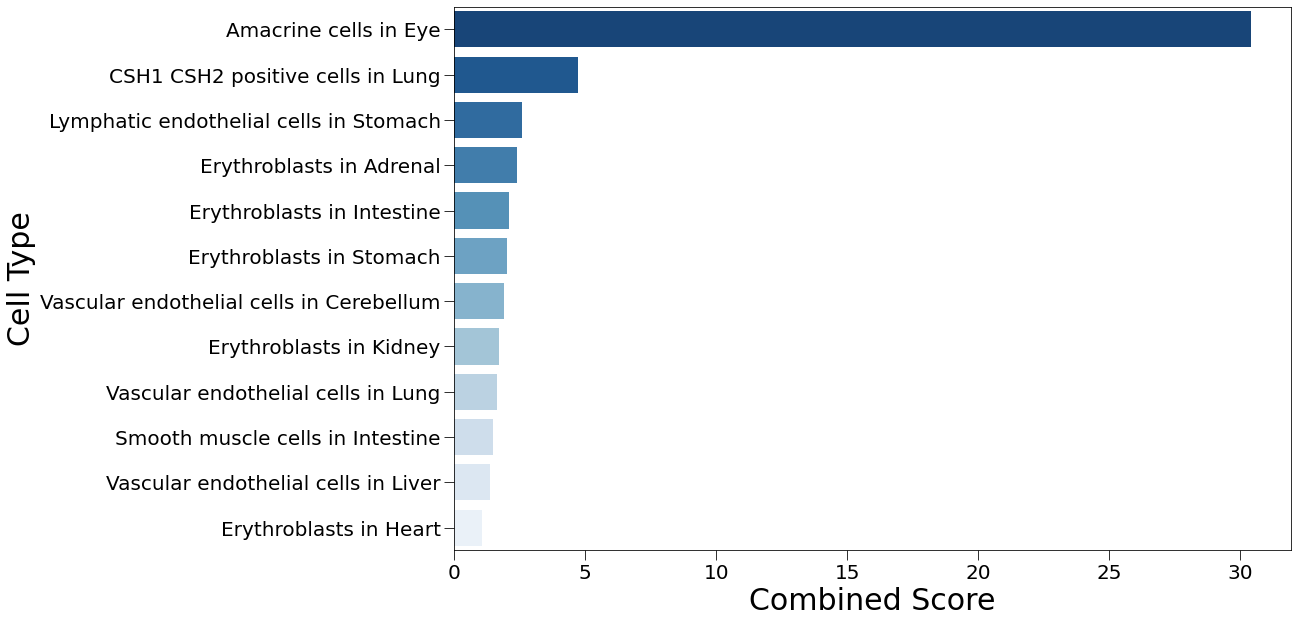

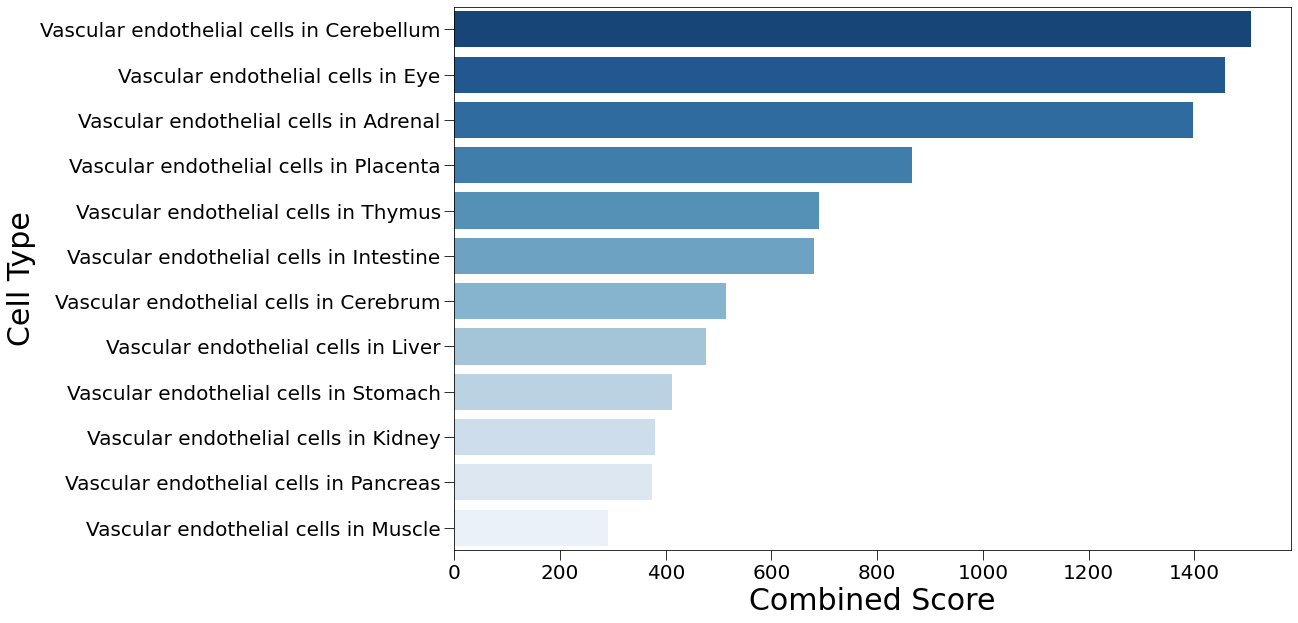

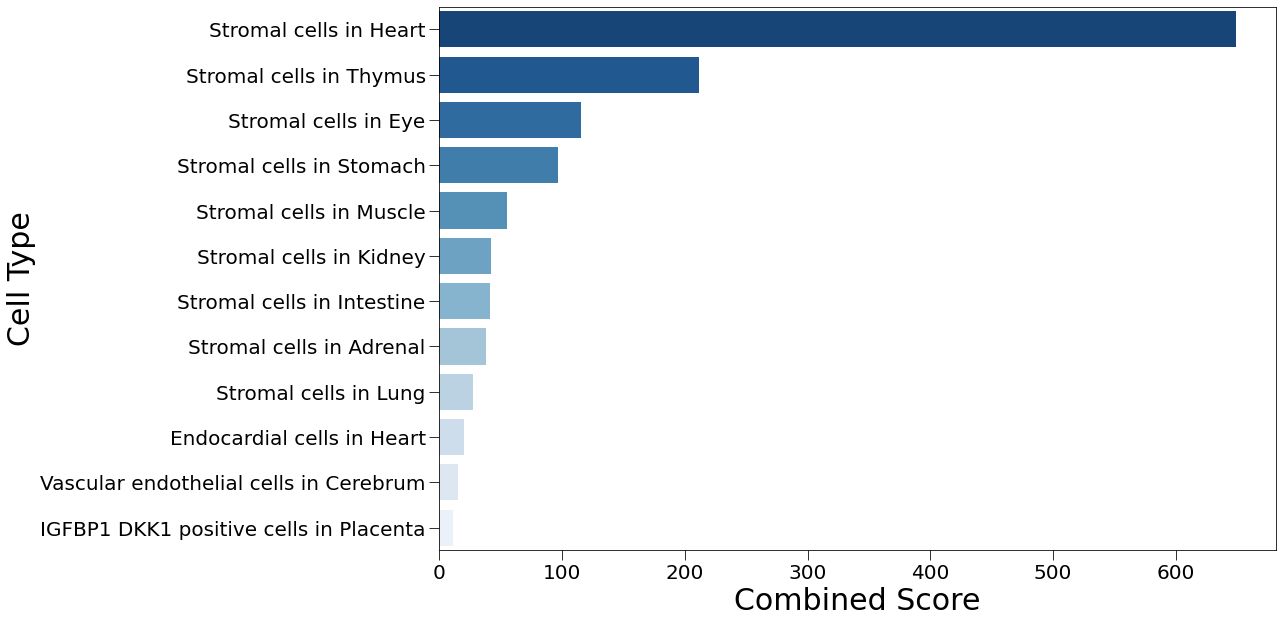

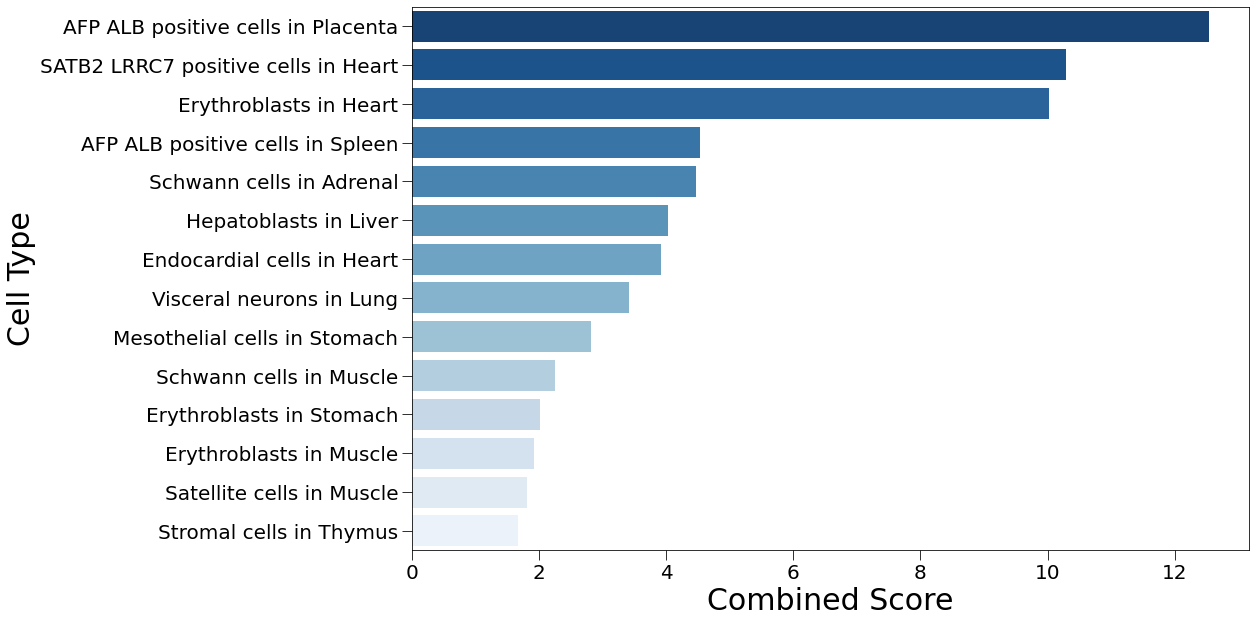

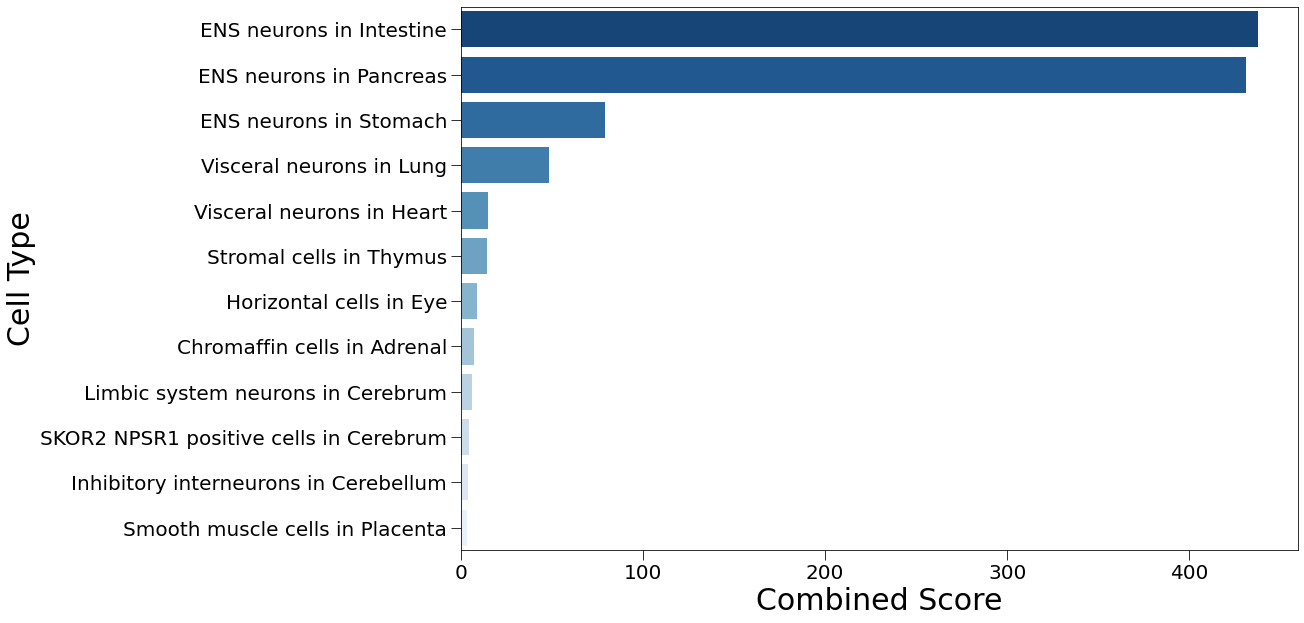

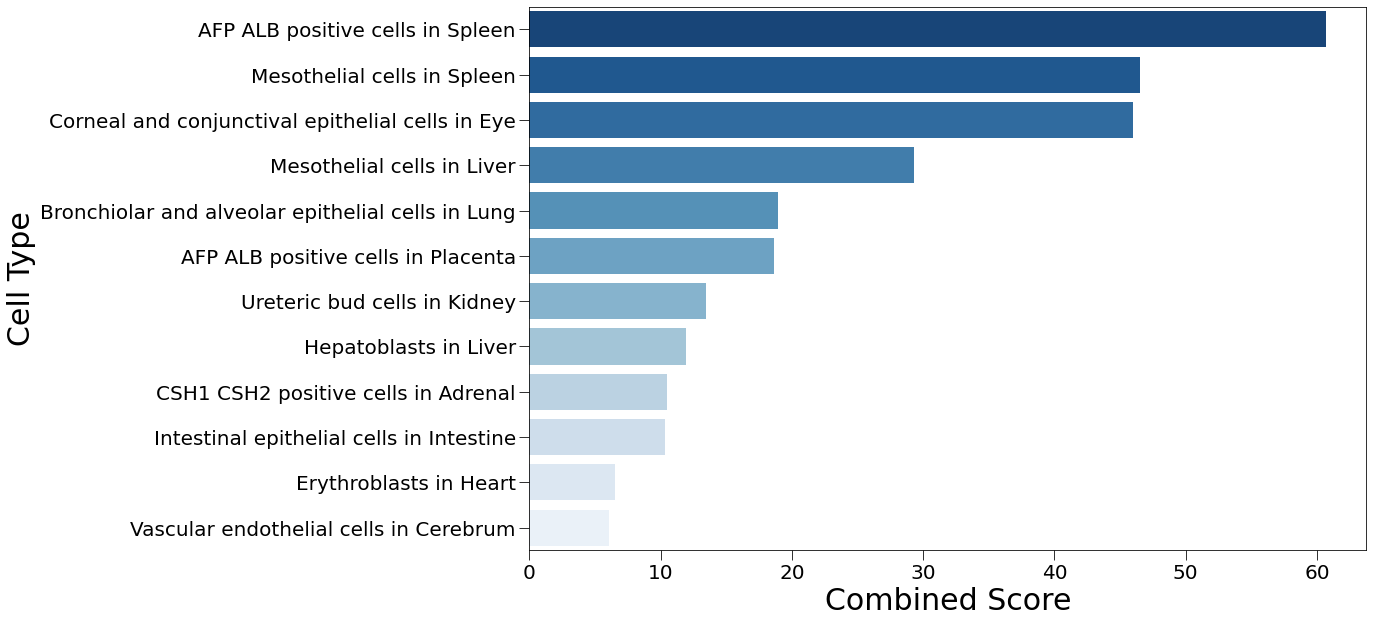

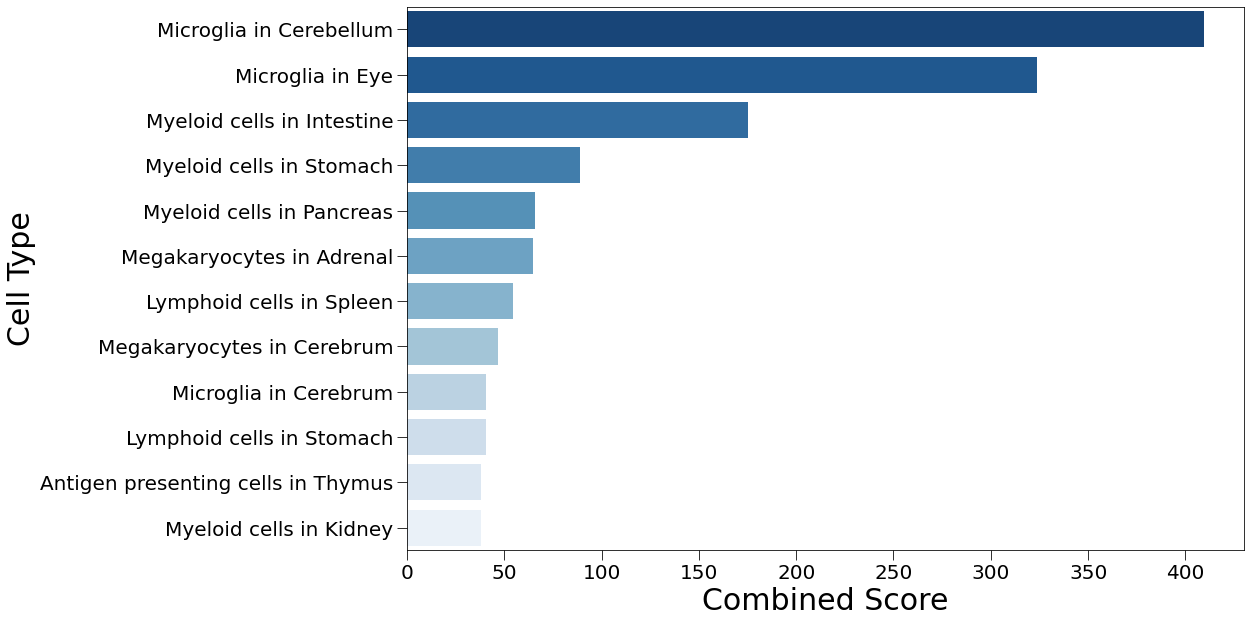

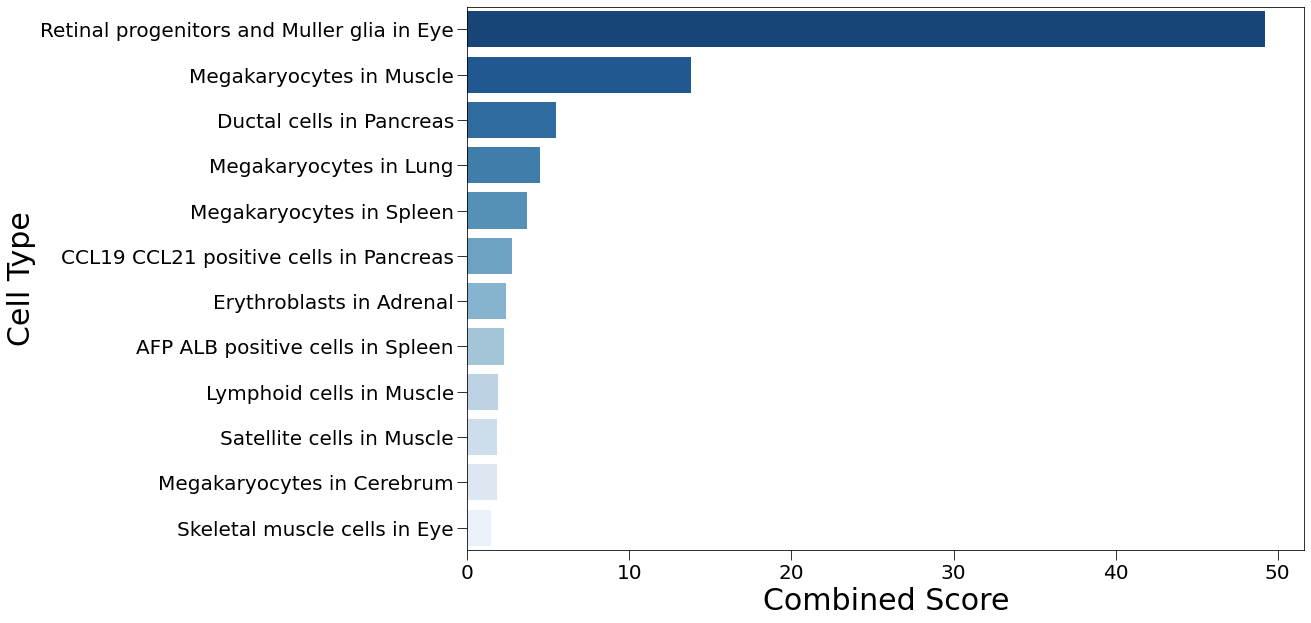

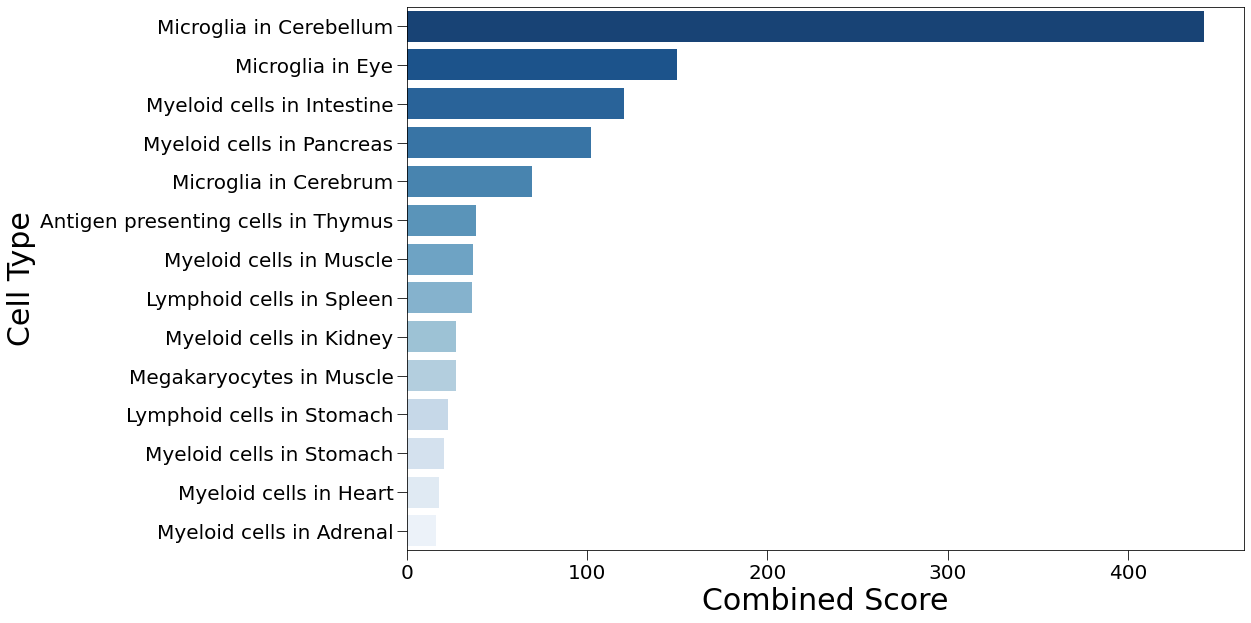

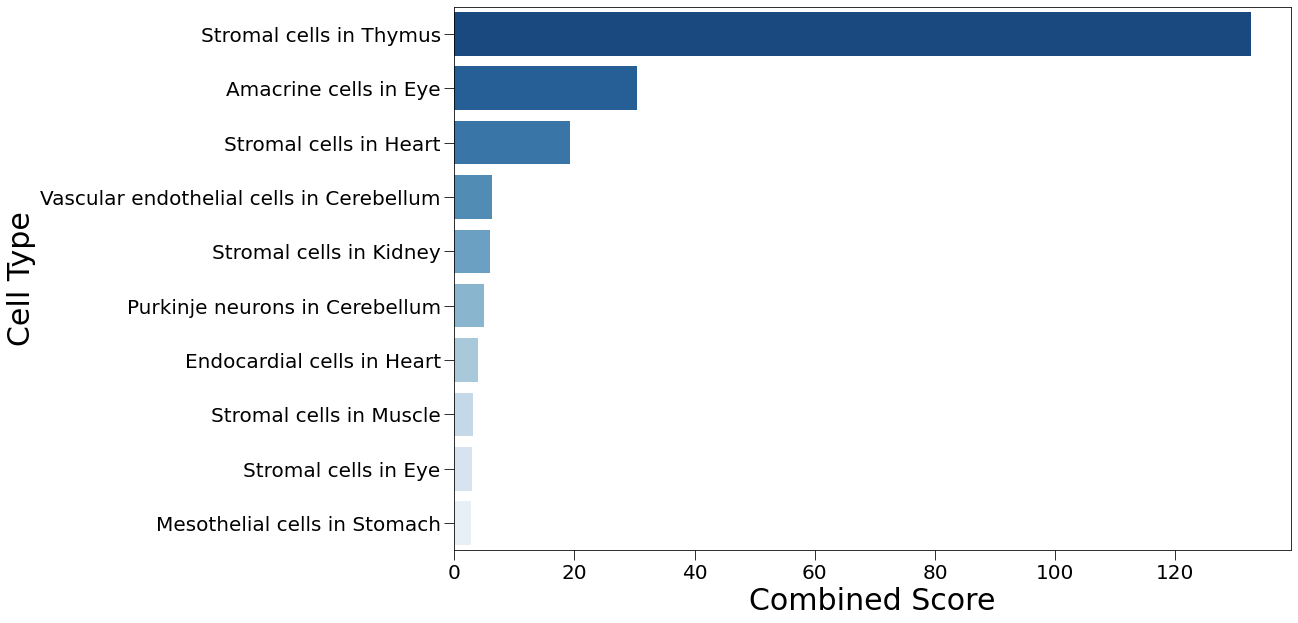

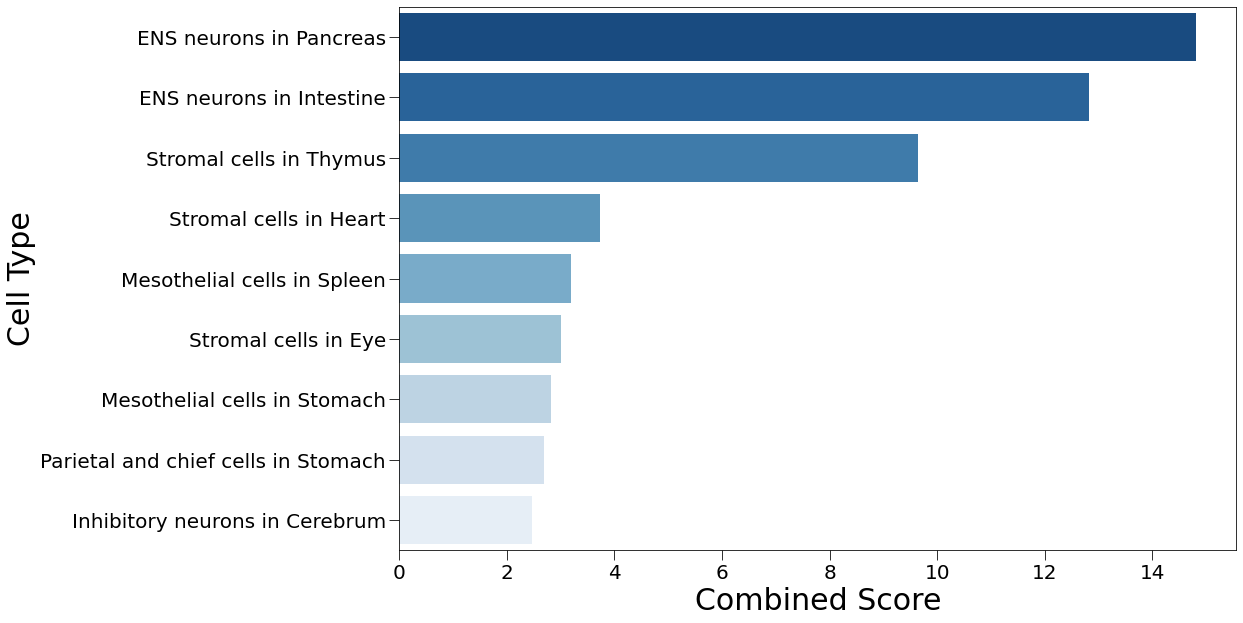

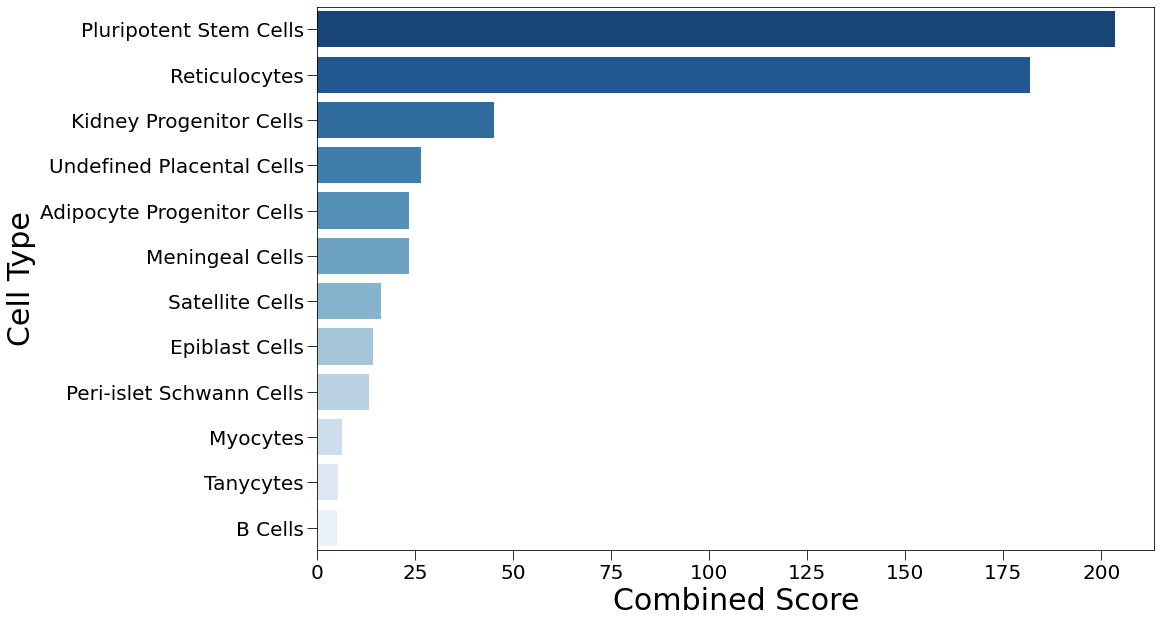

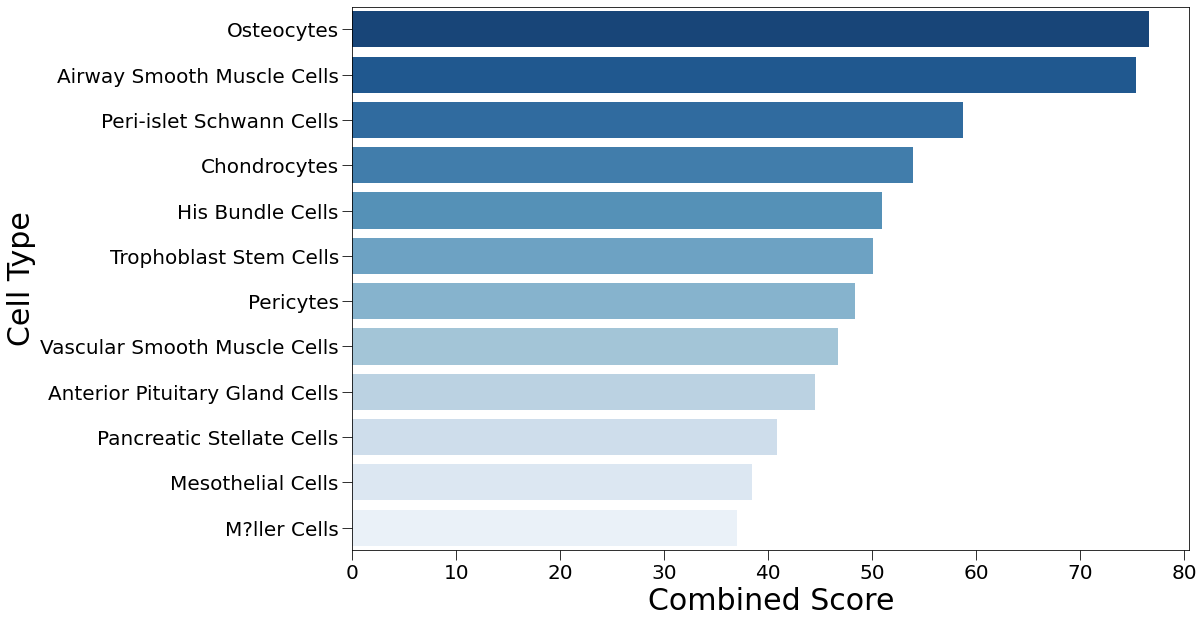

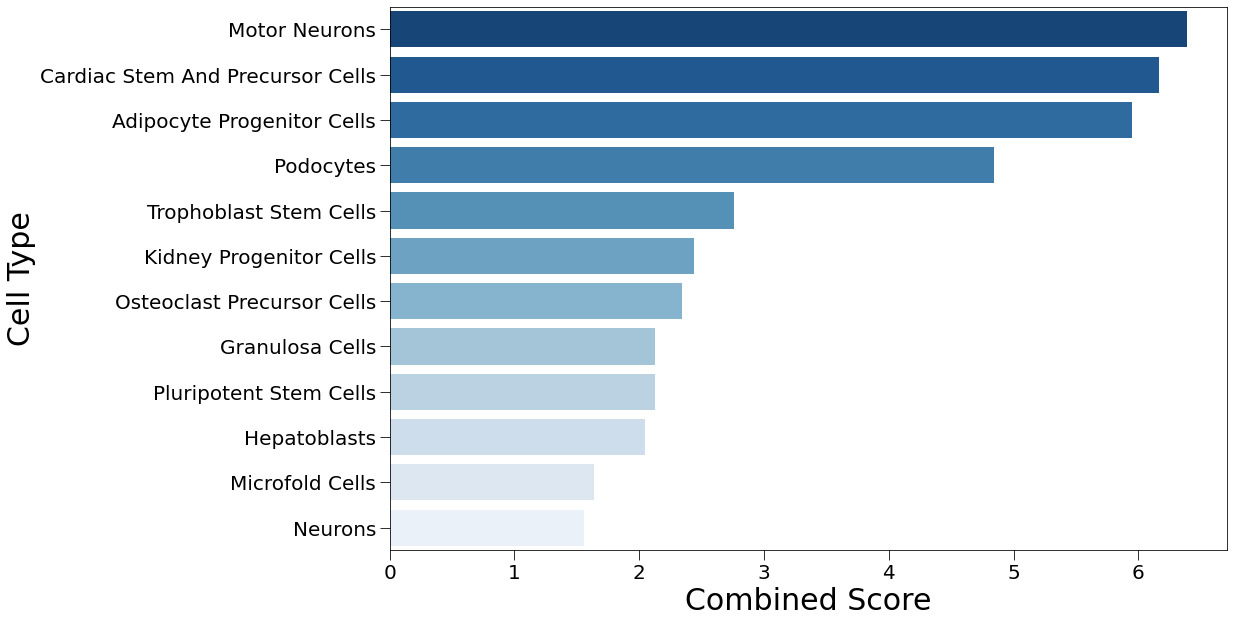

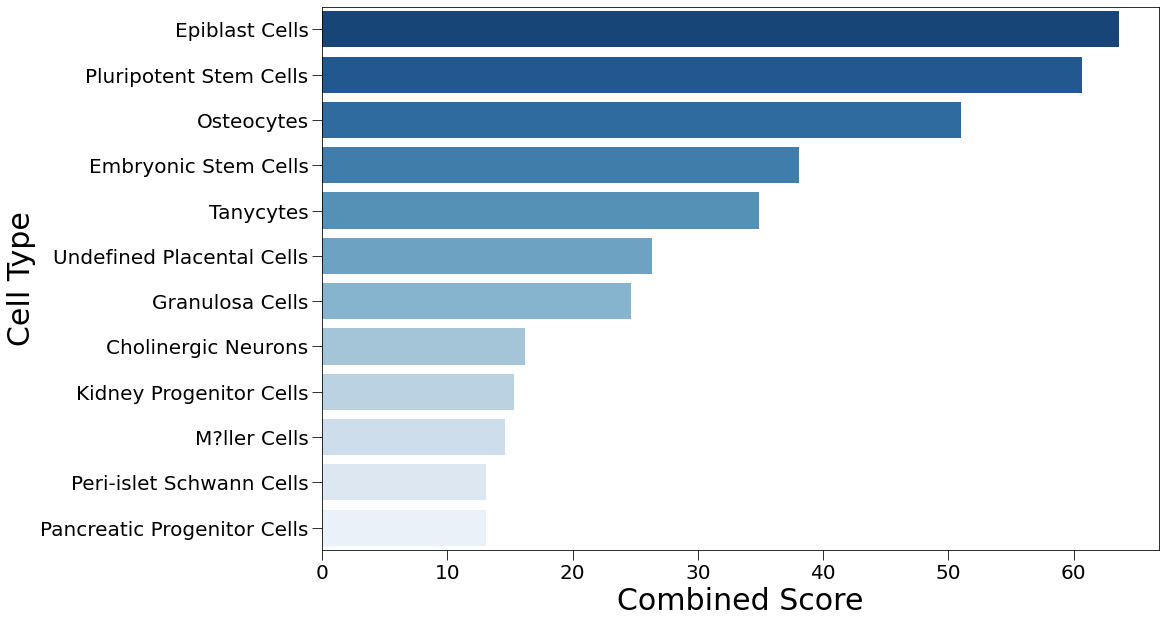

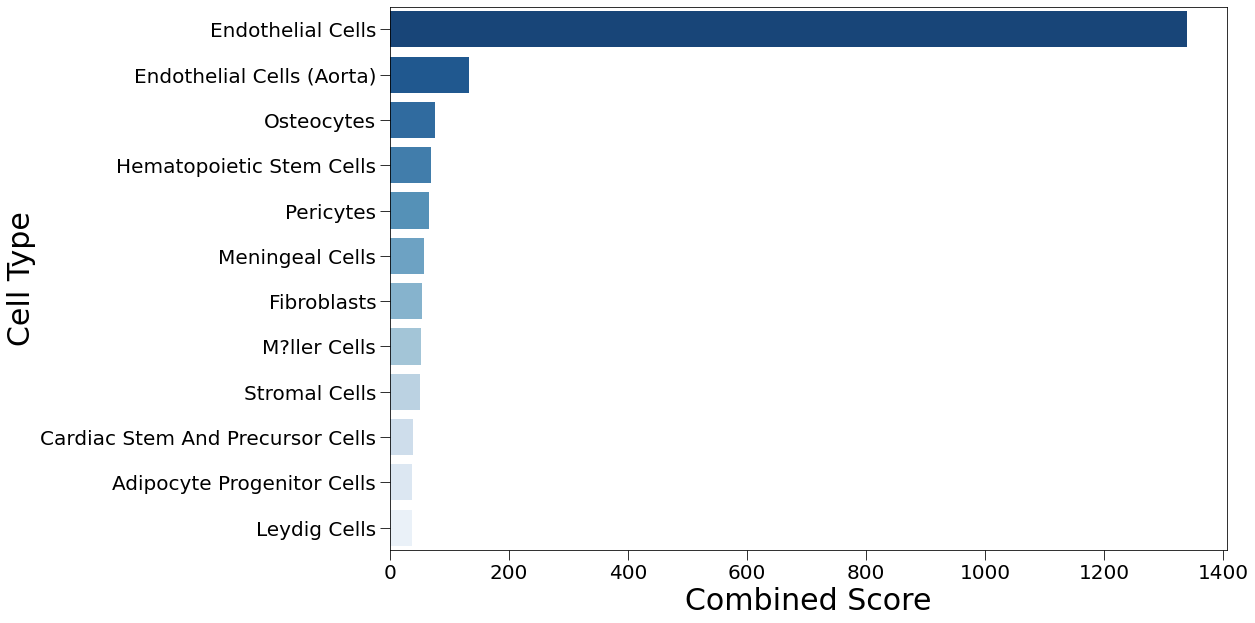

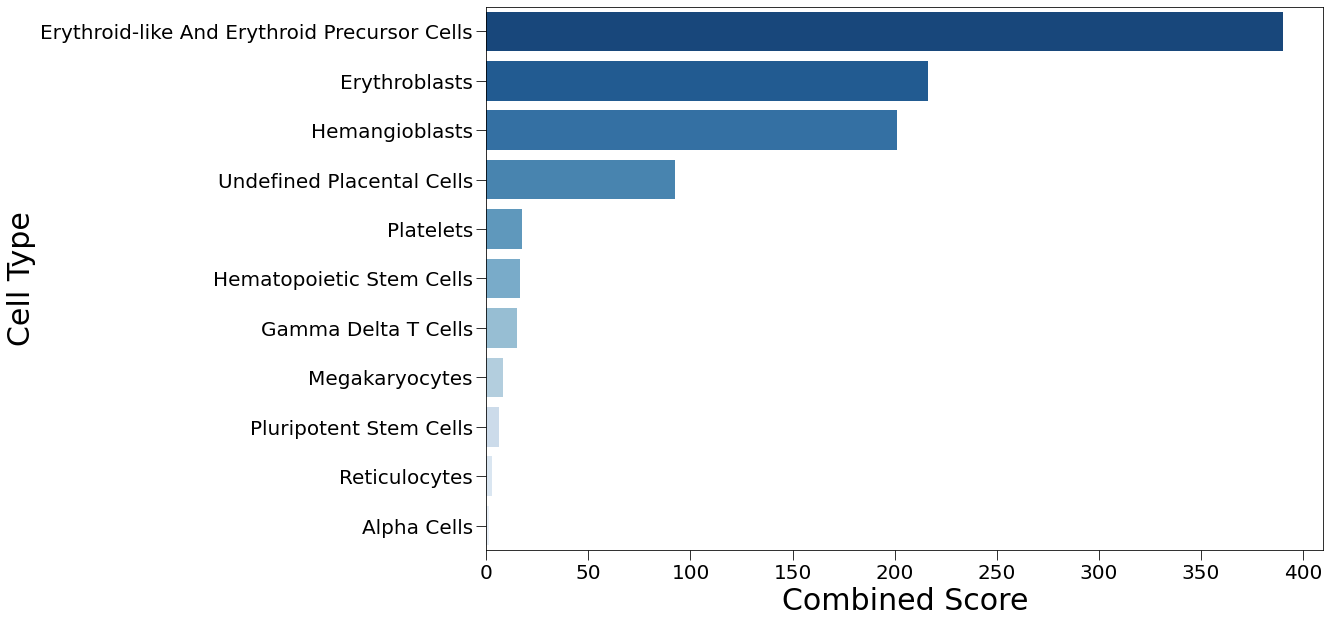

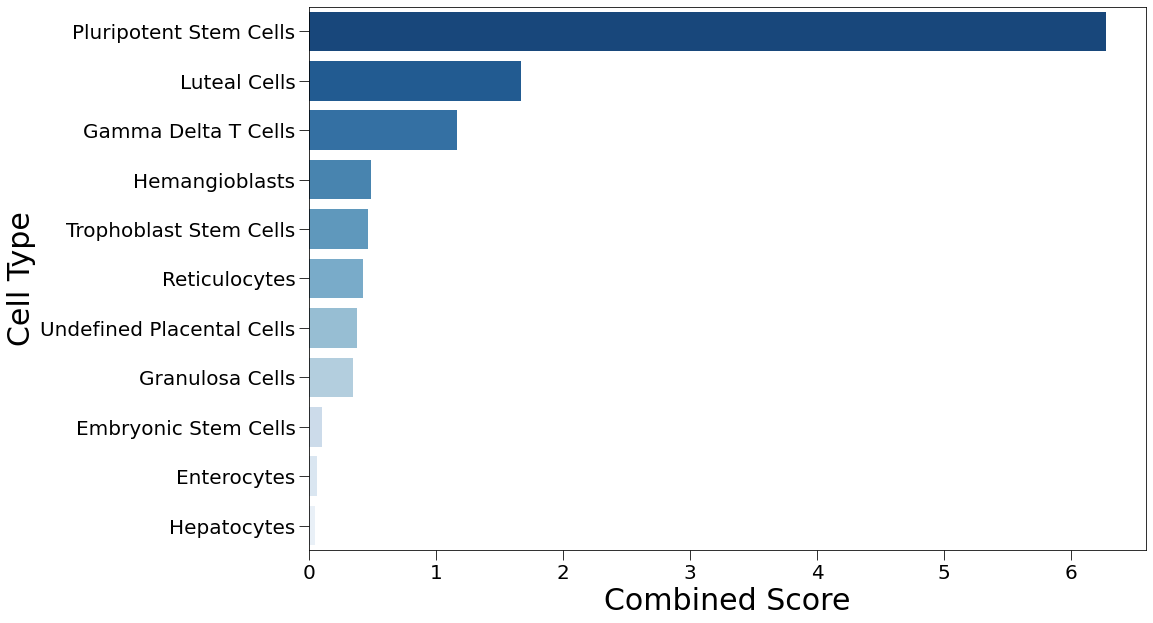

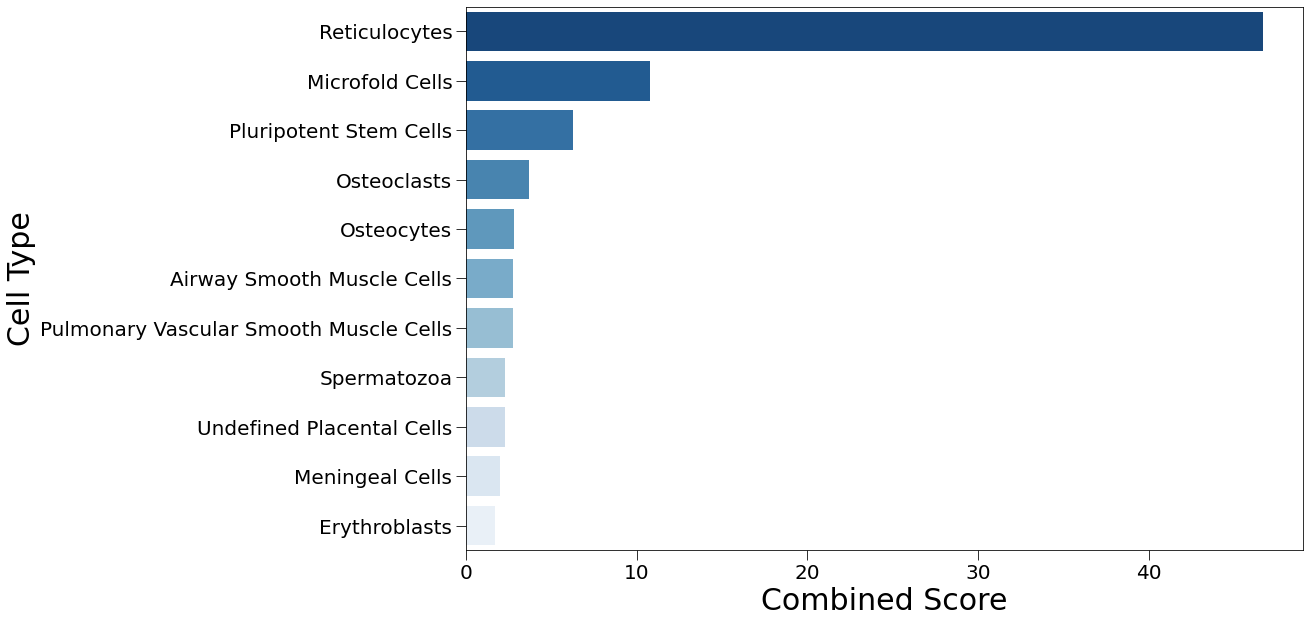

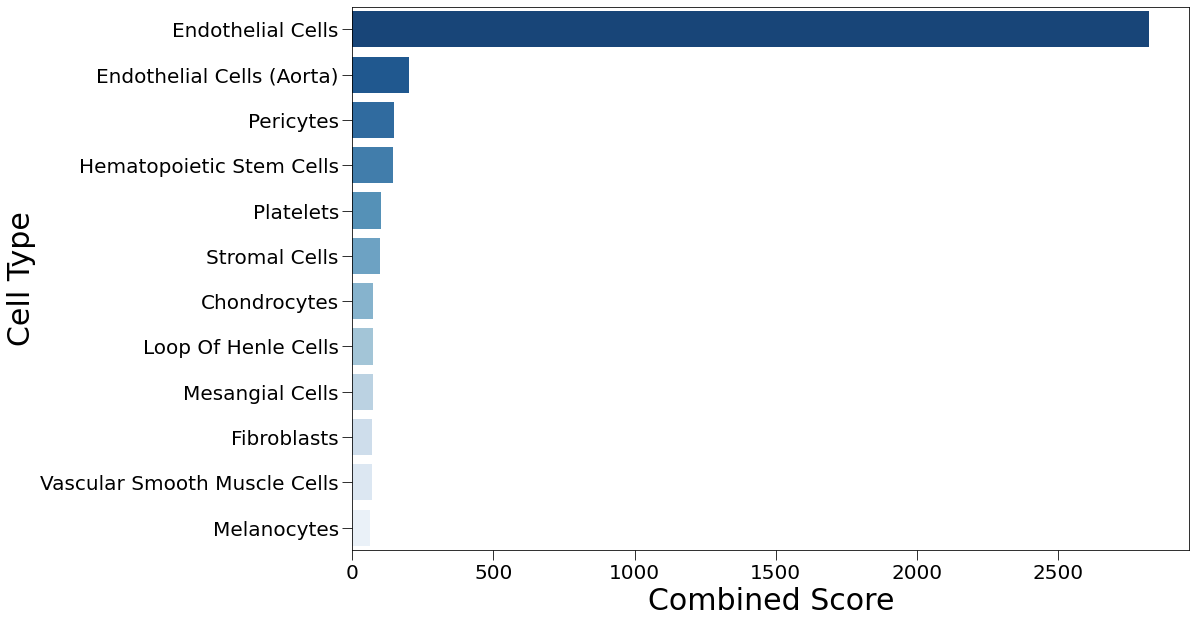

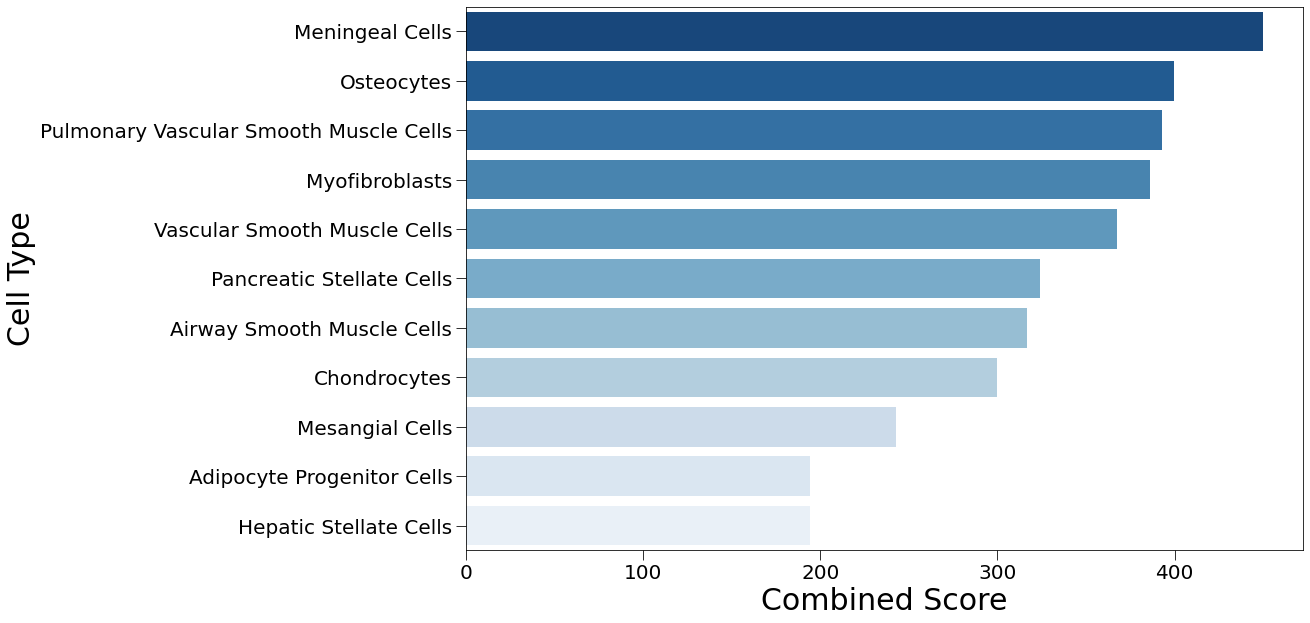

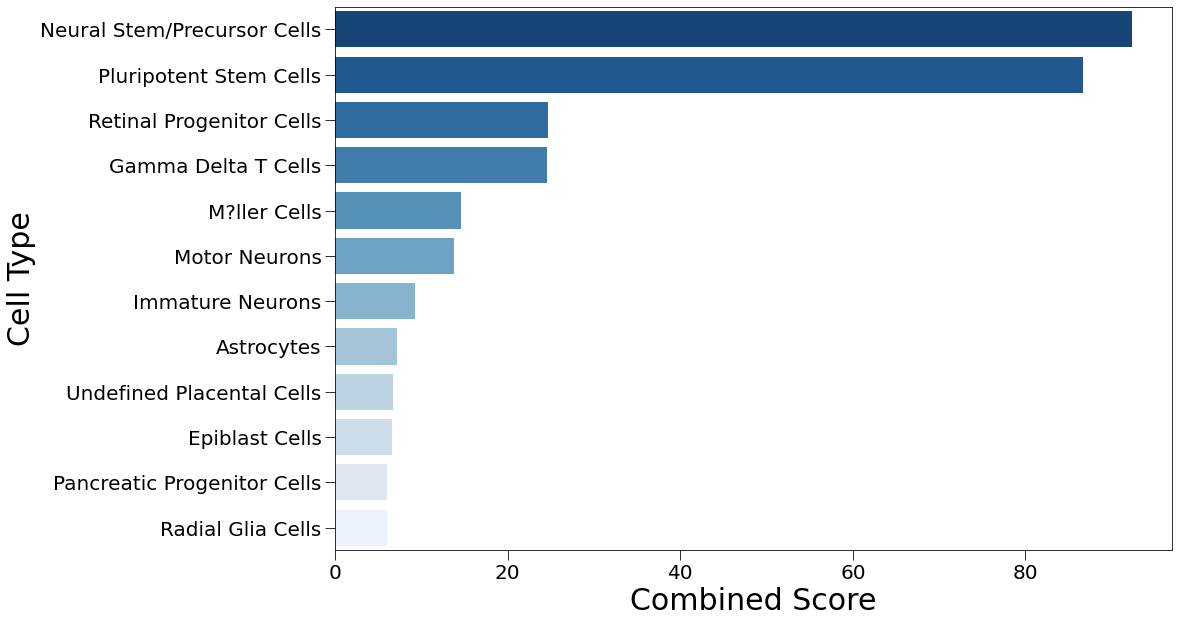

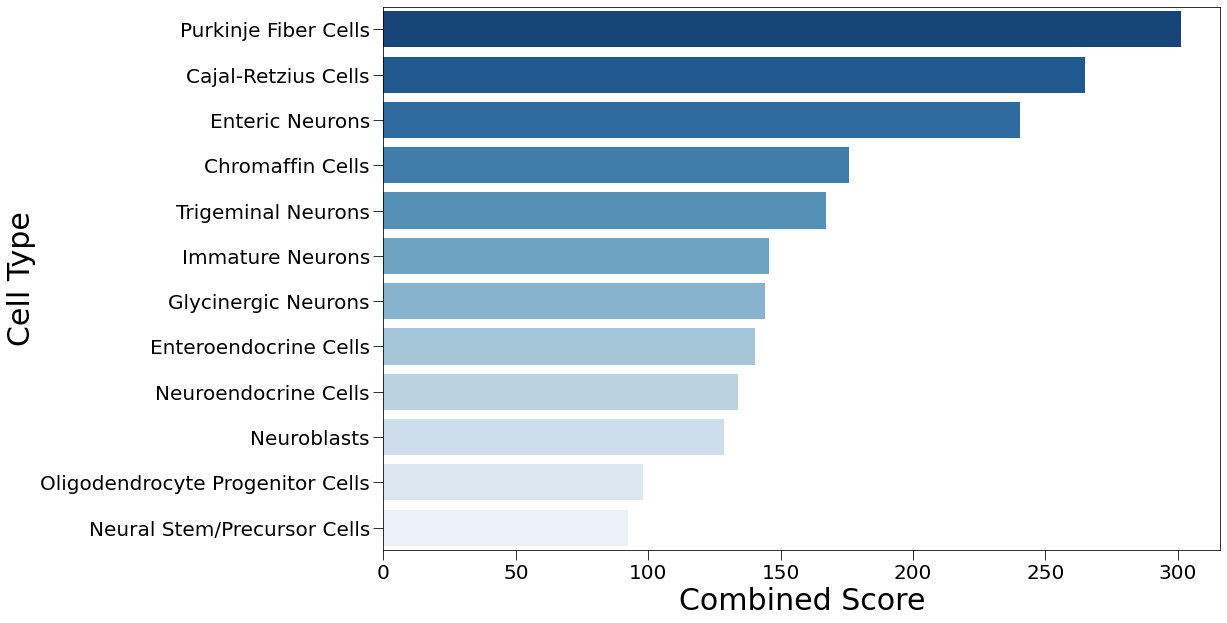

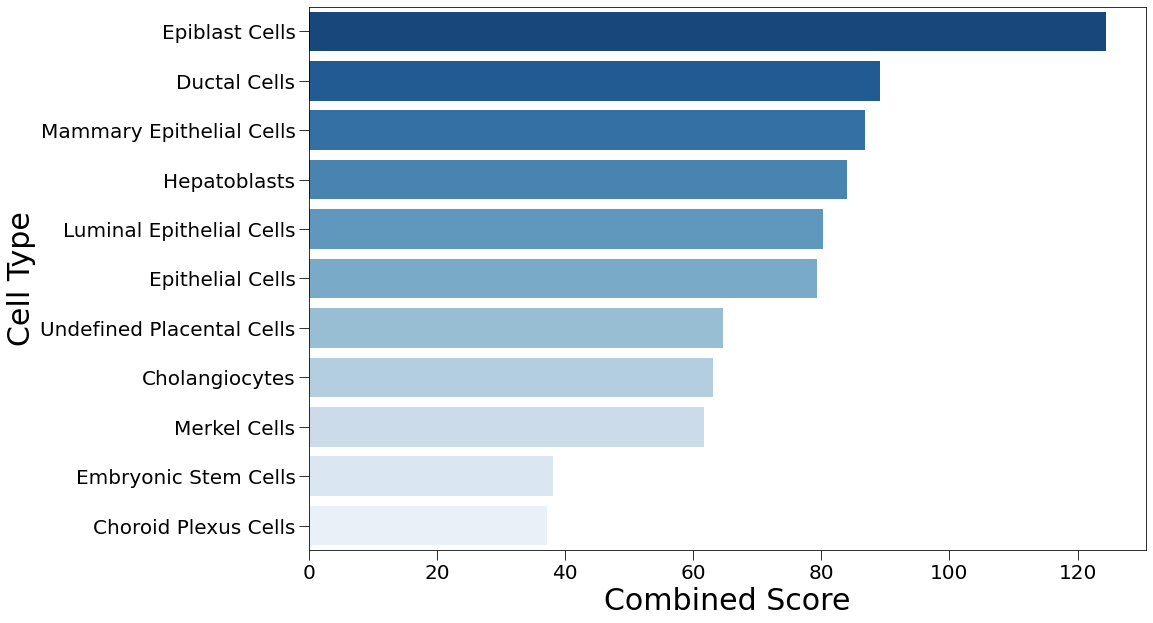

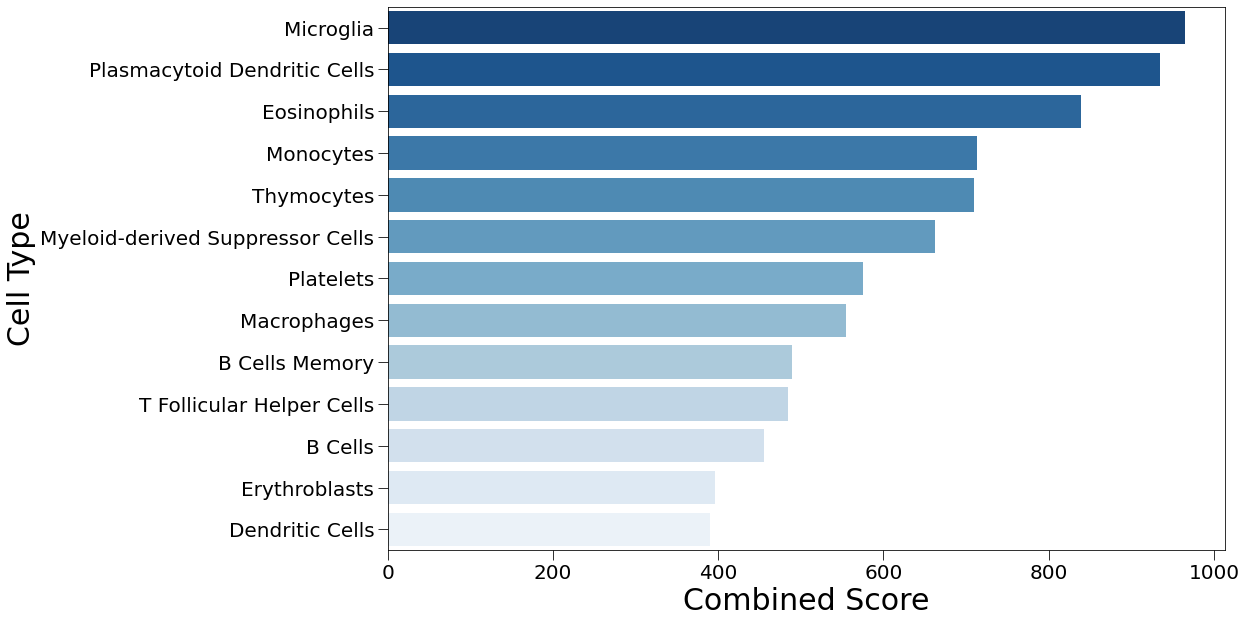

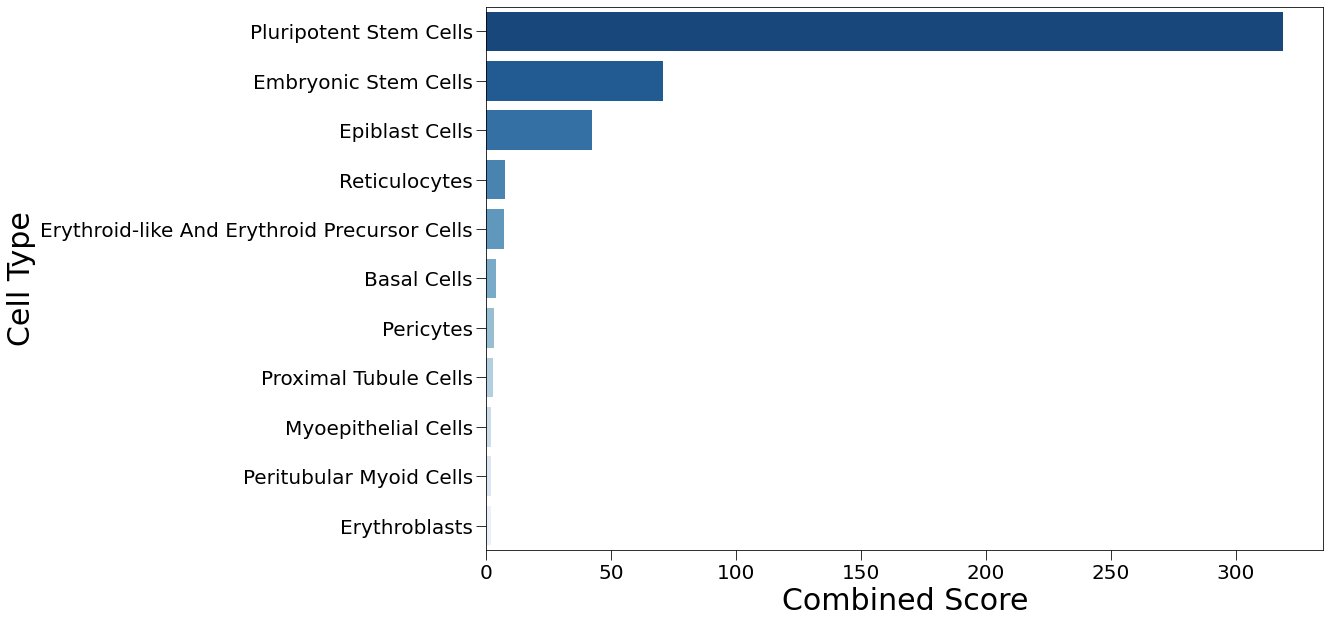

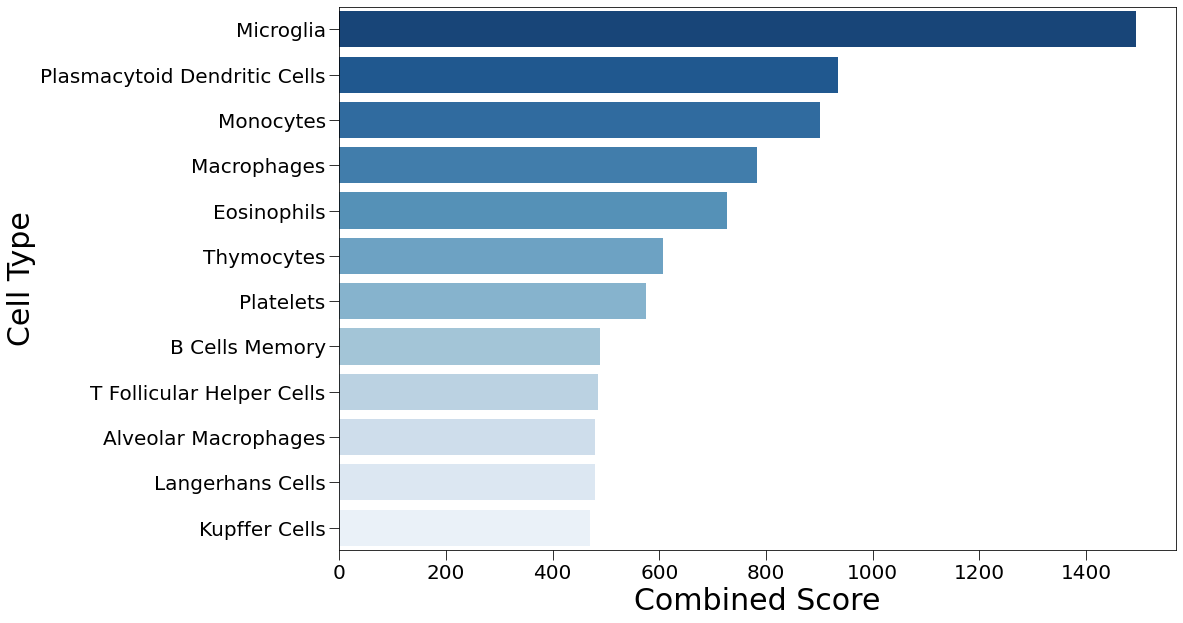

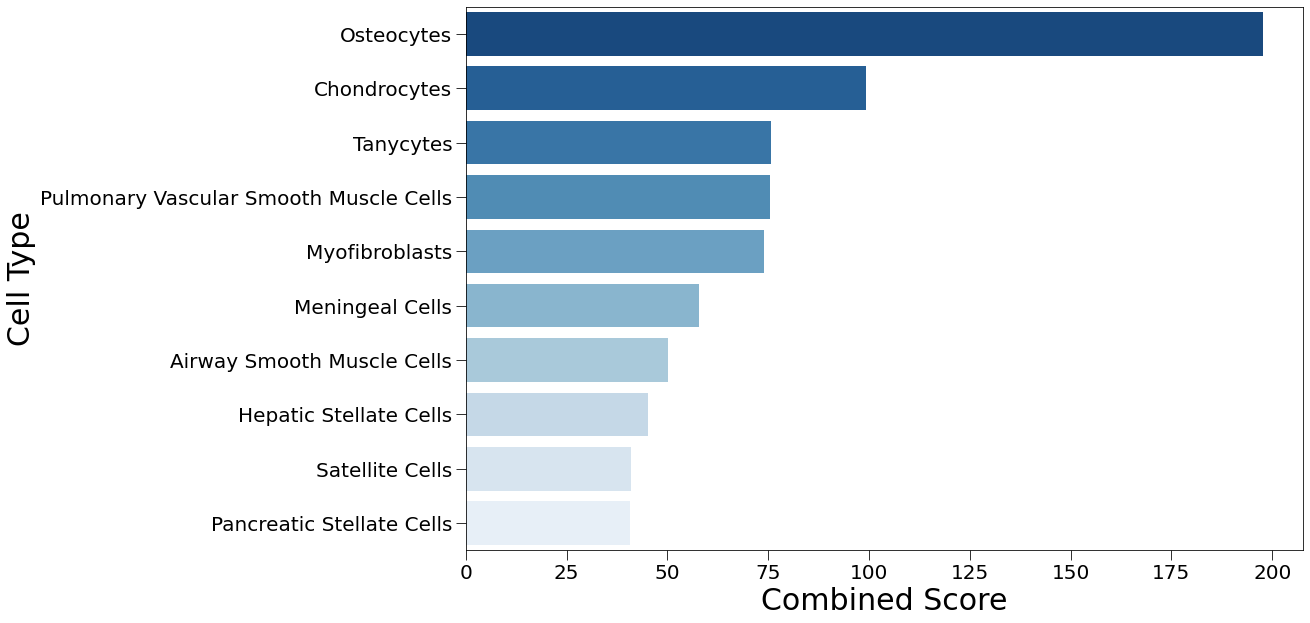

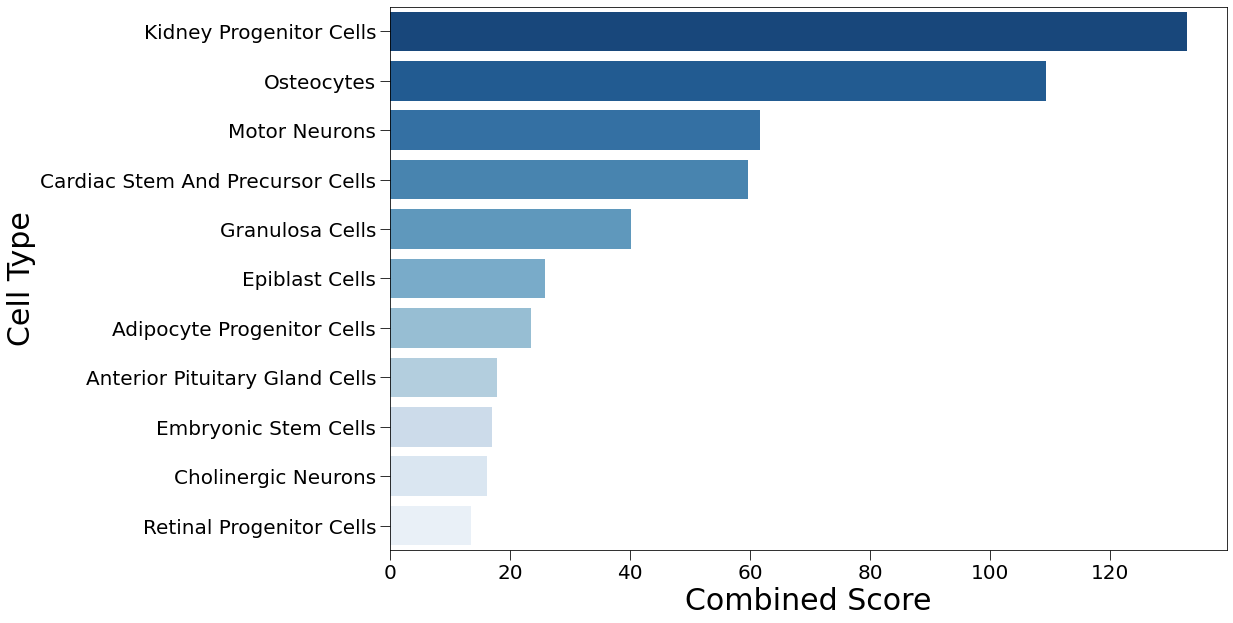

In [39]:
for library in ENRICHR_LIBRARIES:
    for time,adata in enumerate(adatas):
        for sheet in pd.ExcelFile(DIRECTORY+"Tables/Times/Enrich_"+library+"_"+adata.obs.loc[:,"Time"].values[0]+".xlsx").sheet_names:
            data = pd.read_excel(DIRECTORY+"Tables/Times/Enrich_"+library+"_"+adata.obs.loc[:,"Time"].values[0]+".xlsx",sheet_name=sheet)
            data.sort_values("Combined Score",ascending=False,inplace=True)

            fig,ax=plt.subplots(figsize=[15,10])
            sns.barplot(data = data.loc[:10,:],x="Combined Score",y="Name",palette="Blues_r",ax=ax)
            sctplot.plot_base(ax,title=library+"_"+sheet,labels=["Combined Score","Cell Type"],legend=False)

            fig.savefig(DIRECTORY+"Plots/Times/Enrichr/"+library+"_"+adata.obs.loc[:,"Time"].values[0]+"_"+sheet+".pdf",transparent=True,bbox_inches="tight")

## Save results

In [40]:
for time,adata in enumerate(adatas):
    adata.write(DIRECTORY+"Results/QC_"+adata.obs["Time"].values[0]+".h5ad")

## Projection of the time clusters over the Global

In [41]:
adata = scp.read(DIRECTORY+"Results/QC.h5ad")
adatas = [scp.read(DIRECTORY+"Results/QC_"+stage+".h5ad") for stage in np.sort(adata.obs["Time"].unique())]

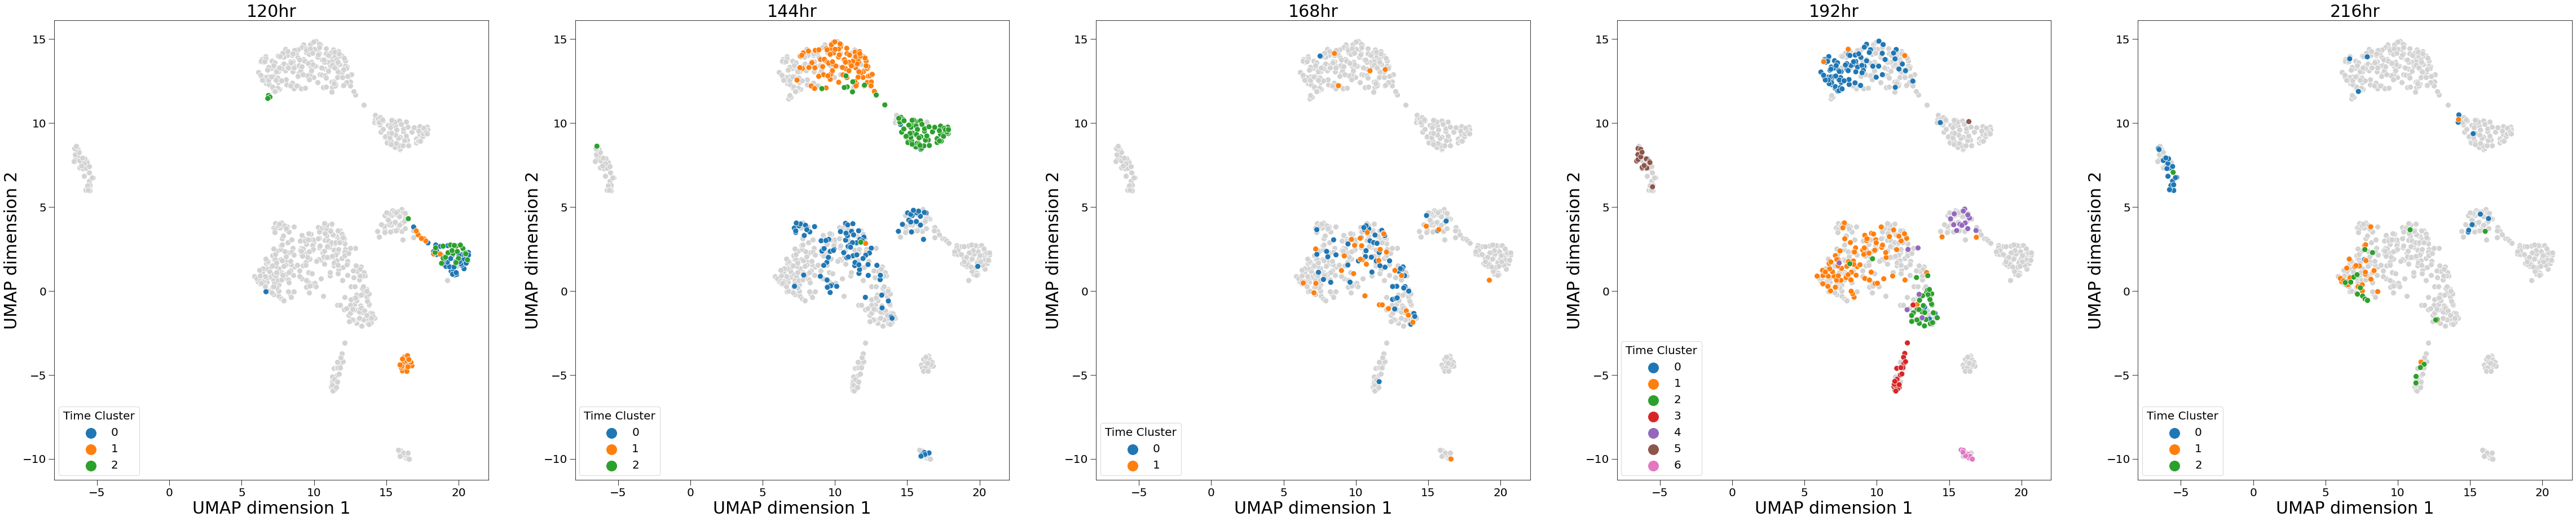

In [42]:
fig,ax = plt.subplots(1,5,figsize=[80,15])

for time,adatasub in enumerate(adatas):
    subset = adata.obs.index.isin(adatasub.obs.index)

    #Assign clusters from sorted file to global file
    clusters = adata.obs[["leiden"]]
    clusters.loc[:,"leiden_sorted"] = "-1"
    clusters.loc[subset,"leiden_sorted"] = adatasub.obs.loc[:,"leiden"].values
    
    #Scatter plots
    order = np.argsort(clusters.loc[subset,"leiden_sorted"])
    sns.scatterplot(x=adata.obsm[umap][np.invert(subset),0],y=adata.obsm[umap][np.invert(subset),1],color="lightgrey",s=100,ax=ax[time])
    sns.scatterplot(x=adata.obsm[umap][subset,0][order],y=adata.obsm[umap][subset,1][order],hue=clusters.loc[subset,"leiden_sorted"][order],s=100,ax=ax[time])
    sctplot.plot_base(ax[time],title=adatasub.obs["Time"].values[0],labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(0.01,0.01),legend_title="Time Cluster",legend_markerscale=3)

#Save figures
fig.savefig(DIRECTORY+"Plots/CA_Clusters_Times_Global_UMAP.pdf",bbox_inches="tight",transparent=True)